### Importing required libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_profiling
import os
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn import preprocessing
import operator
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE #Over sampling
import numpy as np
import time 
from itertools import cycle

from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from scipy import interp

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, f1_score, auc


# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from yellowbrick.classifier import ClassificationReport
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
import xgboost as xgb
from xgboost import XGBClassifier

### Reading data

The data we have choosen is the survey data https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey/. The survey was done in 2013-2014. The National Health and Nutrition Examination Survey (NHANES) is a program of studies designed to assess the health and nutritional status of adults and children in the United States. The survey is unique in that it combines interviews and physical examinations. NHANES is a major program of the National Center for Health Statistics (NCHS). NCHS is part of the Centers for Disease Control and Prevention (CDC) and has the responsibility for producing vital and health statistics for the Nation.

The NHANES program began in the early 1960s and has been conducted as a series of surveys focusing on different population groups or health topics. In 1999, the survey became a continuous program that has a changing focus on a variety of health and nutrition measurements to meet emerging needs. The survey examines a nationally representative sample of about 5,000 persons each year. These persons are located in counties across the country, 15 of which are visited each year.

The NHANES interview includes demographic, socioeconomic, dietary, and health-related questions. The examination component consists of medical, dental, and physiological measurements, as well as laboratory tests administered by highly trained medical personnel.

In [2]:
nhs_diet = pd.read_csv("data/national-health-and-nutrition-examination-survey/diet.csv")
nhs_demographic = pd.read_csv("data/national-health-and-nutrition-examination-survey/demographic.csv")
nhs_examination = pd.read_csv("data/national-health-and-nutrition-examination-survey/examination.csv")
nhs_labs = pd.read_csv("data/national-health-and-nutrition-examination-survey/labs.csv")
nhs_questionnaire = pd.read_csv("data/national-health-and-nutrition-examination-survey/questionnaire.csv")

In our case, we do not need the diet data except for one feature. This diet data is particularly about what a person has eaten during the days when survey was conducted. So we have removed all that data for better predictions

In [3]:
nhs_diet_new = nhs_diet[['SEQN','DBD100']]

## Identifying the features and their types

### Dividing categorical and numerical

In [4]:
def split_columns(df):
    col = [c for c in df.columns if c not in ['SEQN']]
    numclasses=[]
    for c in col:
        numclasses.append(len(df[c].unique()))
    threshold=10
    np.array(numclasses).size
    categorical_variables = list(np.array(col)[np.array(numclasses) < threshold])
    numerical_variables = set(df.columns)^set(categorical_variables)
    return categorical_variables, numerical_variables

In [5]:
#questionaire data
ques_cat, ques_cont = split_columns(nhs_questionnaire)
ques_obj = nhs_questionnaire[list(ques_cont)].select_dtypes(include=['object']).columns
ques_cont = set(ques_cont)^set(ques_obj)

#diet data
diet_cat, diet_cont = split_columns(nhs_diet_new)
diet_obj = nhs_diet_new[list(diet_cont)].select_dtypes(include=['object']).columns
diet_cont = set(diet_cont)^set(diet_obj)
#demographic data
demo_cat, demo_cont = split_columns(nhs_demographic)
demo_obj = nhs_demographic[list(demo_cont)].select_dtypes(include=['object']).columns
demo_cont = set(demo_cont)^set(demo_obj)
#exam data
exam_cat, exam_cont = split_columns(nhs_examination)
exam_obj = nhs_examination[list(exam_cont)].select_dtypes(include=['object']).columns
exam_cont = set(exam_cont)^set(exam_obj)
#labs data
labs_cat, labs_cont = split_columns(nhs_labs)
labs_obj = nhs_labs[list(labs_cont)].select_dtypes(include=['object']).columns
labs_cont = set(labs_cont)^set(labs_obj)

In [6]:
#assert check whether we have covered all the features
assert len(ques_cat) + len(ques_cont) +len(ques_obj)  == len(nhs_questionnaire.columns)
assert len(diet_cat) + len(diet_cont) +len(diet_obj) == len(nhs_diet_new.columns)
assert len(demo_cat) + len(demo_cont) +len(demo_obj) == len(nhs_demographic.columns)
assert len(exam_cat) + len(exam_cont) +len(exam_obj) == len(nhs_examination.columns)
assert len(labs_cat) + len(labs_cont) +len(labs_obj) == len(nhs_labs.columns)

### Cleaning and Visualizing variables separately

In [7]:
def clean_cat(df,cat_cols):
    '''
    This function takes in the categorical features as input and cleans them
    '''
    for i in cat_cols:
        df[i].replace(np.nan, None,inplace=True)
        df[i].replace('', None,inplace=True)

In [8]:
def visualize_cat_columns(df,cat_cols):
    '''
    Lists the distinct values for categorical columns
    '''
    # Categorical columns 
    for i in cat_cols:
        print(i) # print field name
        print(df[i].unique()) # print number of distinct values
        print(df[i].value_counts()) # for each distinct value print the number of occurances
        print("")
        print("")

In [9]:
def clean_float(df,float_cols):
    '''
    This function takes in float columns and cleans it
    '''
    for i in float_cols:
        df[i] = df[i].astype(float)
    return df

In [10]:
def visualize_float_columns(df, float_cols):
    '''
    This function visualizes Box-and-whisker plots for continuous variables
    '''
    
    # FLoat columns
    for i in float_cols:
        sns.boxplot(df[i])

        # Print the three highest values
        highest_vals = df[i].nlargest(3).tolist() # get 3 highest values
        smallest_val = min(df[i])
        
        plt.text(smallest_val, -0.3, highest_vals[0])
        plt.text(smallest_val, -0.2, highest_vals[1])
        plt.text(smallest_val, -0.1, highest_vals[2])

        plt.show()

In [11]:
# visualize categorical features dataframe wise
clean_cat(nhs_questionnaire,ques_cat)
visualize_cat_columns(nhs_questionnaire,ques_cat)

ACD011A
[ 1.]
1.0    10175
Name: ACD011A, dtype: int64


ACD011B
[ nan   8.]
8.0    9981
Name: ACD011B, dtype: int64


ACD011C
[ nan   9.]
9.0    10078
Name: ACD011C, dtype: int64


ACD040
[ nan   4.   5.   1.   3.   2.   9.   7.]
5.0    2540
1.0    2287
4.0    1981
3.0    1968
2.0    1378
9.0      15
7.0       1
Name: ACD040, dtype: int64


ACD110
[ nan   1.   5.   2.   4.   3.]
1.0    3784
5.0    3405
4.0    1265
3.0     860
2.0     844
Name: ACD110, dtype: int64


ALQ101
[ 1.  2.  9.]
1.0    7037
2.0    3123
9.0      15
Name: ALQ101, dtype: int64


ALQ110
[ nan   1.   2.   9.]
2.0    5575
1.0    4560
9.0      33
Name: ALQ110, dtype: int64


ALQ120U
[ 3.  1.  2.]
1.0    4188
3.0    3242
2.0    2745
Name: ALQ120U, dtype: int64


ALQ141U
[ nan   1.   3.   2.]
3.0    6123
1.0    2337
2.0    1714
Name: ALQ141U, dtype: int64


ALQ151
[ 1.  2.  9.]
2.0    8498
1.0    1672
9.0       5
Name: ALQ151, dtype: int64


BPQ020
[ 1.  2.  9.]
2.0    6672
1.0    3494
9.0       9
Name: BPQ020, dtype: 

2.0    8475
1.0    1695
9.0       5
Name: CBQ596, dtype: int64


CBQ606
[ nan   2.   1.]
2.0    6653
1.0    3515
Name: CBQ606, dtype: int64


CBQ611
[ nan   2.   1.   9.]
2.0    6612
1.0    3550
9.0       6
Name: CBQ611, dtype: int64


CBQ505
[ 1.  2.]
1.0    8555
2.0    1620
Name: CBQ505, dtype: int64


CBQ535
[ 1.  2.  9.]
2.0    6155
1.0    3953
9.0      67
Name: CBQ535, dtype: int64


CBQ540
[ 2.  1.  9.]
2.0    6073
1.0    4099
9.0       3
Name: CBQ540, dtype: int64


CBQ545
[ 2.  4.  1.  3.  9.]
2.0    3116
1.0    2792
4.0    2644
3.0    1616
9.0       7
Name: CBQ545, dtype: int64


CBQ550
[ 1.  2.]
1.0    8304
2.0    1871
Name: CBQ550, dtype: int64


CBQ552
[ 1.  2.  9.]
1.0    6421
2.0    3720
9.0      34
Name: CBQ552, dtype: int64


CBQ580
[ 1.  2.  9.]
2.0    7006
1.0    3084
9.0      85
Name: CBQ580, dtype: int64


CBQ585
[ 2.  1.  9.]
2.0    6022
1.0    4145
9.0       8
Name: CBQ585, dtype: int64


CBQ590
[ 2.  3.  4.  1.  9.]
2.0    3051
1.0    2822
4.0    2567
3.0    1716

[ nan   2.   1.   7.   9.]
1.0    5559
2.0    4334
9.0      99
7.0      32
Name: HIQ260, dtype: int64


HIQ105
[ nan   1.   2.]
1.0    9155
2.0    1018
Name: HIQ105, dtype: int64


HIQ270
[ 1.  9.  2.  7.]
1.0    9750
2.0     358
9.0      63
7.0       4
Name: HIQ270, dtype: int64


HIQ210
[ 2.  1.  9.]
2.0    9590
1.0     578
9.0       7
Name: HIQ210, dtype: int64


HOQ065
[ 2.  1.  3.  7.  9.]
1.0    5604
2.0    4332
3.0     227
7.0      11
9.0       1
Name: HOQ065, dtype: int64


HUQ010
[2 4 3 5 1 9 7]
3    3235
2    2716
1    2615
4    1330
5     274
9       3
7       2
Name: HUQ010, dtype: int64


HUQ020
[ 1.  2.  3.  7.  9.]
3.0    7413
1.0    1959
2.0     801
9.0       1
7.0       1
Name: HUQ020, dtype: int64


HUQ030
[1 2 3]
1    8944
2    1194
3      37
Name: HUQ030, dtype: int64


HUQ041
[  2.   1.   6.   3.   5.   4.  77.]
2.0     7636
1.0     2058
3.0      265
4.0       96
5.0       76
6.0       42
77.0       2
Name: HUQ041, dtype: int64


HUQ061
[ nan   4.   5.   2.   3.   

[ nan  18.]
18.0    10132
Name: OHQ780I, dtype: int64


OHQ780J
[ nan  19.]
19.0    9695
Name: OHQ780J, dtype: int64


OHQ780K
[ nan  20.]
20.0    10148
Name: OHQ780K, dtype: int64


OHQ555G
[ nan   1.   9.   2.]
1.0    10010
9.0       95
2.0       67
Name: OHQ555G, dtype: int64


OHQ555U
[ nan   2.   1.]
2.0    7539
1.0    2633
Name: OHQ555U, dtype: int64


OHQ560G
[ nan   1.   9.   2.]
1.0    10061
2.0       87
9.0       24
Name: OHQ560G, dtype: int64


OHQ560U
[ nan   2.   1.]
2.0    8409
1.0    1763
Name: OHQ560U, dtype: int64


OHQ565
[ nan   2.   9.   1.]
2.0    9207
1.0     878
9.0      87
Name: OHQ565, dtype: int64


OHQ570U
[ nan   2.   1.]
2.0    7039
1.0    3073
Name: OHQ570U, dtype: int64


OHQ575G
[ nan   1.   2.   9.]
1.0    8182
2.0    1404
9.0     526
Name: OHQ575G, dtype: int64


OHQ575U
[ nan   2.   1.]
2.0    9386
1.0     726
Name: OHQ575U, dtype: int64


OHQ580
[ nan   2.   9.   1.]
2.0    9561
1.0     510
9.0     101
Name: OHQ580, dtype: int64


OHQ585U
[ nan   2. 

Name: PFQ061E, dtype: int64


PFQ061F
[ 1.  5.  2.  4.  3.]
1.0    7062
2.0    1715
3.0     552
4.0     466
5.0     380
Name: PFQ061F, dtype: int64


PFQ061G
[ 1.  2.  4.  3.  5.]
1.0    8353
2.0     797
5.0     517
4.0     280
3.0     228
Name: PFQ061G, dtype: int64


PFQ061H
[ 1.  4.  2.  3.  5.]
1.0    8778
2.0     904
3.0     269
4.0     181
5.0      43
Name: PFQ061H, dtype: int64


PFQ061I
[ 1.  4.  2.  3.  5.  9.]
1.0    7331
2.0    2017
3.0     539
4.0     256
5.0      31
9.0       1
Name: PFQ061I, dtype: int64


PFQ061J
[ 1.  2.  3.  5.  4.]
1.0    8080
2.0    1587
3.0     405
5.0      59
4.0      44
Name: PFQ061J, dtype: int64


PFQ061K
[ 1.  2.  4.  3.]
1.0    9468
2.0     584
3.0     108
4.0      15
Name: PFQ061K, dtype: int64


PFQ061L
[ 1.  2.  3.  4.  5.]
1.0    8545
2.0    1230
3.0     308
4.0      88
5.0       4
Name: PFQ061L, dtype: int64


PFQ061M
[ 1.  4.  2.  3.  5.  9.]
1.0    5255
2.0    2166
4.0    1314
3.0    1210
5.0     226
9.0       4
Name: PFQ061M, dtype: in

[ nan   2.   1.   9.]
2.0    6177
1.0    2310
9.0    1430
Name: RHQ596, dtype: int64


RHQ602Q
[ nan   2.   3.   8.   1.  10.  15.   5.]
2.0     3569
3.0     3229
10.0     978
8.0      894
15.0     467
5.0      328
1.0      259
Name: RHQ602Q, dtype: int64


RHQ602U
[ nan   2.   1.]
2.0    6998
1.0    2726
Name: RHQ602U, dtype: int64


RXQ510
[ 1.  2.  9.  7.]
2.0    6711
1.0    3451
9.0       7
7.0       6
Name: RXQ510, dtype: int64


RXQ515
[ 1.  3.  2.  4.]
1.0    7458
2.0    1787
3.0     558
4.0     372
Name: RXQ515, dtype: int64


RXQ520
[ nan   2.   1.   9.   7.]
2.0    9629
1.0     533
7.0       8
9.0       3
Name: RXQ520, dtype: int64


RXQ525G
[ 1.  2.  3.  9.]
1.0    8728
3.0     896
2.0     533
9.0      18
Name: RXQ525G, dtype: int64


RXQ525Q
[  nan    1.    2.    5.    4.    3.  999.]
1.0      4981
2.0      3480
4.0      1032
3.0       419
5.0       224
999.0       1
Name: RXQ525Q, dtype: int64


RXQ525U
[ nan   2.   1.]
2.0    8881
1.0    1256
Name: RXQ525U, dtype: int64



1.0    3999
3.0    2783
4.0    2071
2.0    1315
9.0       3
7.0       1
Name: WHQ500, dtype: int64


WHQ520
[ nan   3.   1.   2.   9.]
2.0    4548
1.0    4115
3.0    1507
9.0       2
Name: WHQ520, dtype: int64




posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


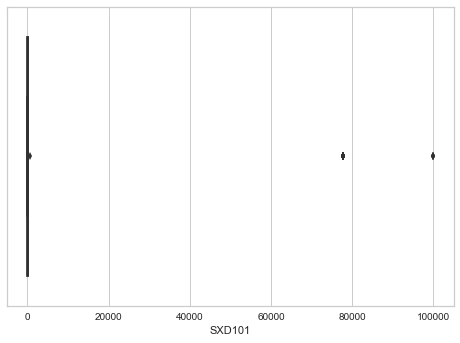

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


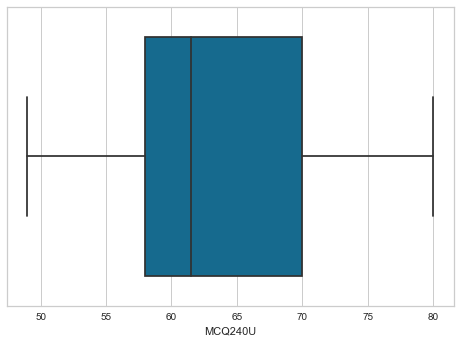

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


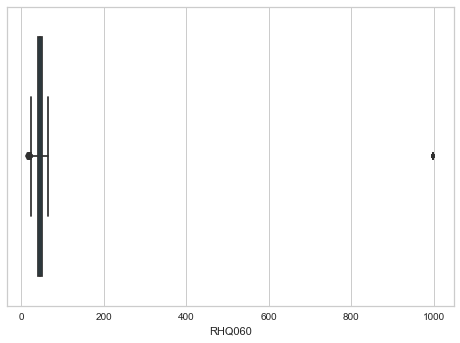

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


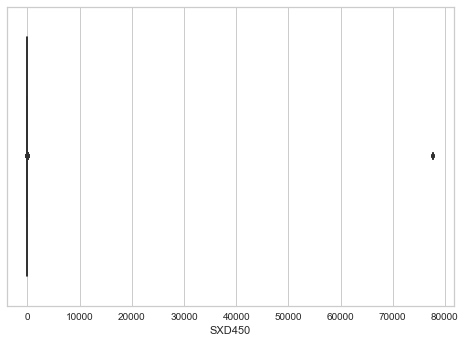

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


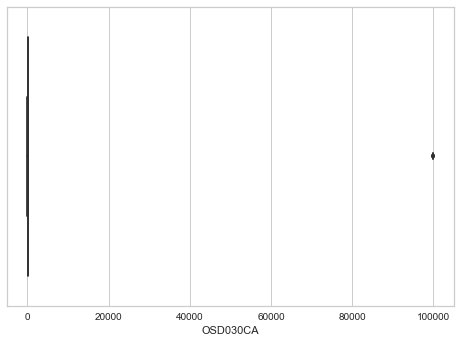

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


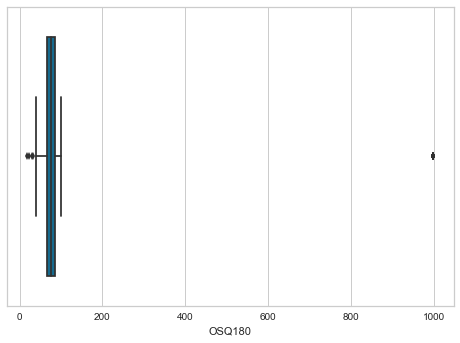

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


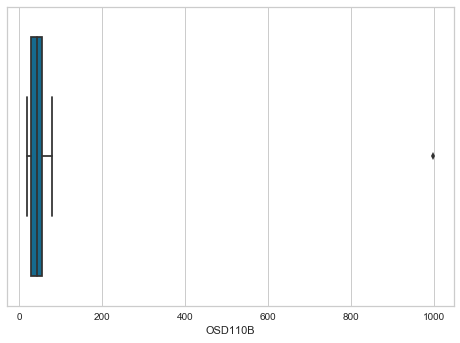

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


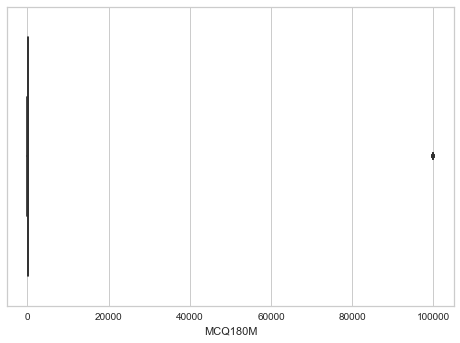

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


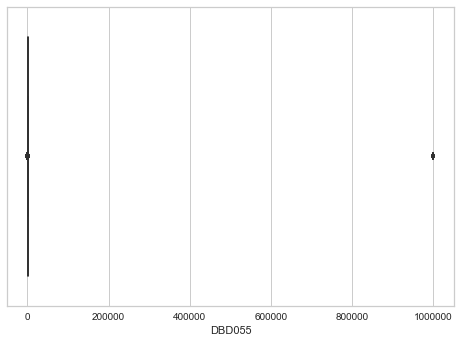

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


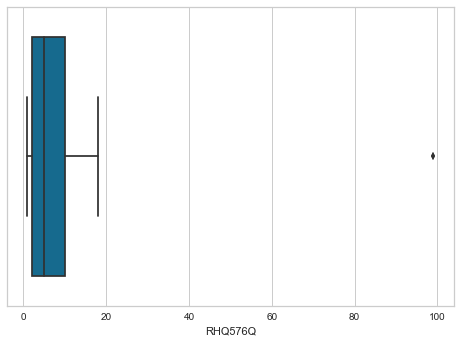

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


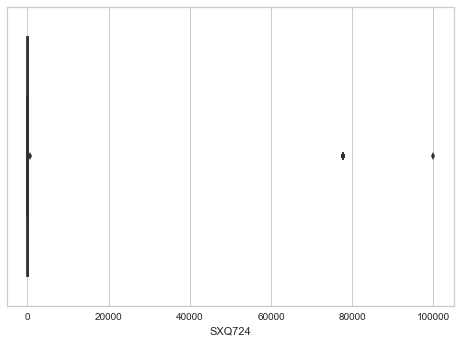

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


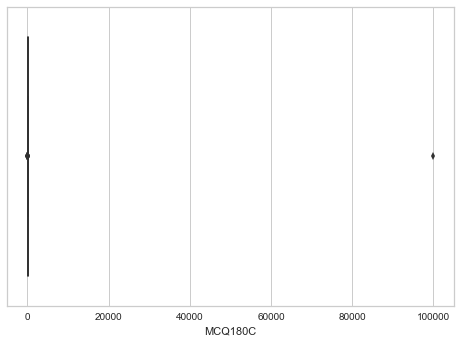

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


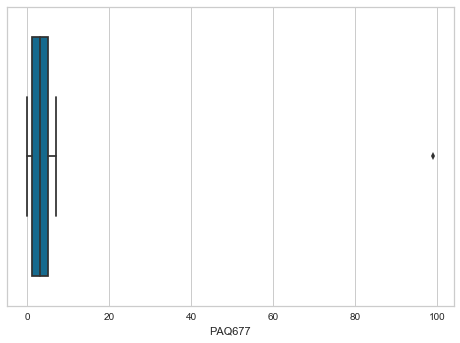

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


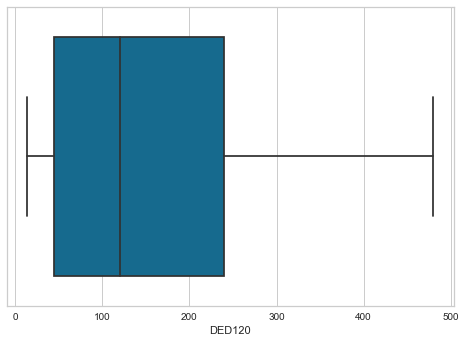

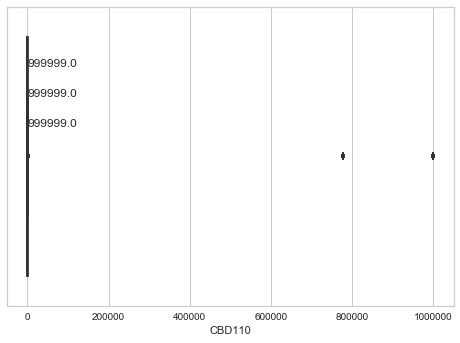

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


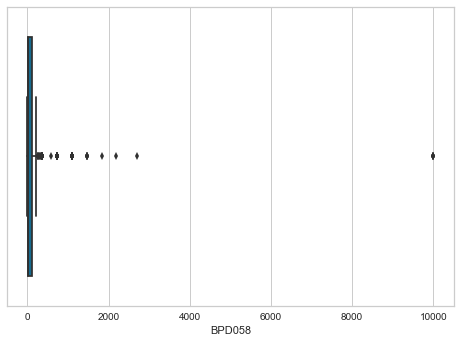

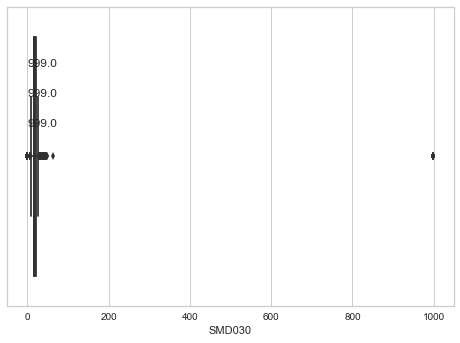

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


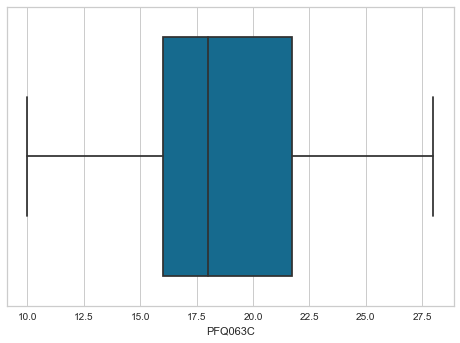

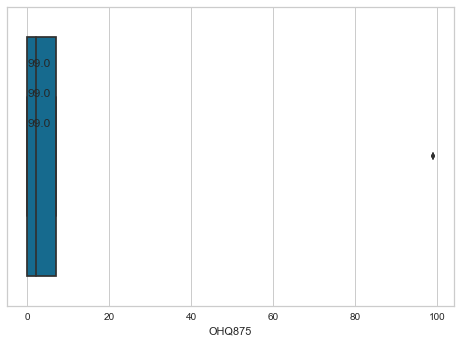

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


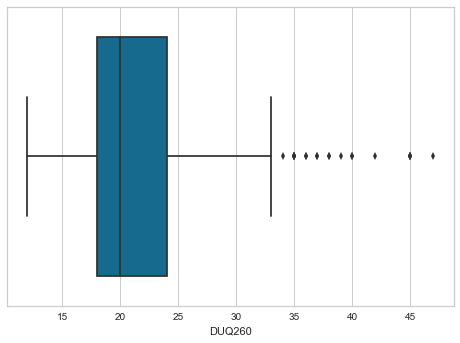

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


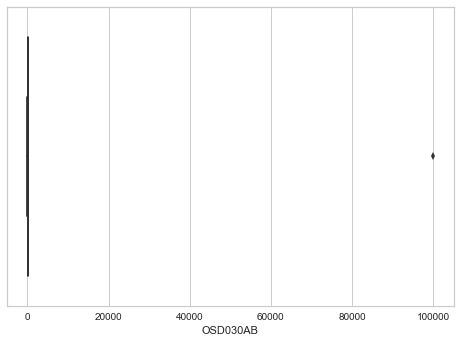

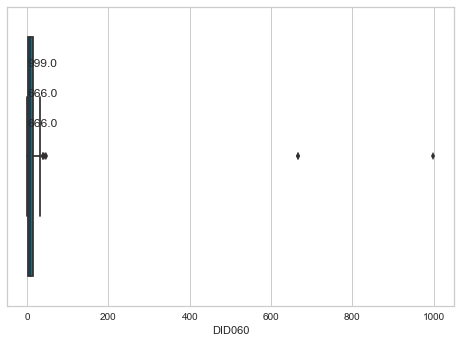

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


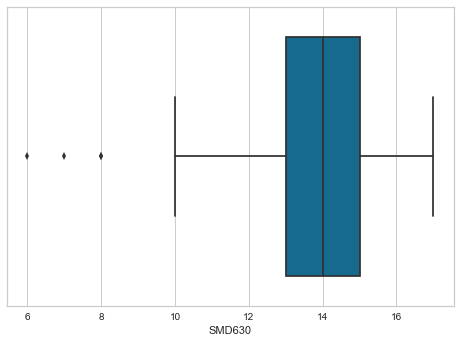

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


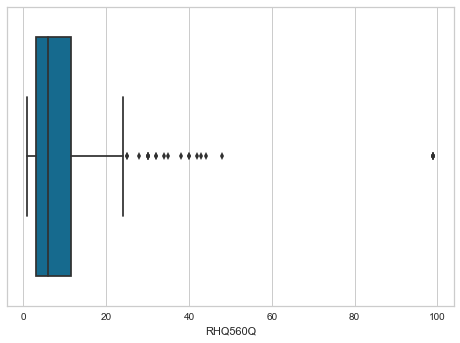

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


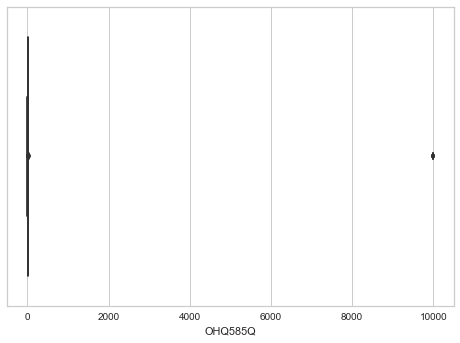

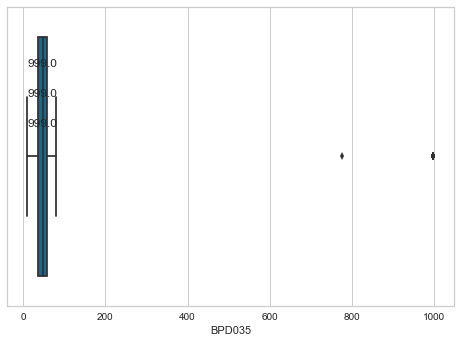

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


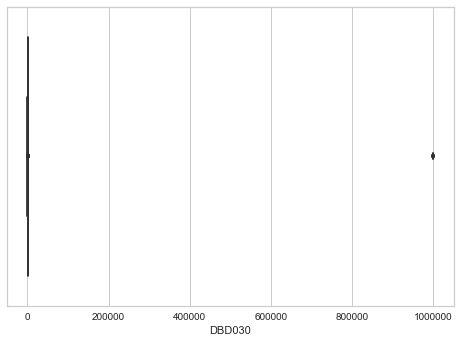

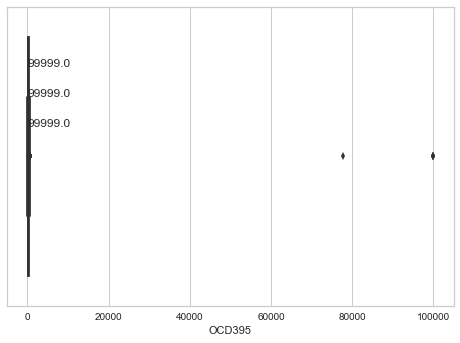

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


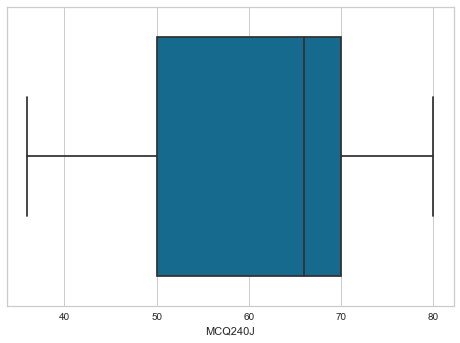

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


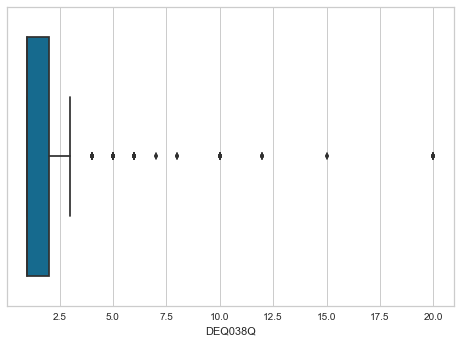

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


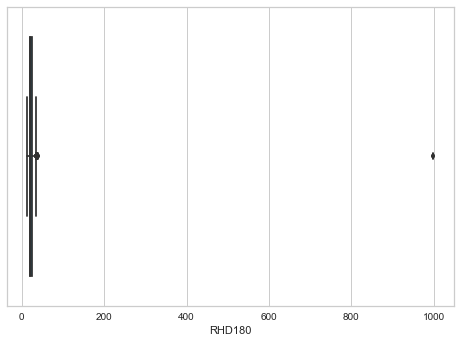

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


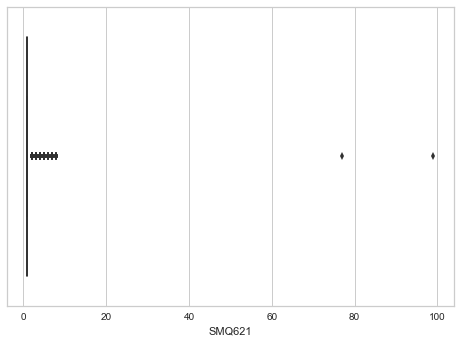

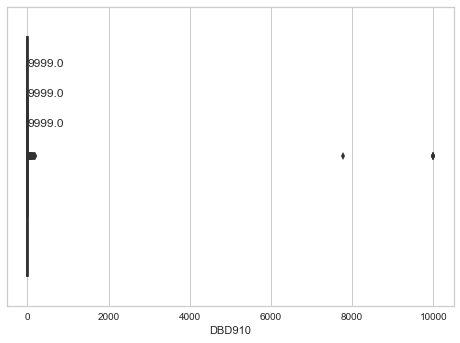

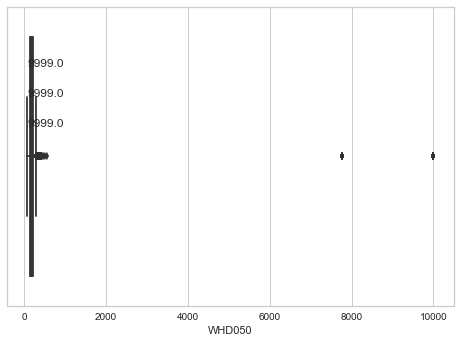

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


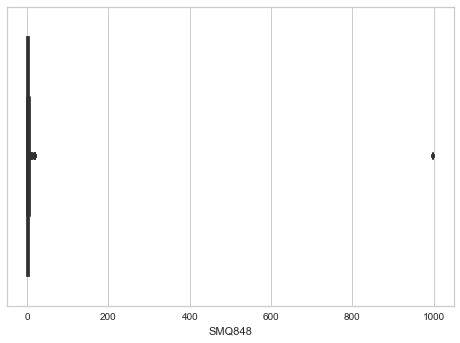

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


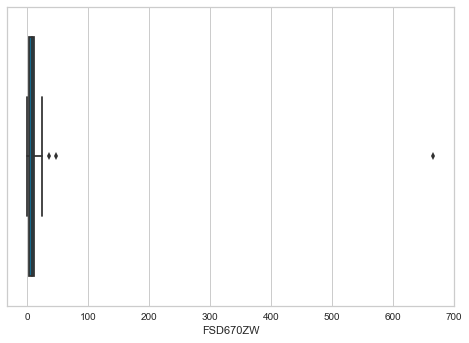

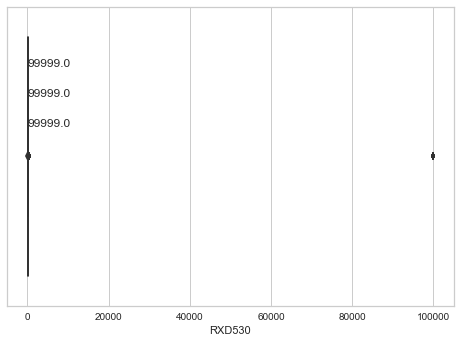

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


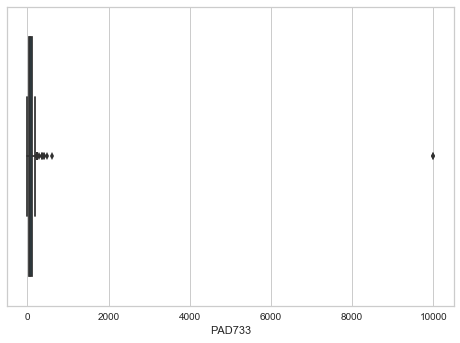

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


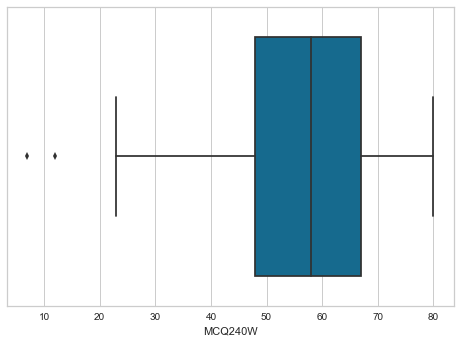

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


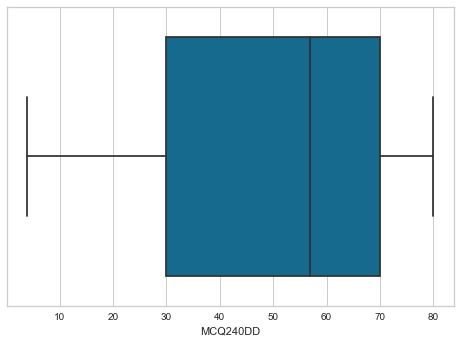

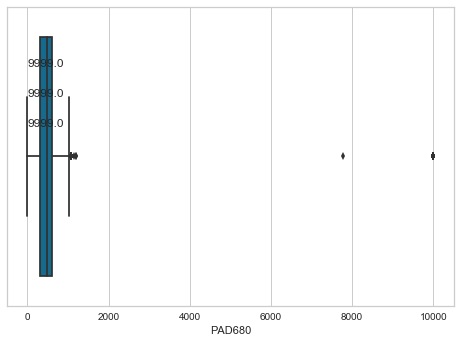

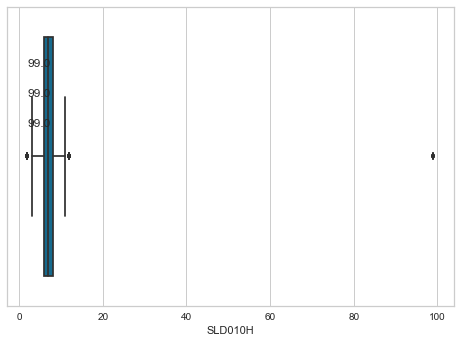

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


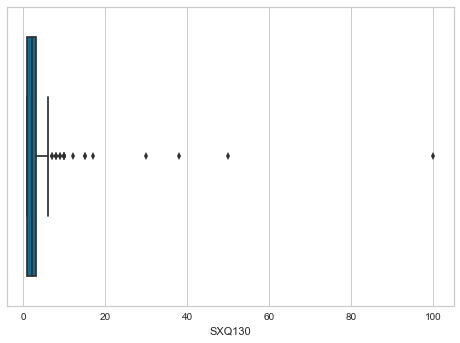

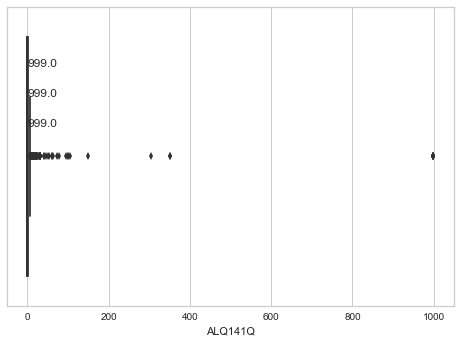

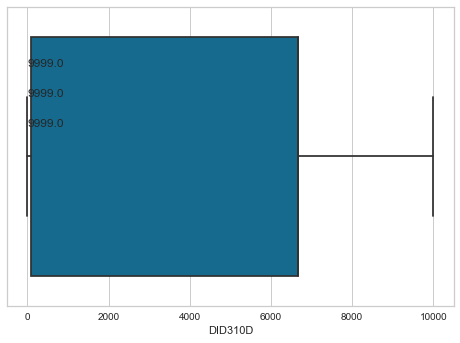

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


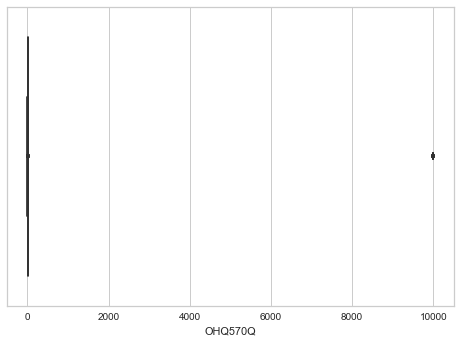

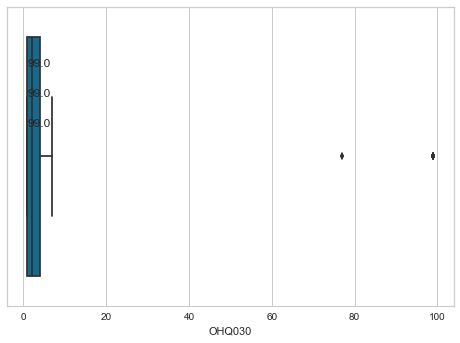

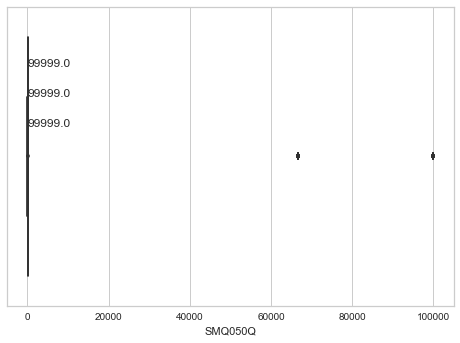

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


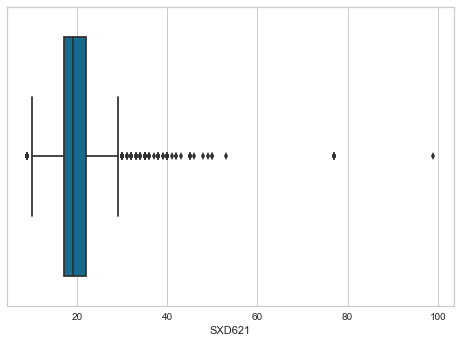

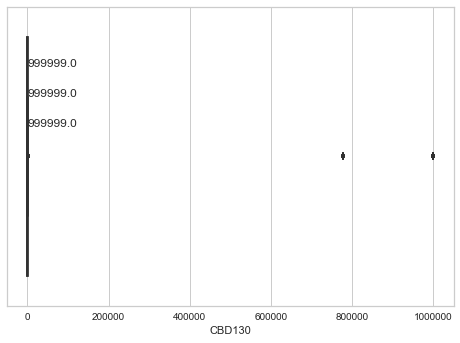

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


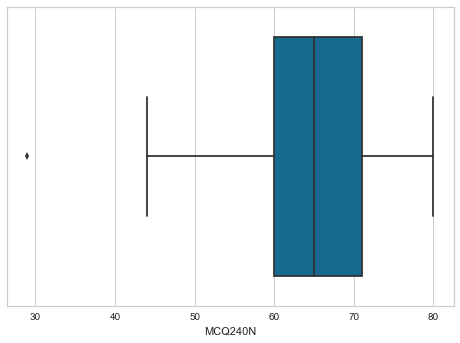

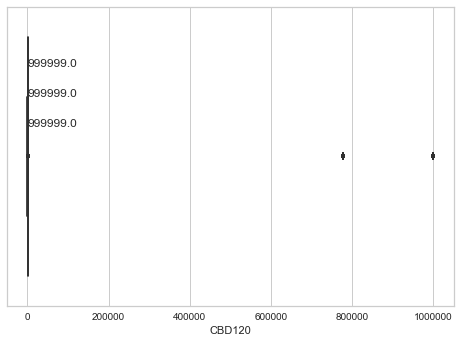

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


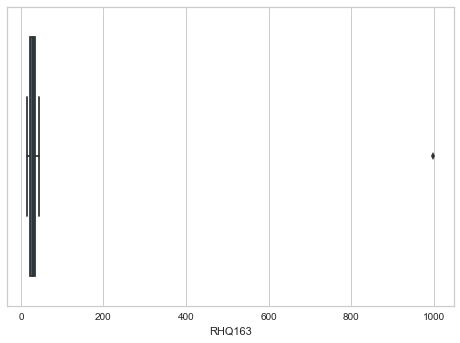

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


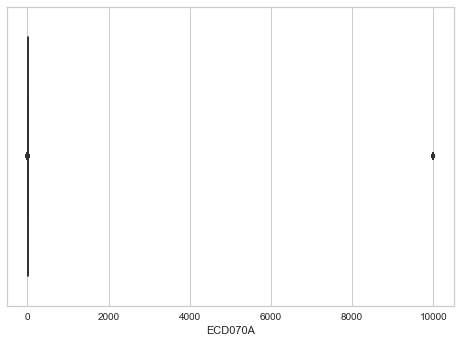

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


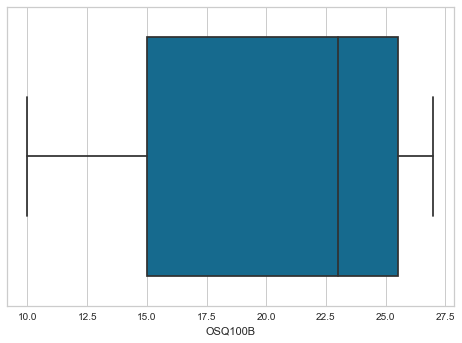

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


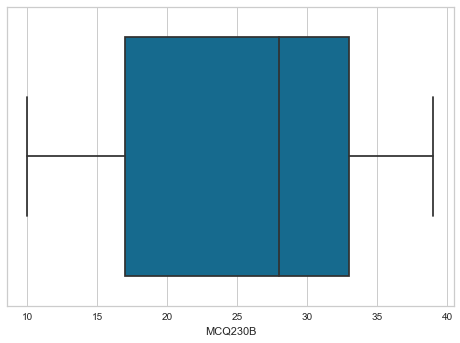

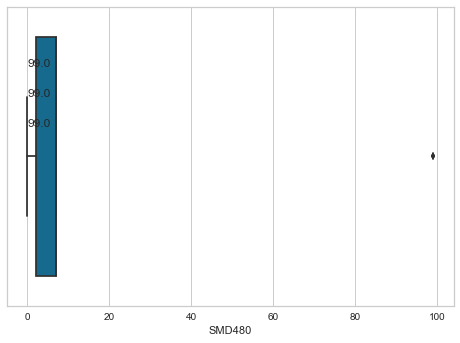

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


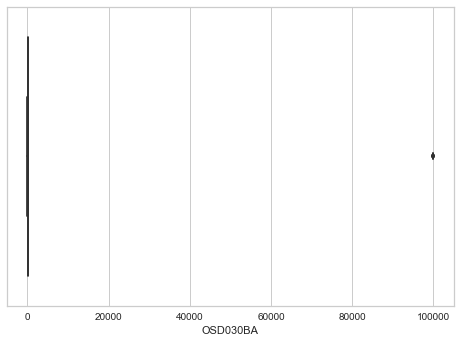

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


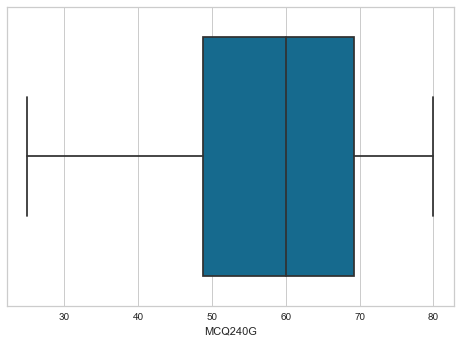

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


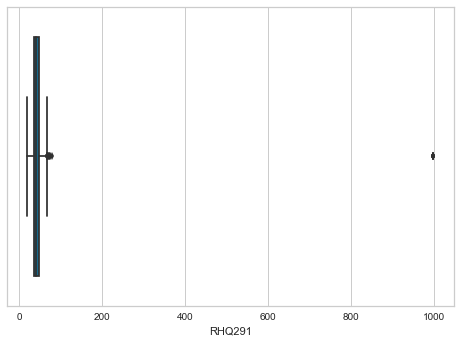

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


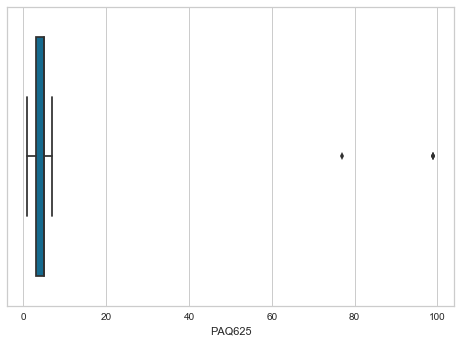

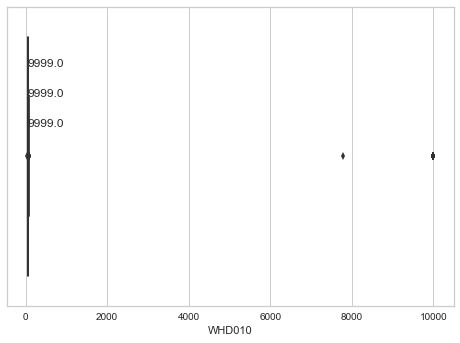

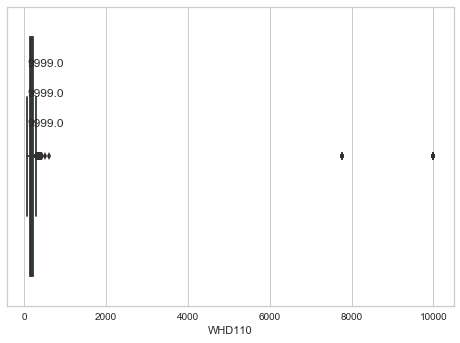

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


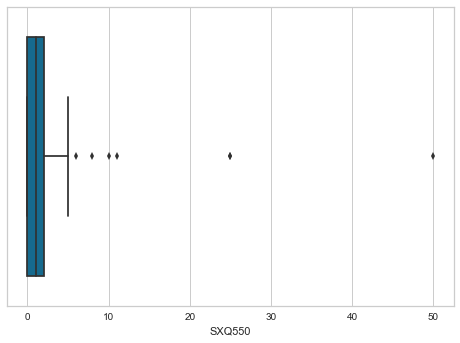

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


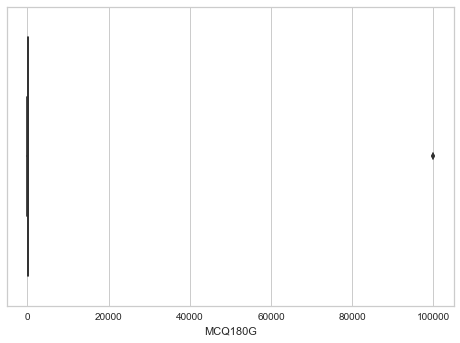

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


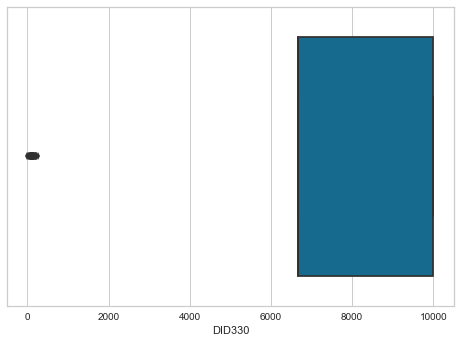

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


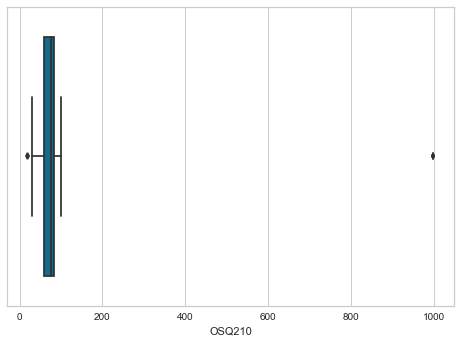

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


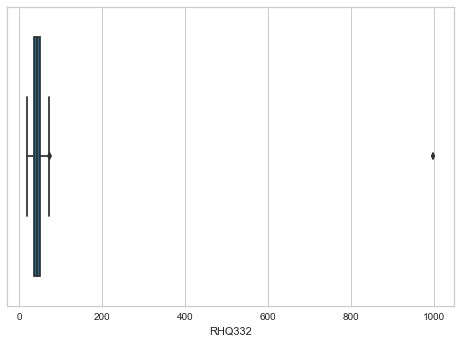

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


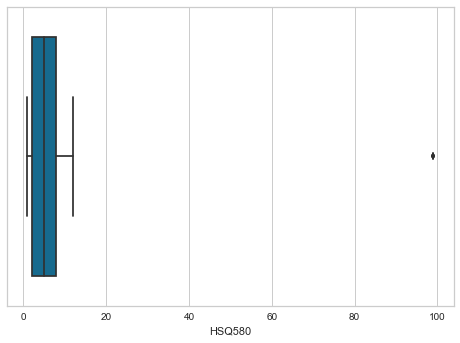

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


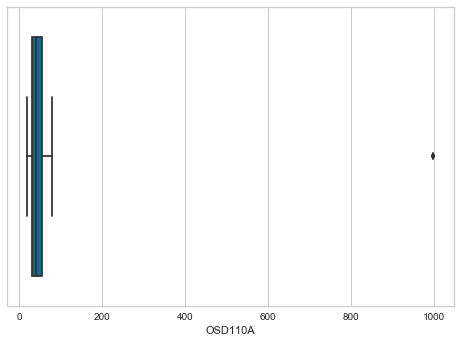

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


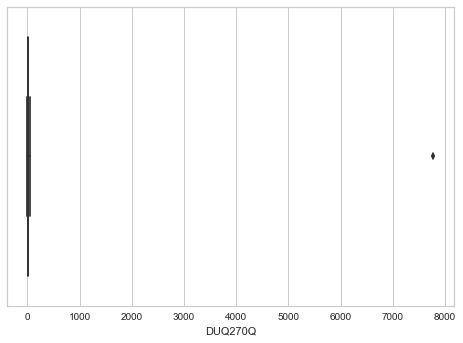

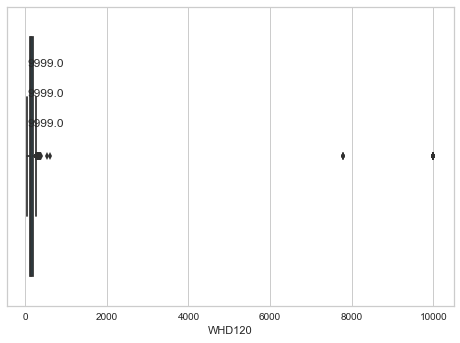

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


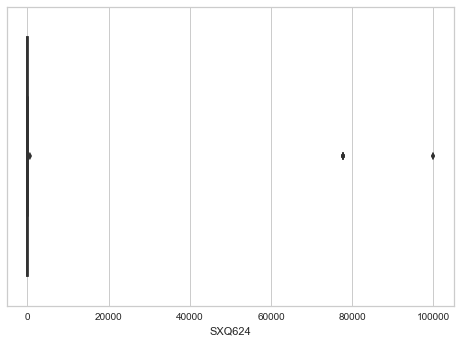

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


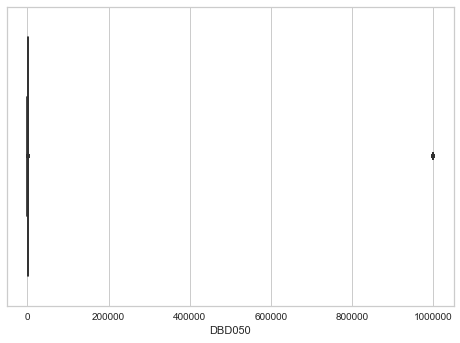

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


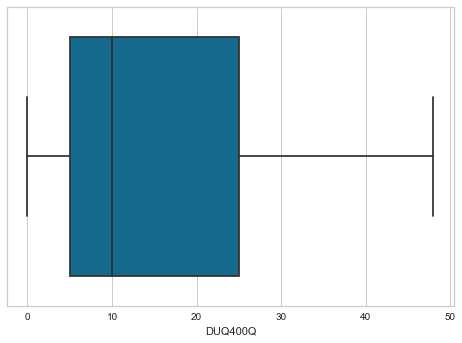

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


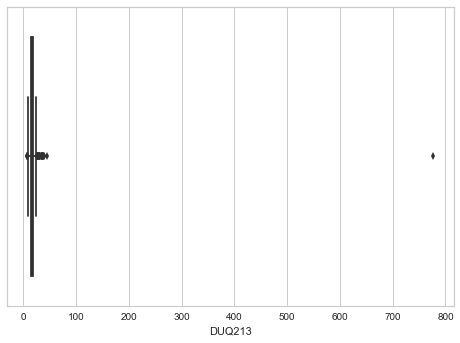

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


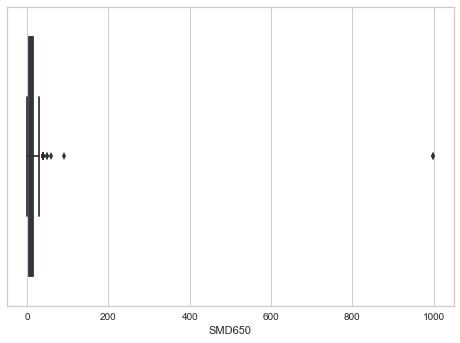

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


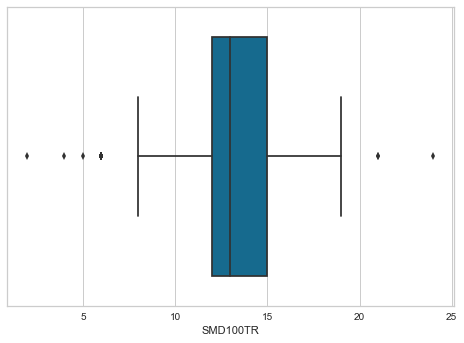

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


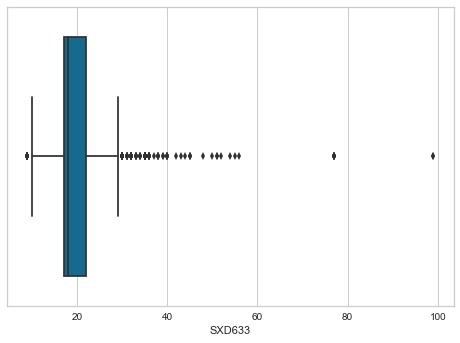

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


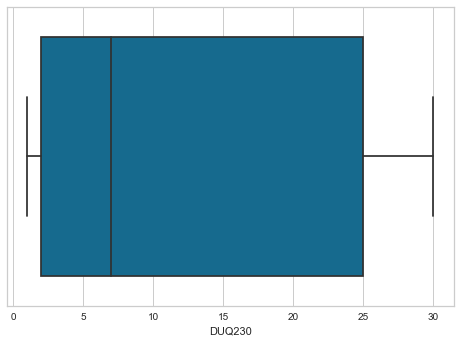

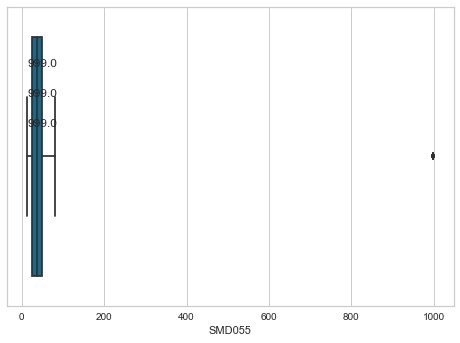

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


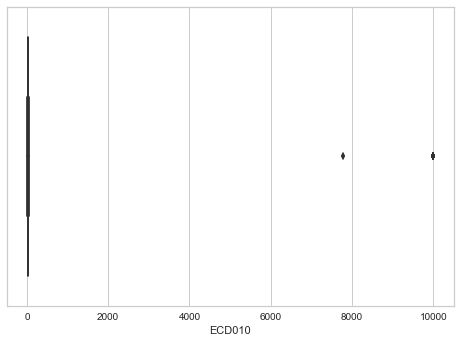

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


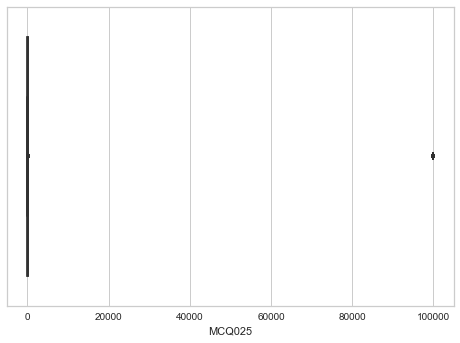

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


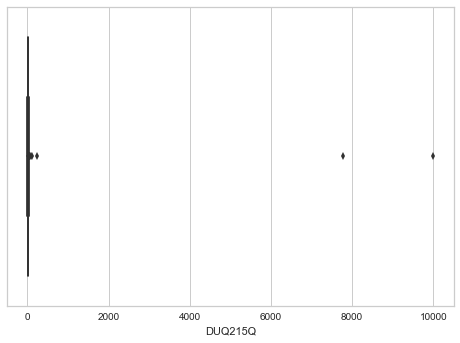

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


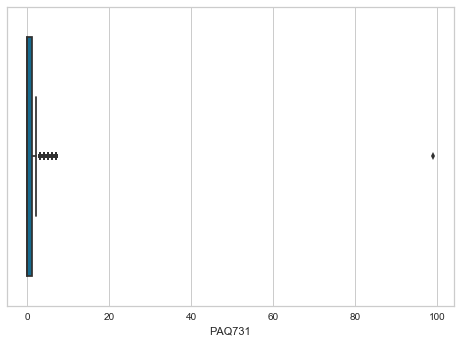

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


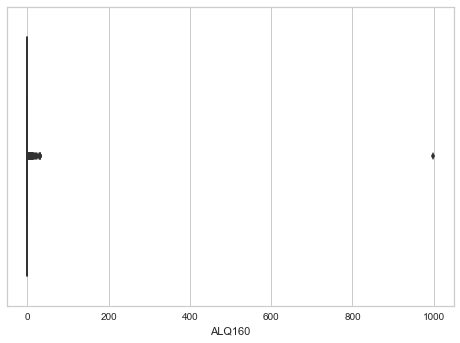

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


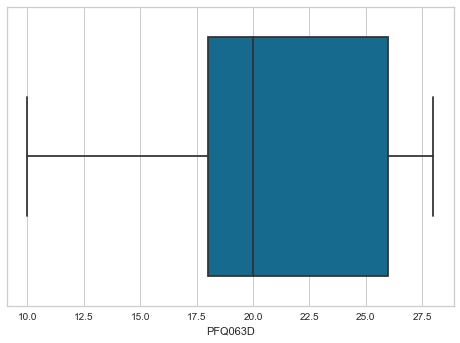

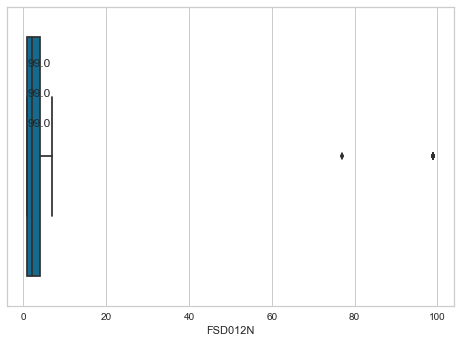

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


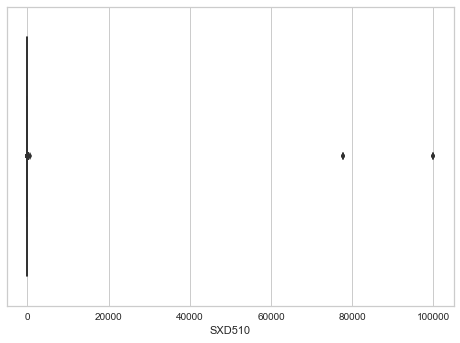

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


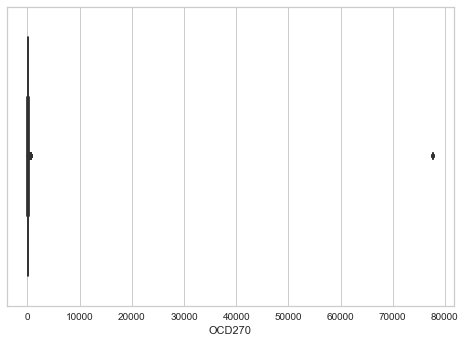

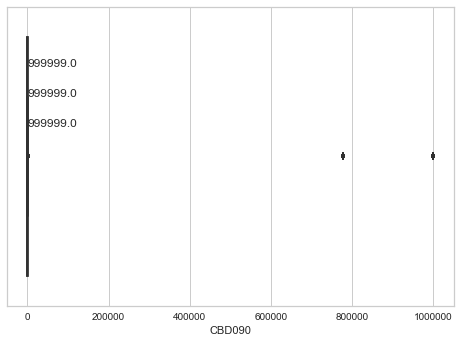

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


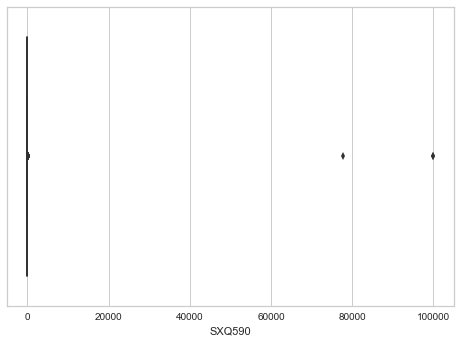

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


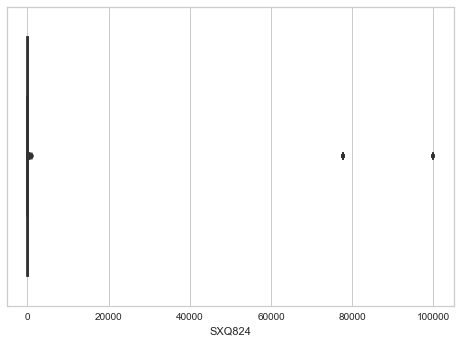

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


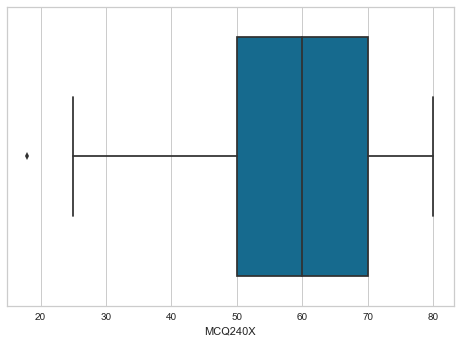

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


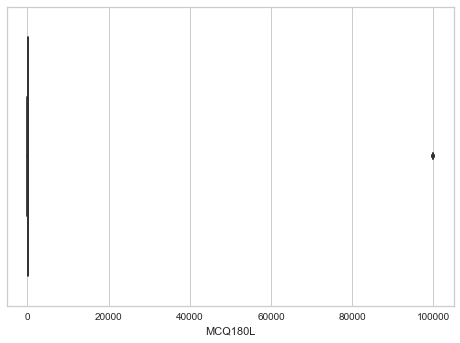

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


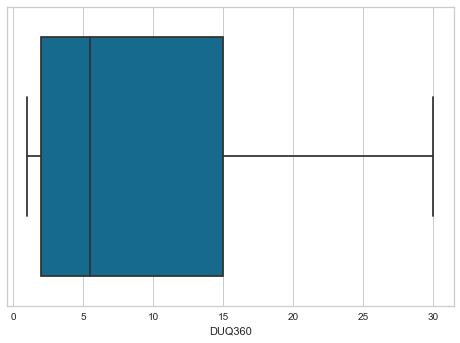

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


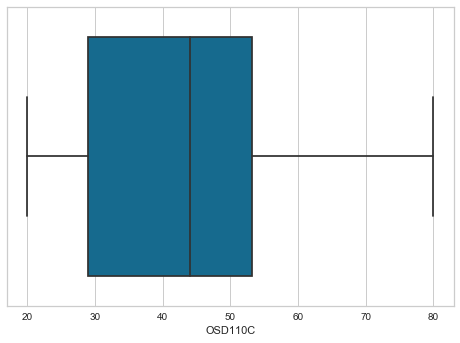

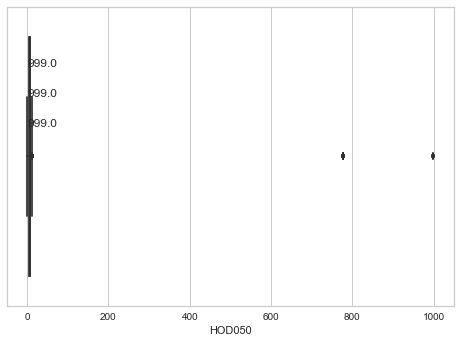

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


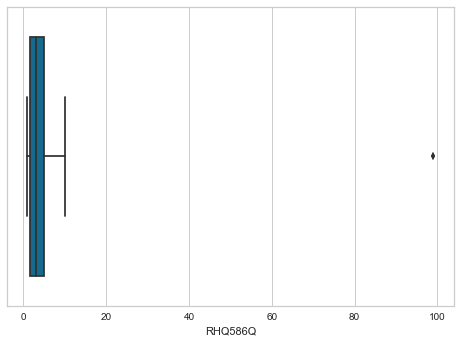

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


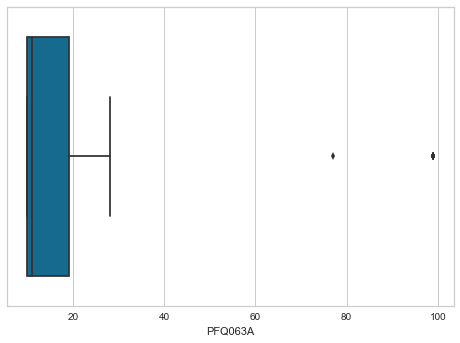

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


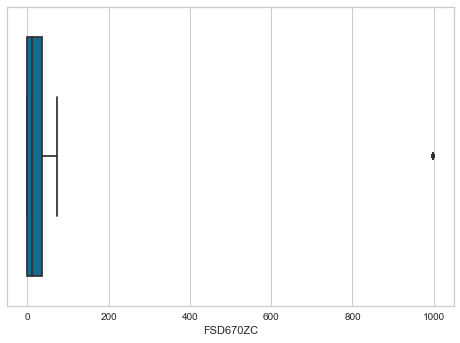

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


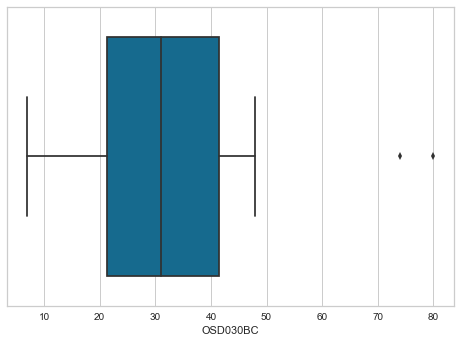

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


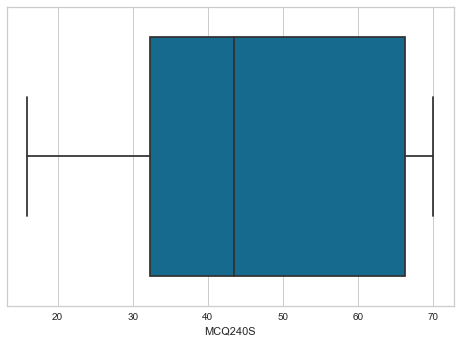

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


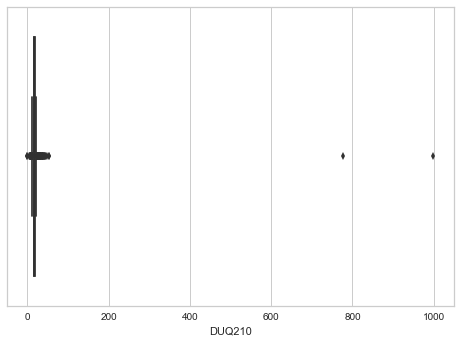

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


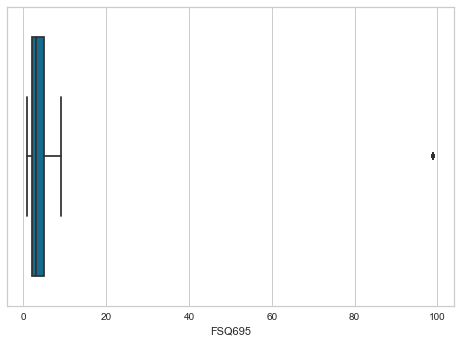

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


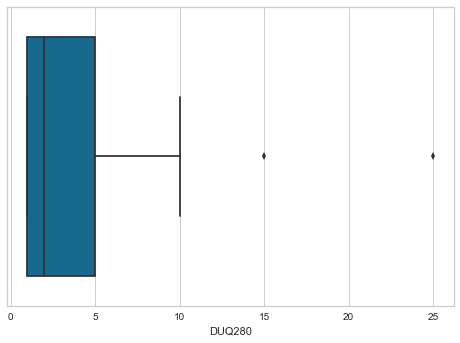

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


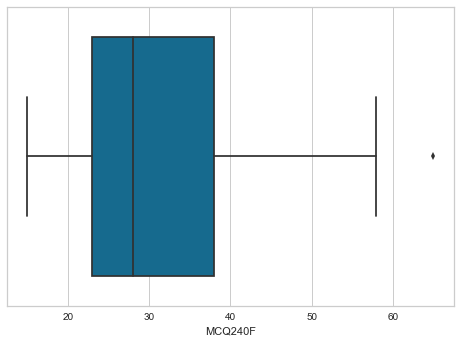

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


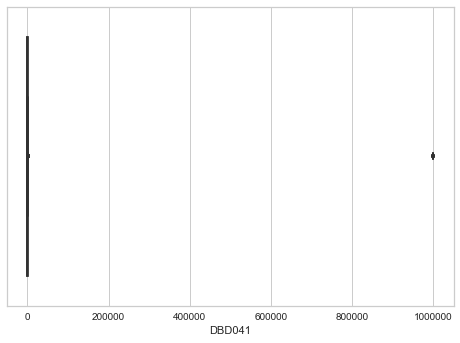

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


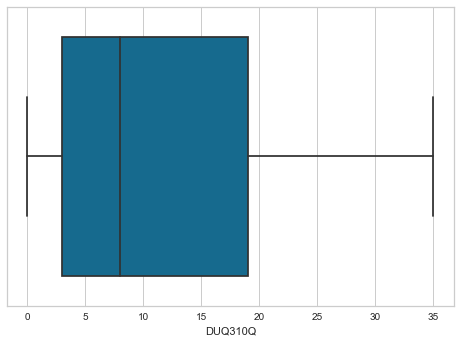

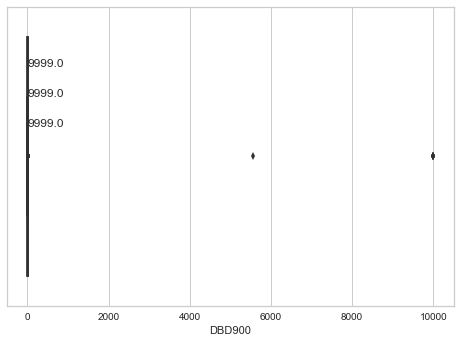

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


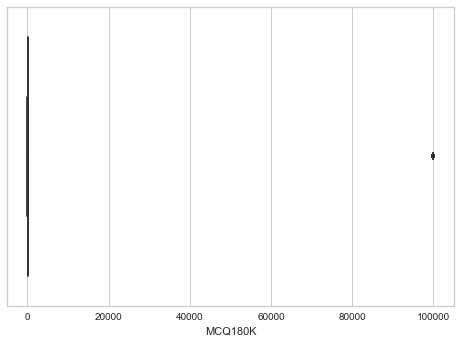

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


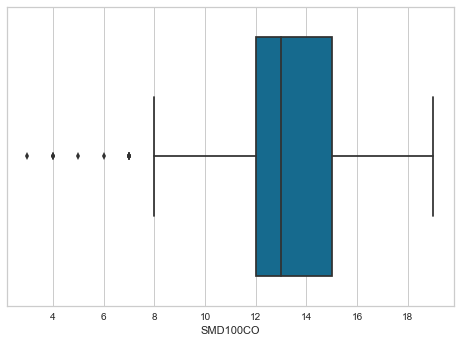

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


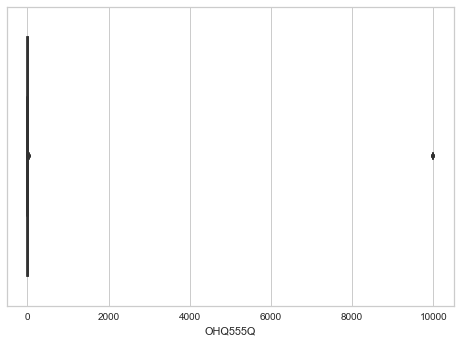

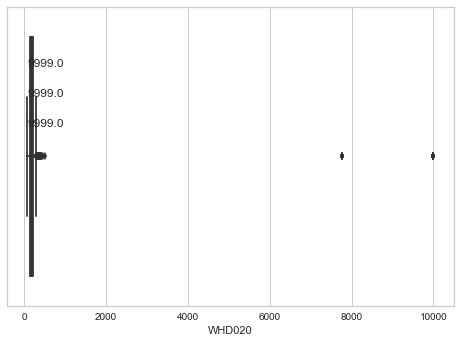

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


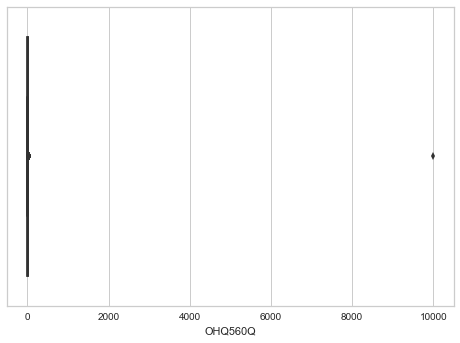

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


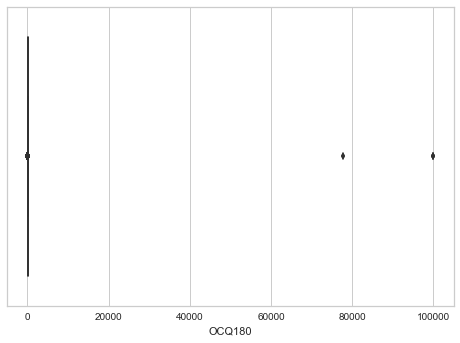

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


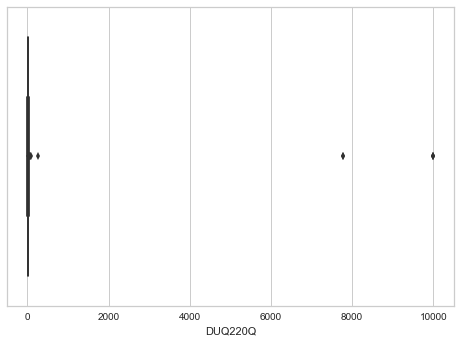

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


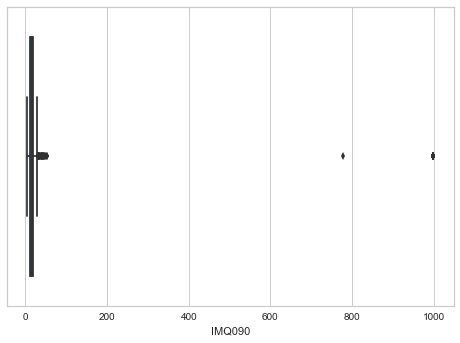

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


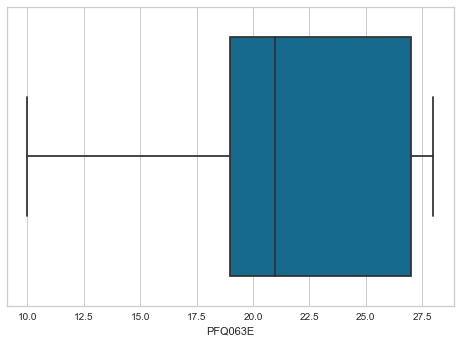

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


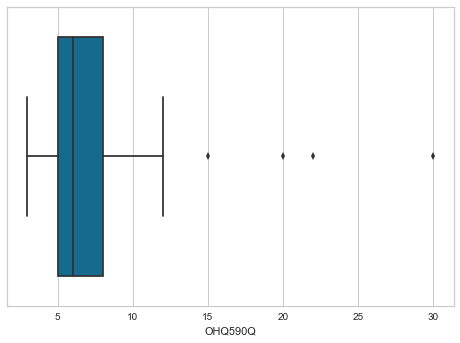

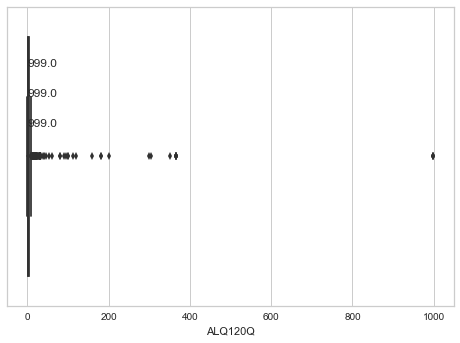

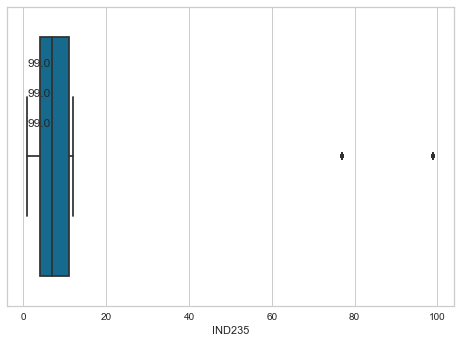

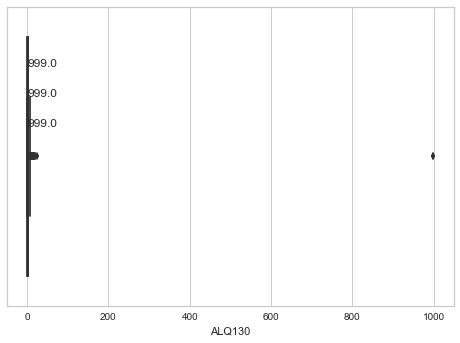

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


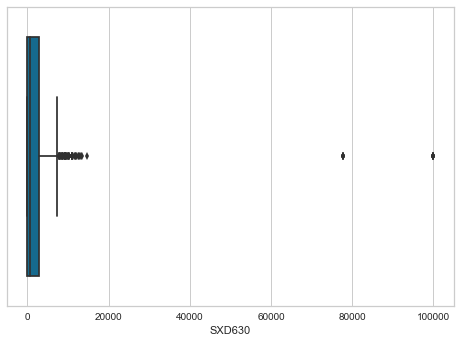

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


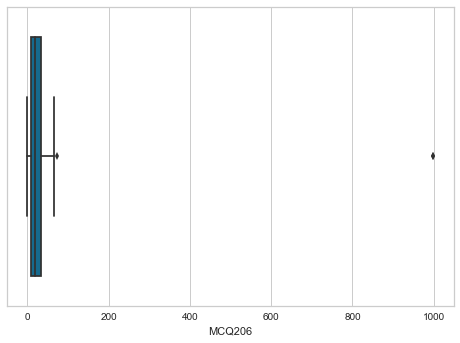

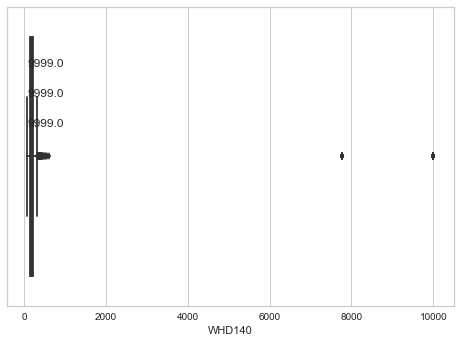

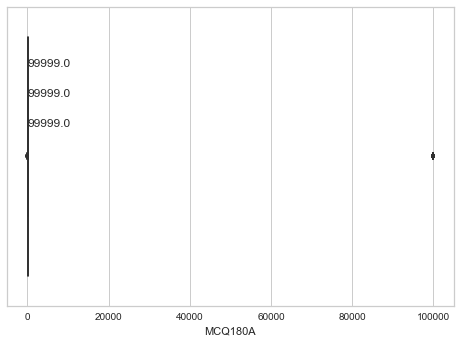

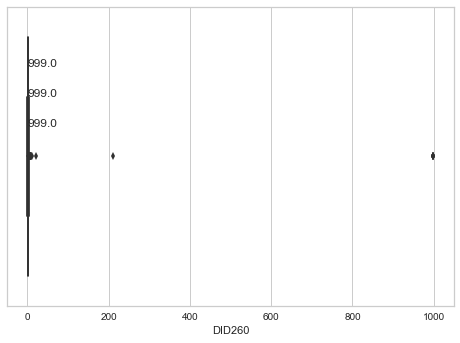

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


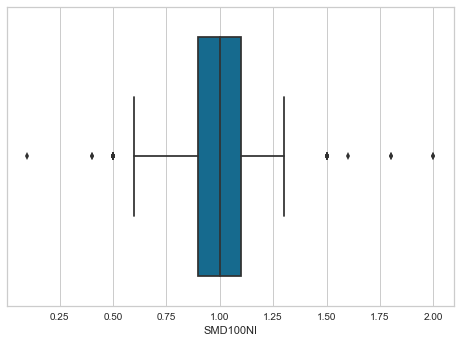

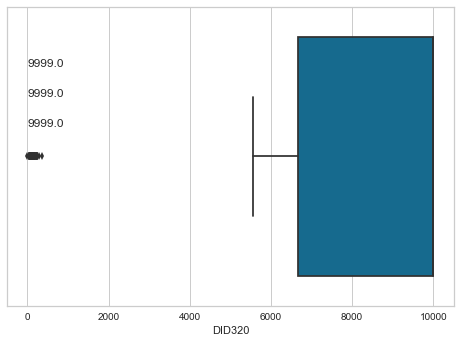

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


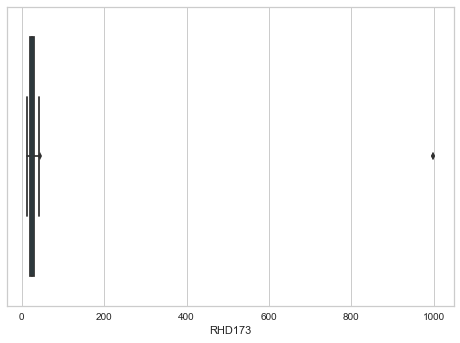

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


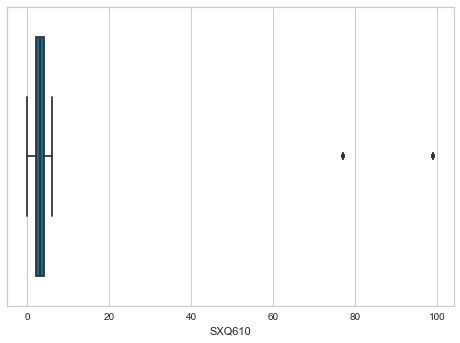

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


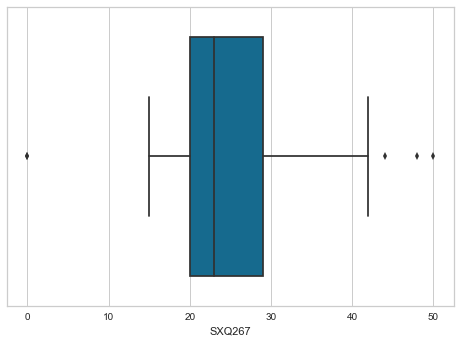

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


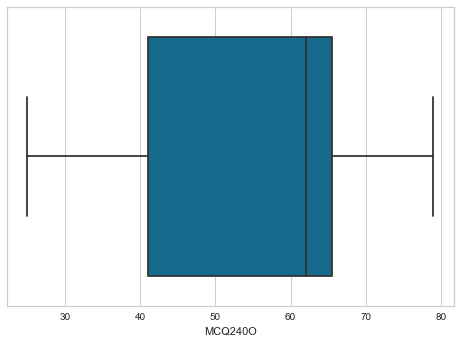

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


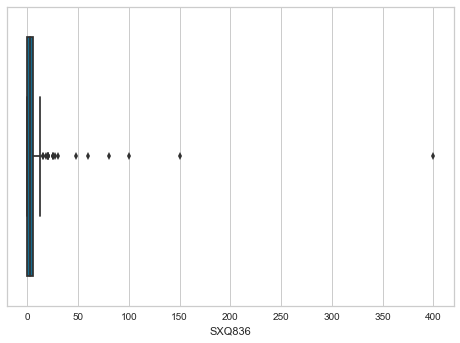

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


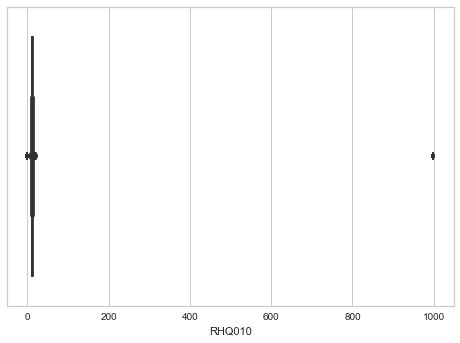

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


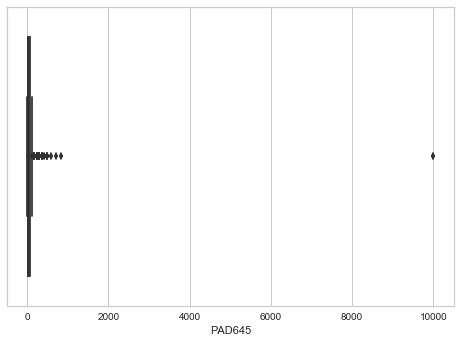

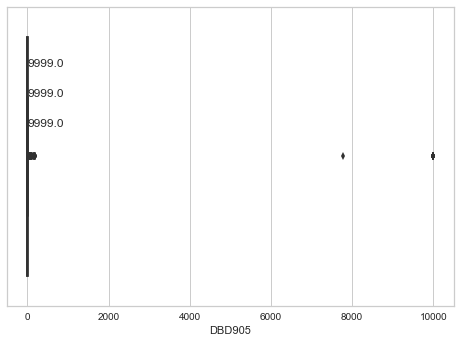

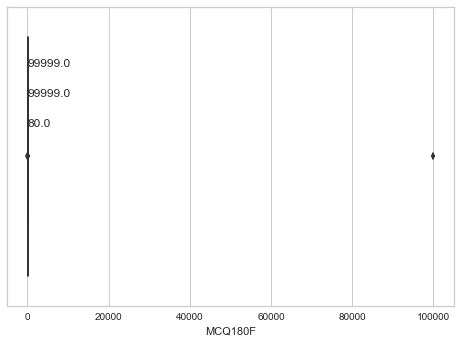

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


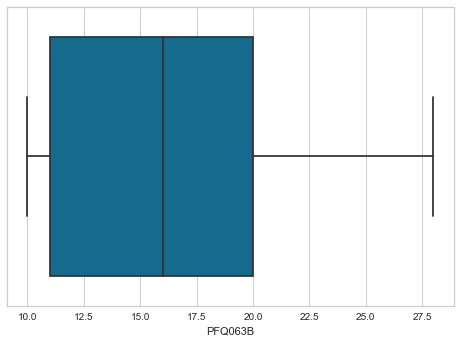

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


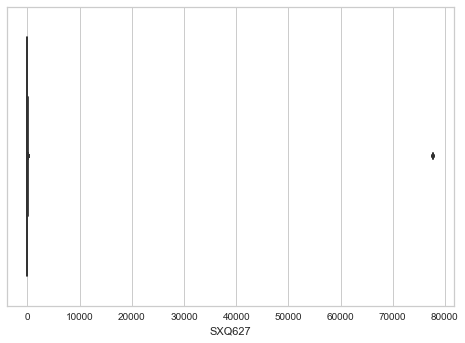

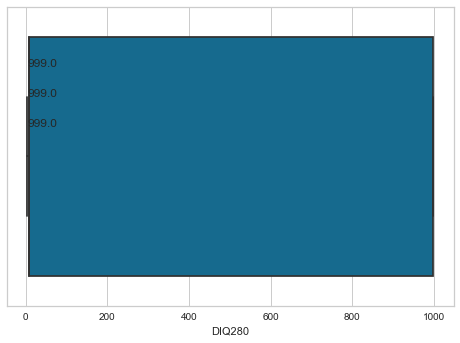

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


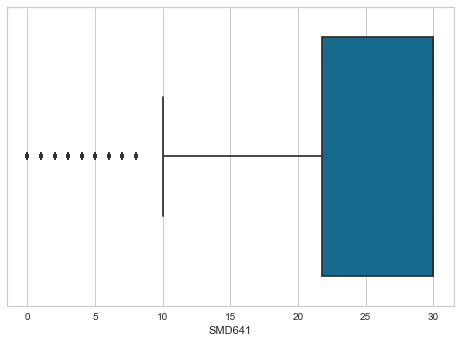

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


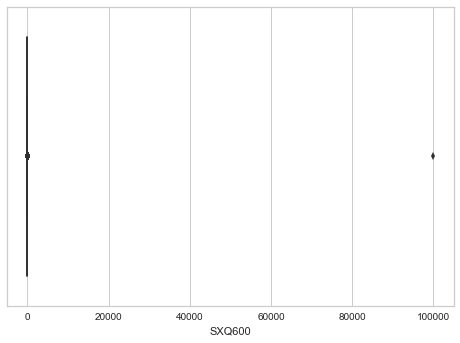

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


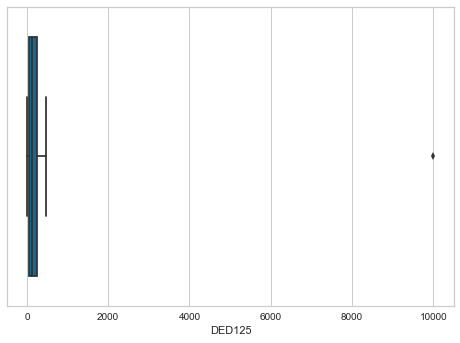

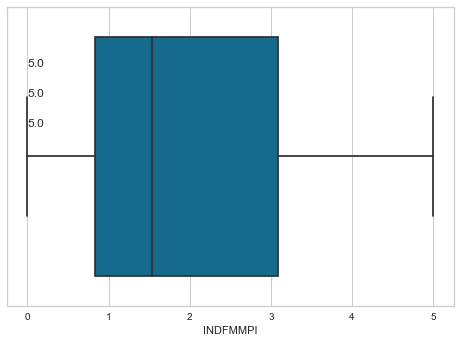

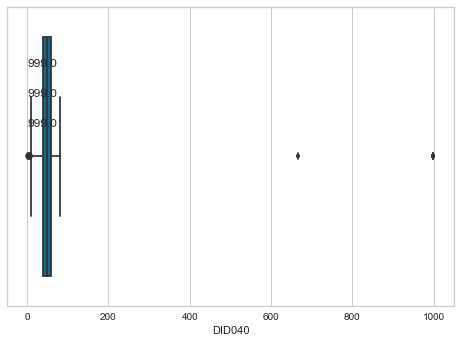

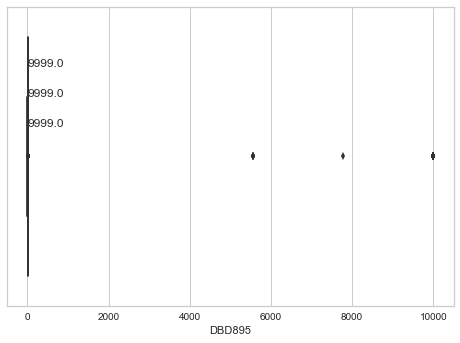

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


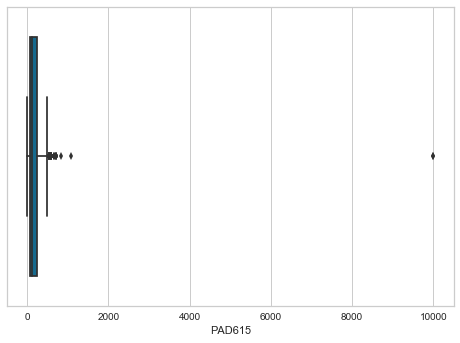

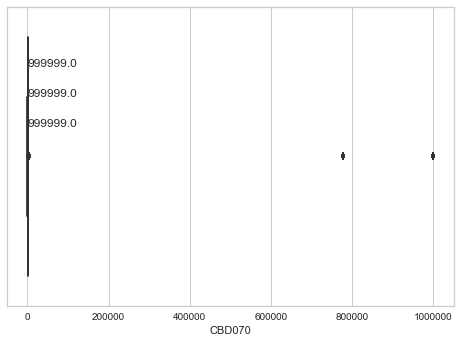

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


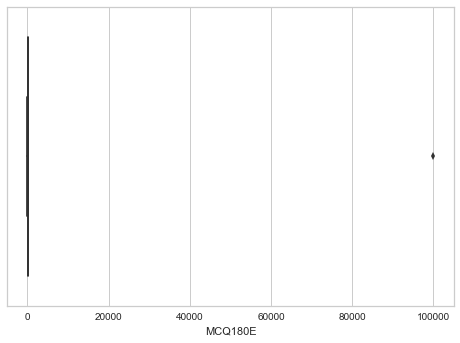

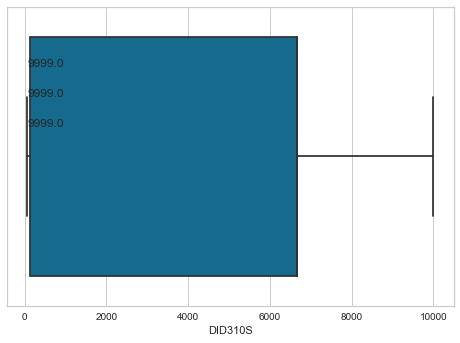

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


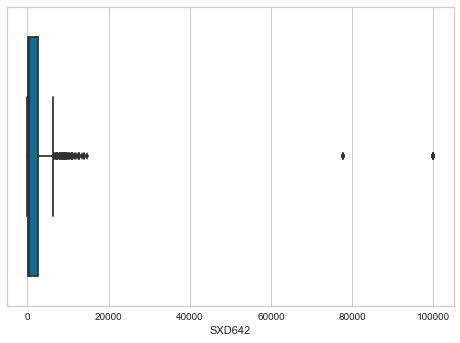

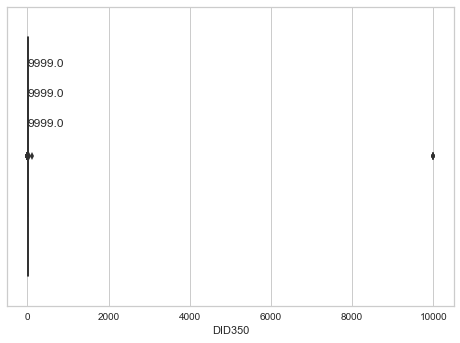

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


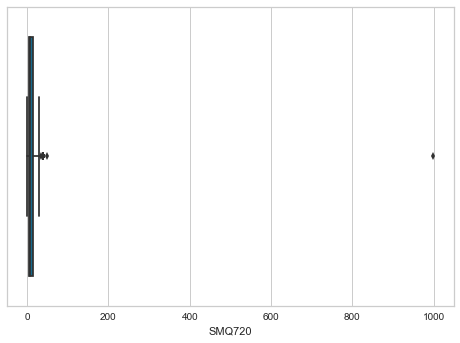

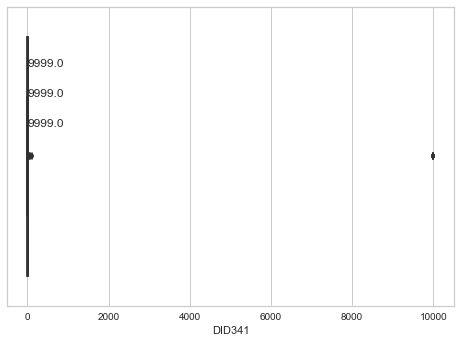

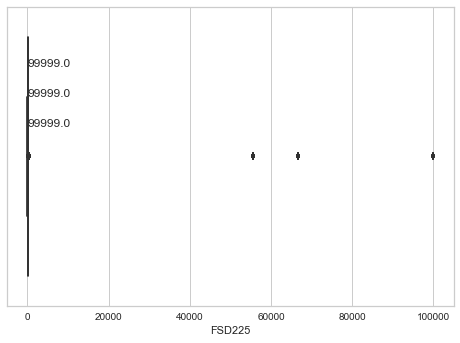

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


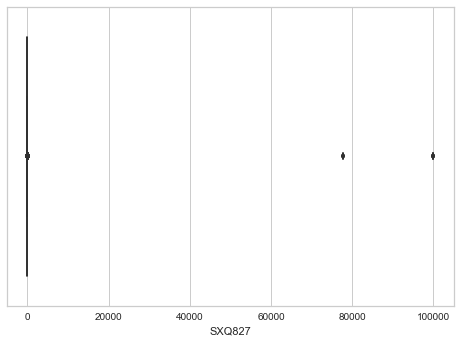

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


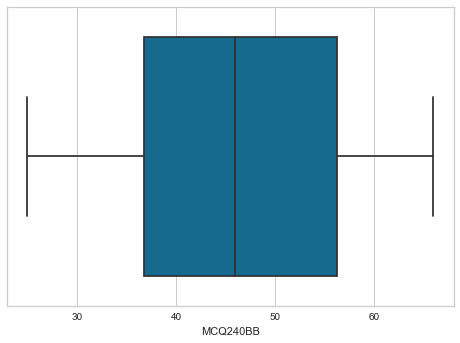

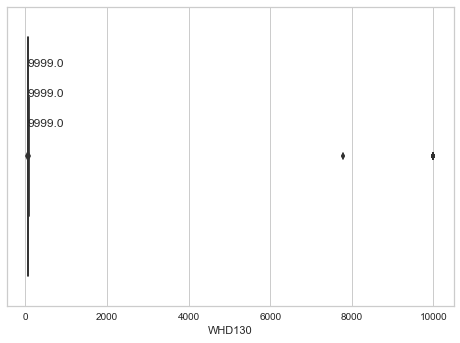

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


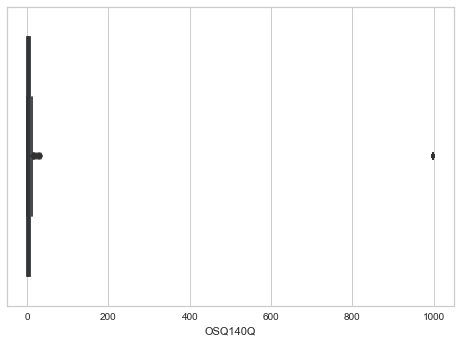

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


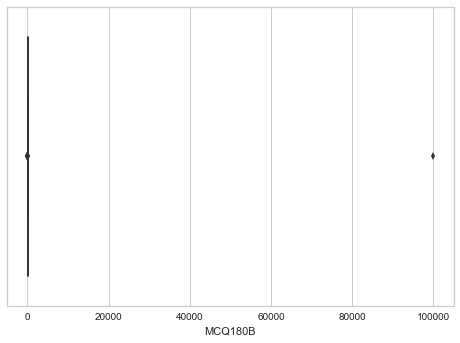

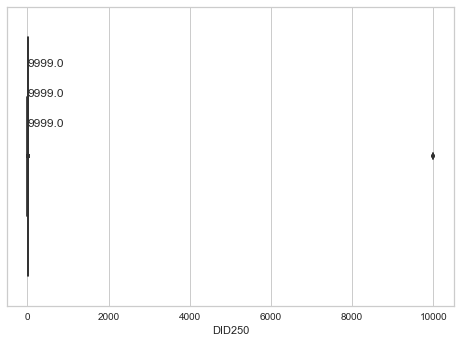

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


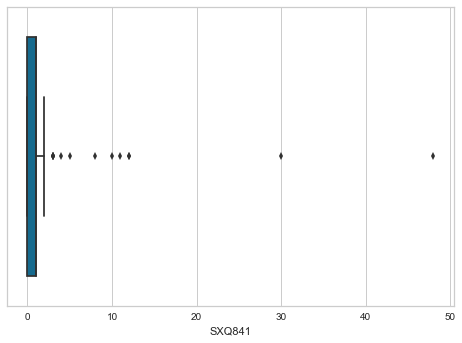

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


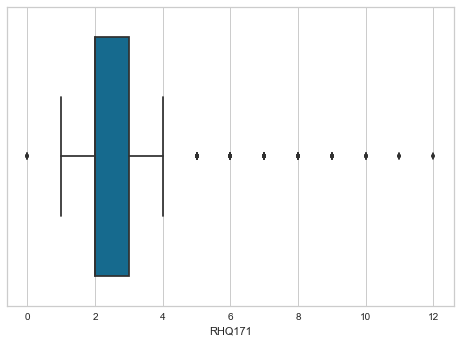

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


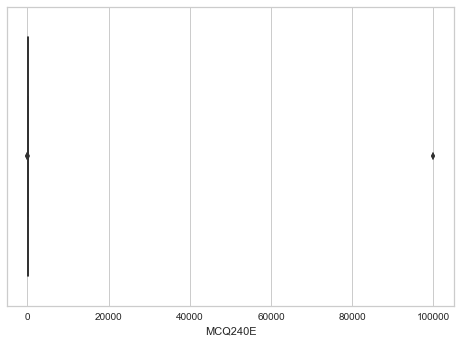

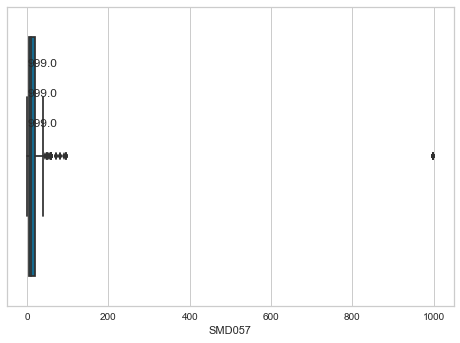

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


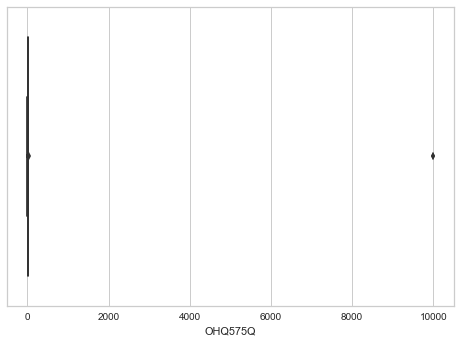

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


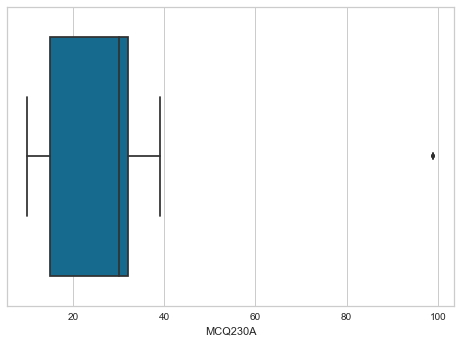

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


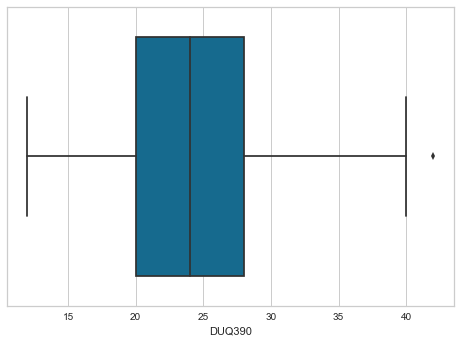

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


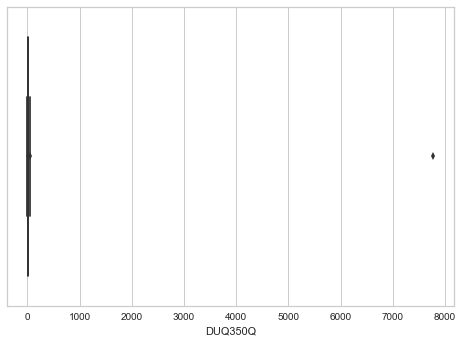

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


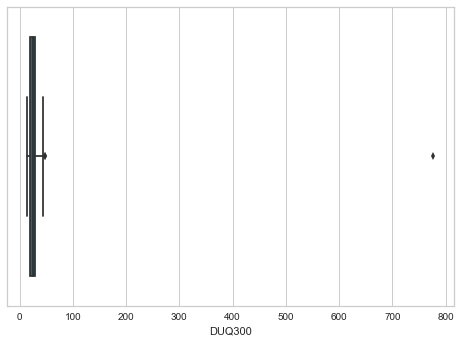

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


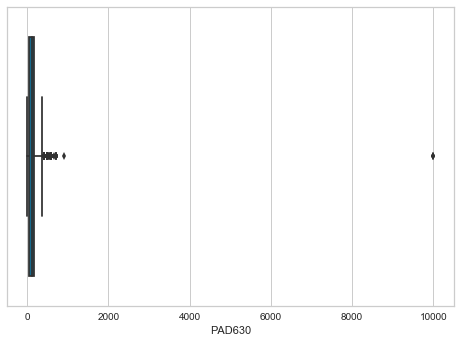

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


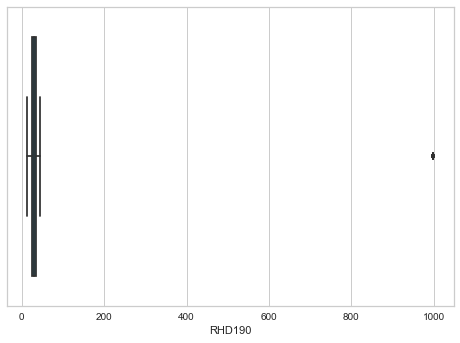

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


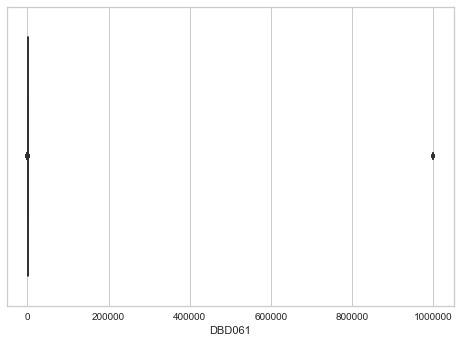

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


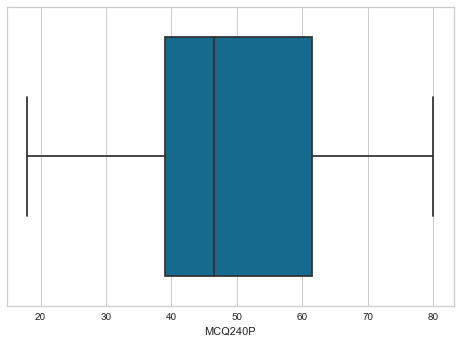

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


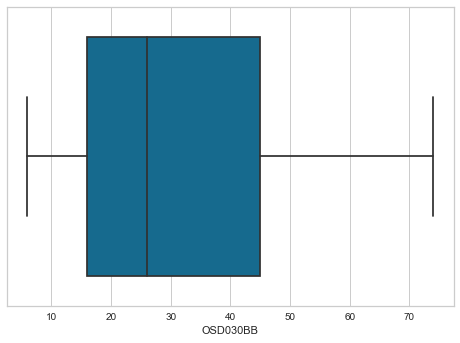

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


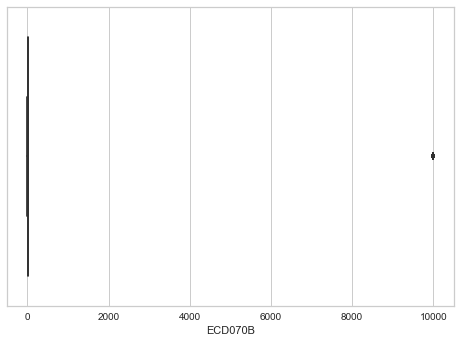

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


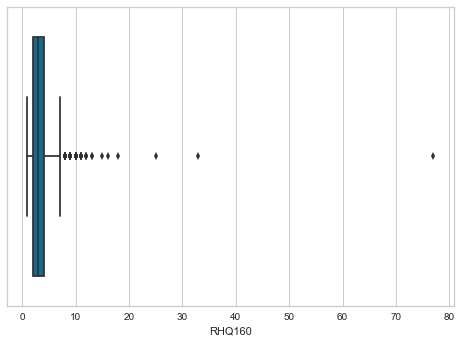

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


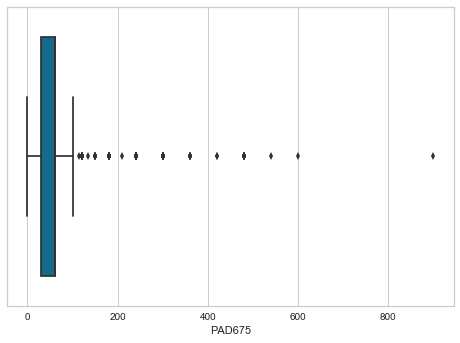

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


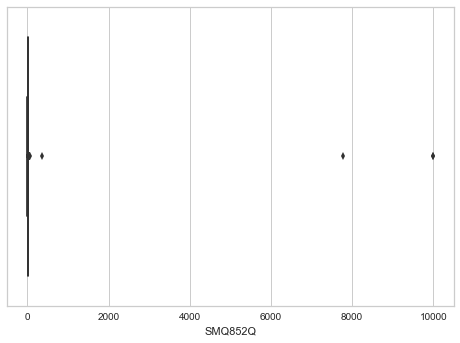

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


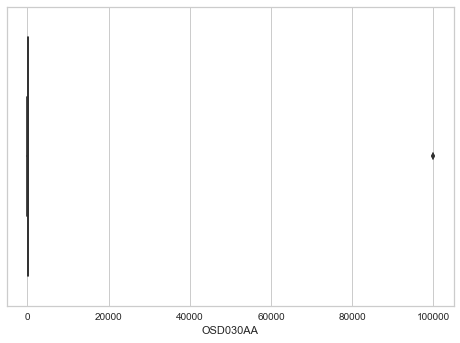

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


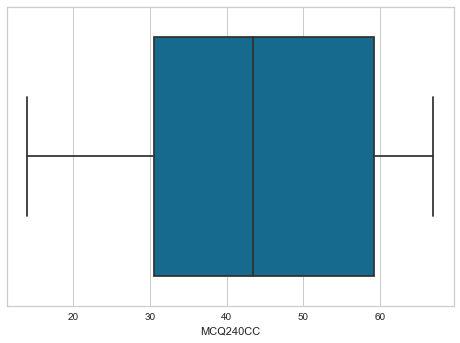

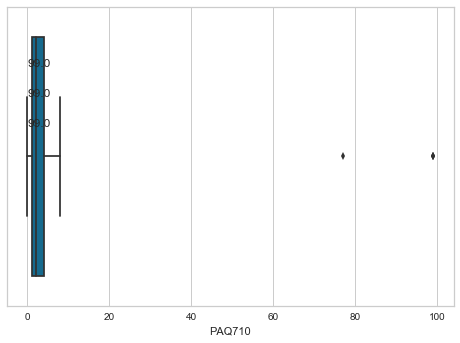

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


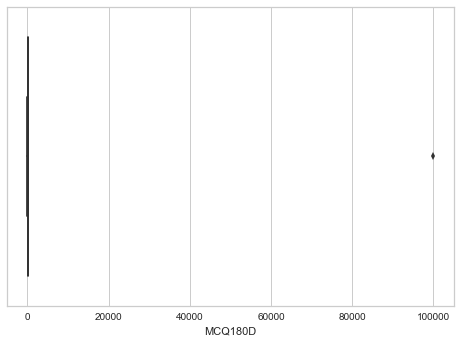

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


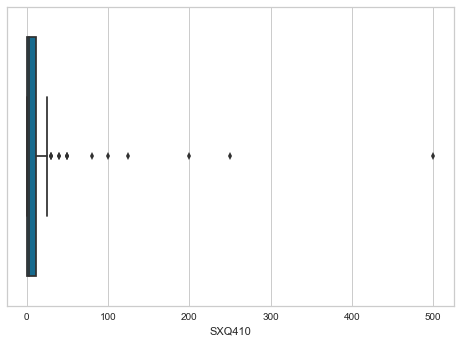

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


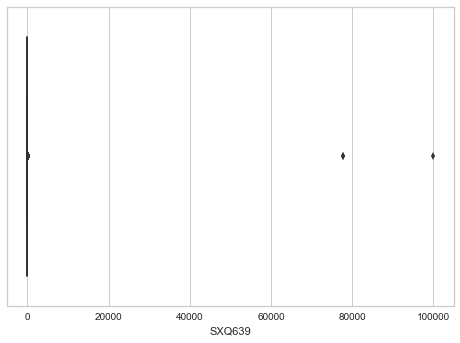

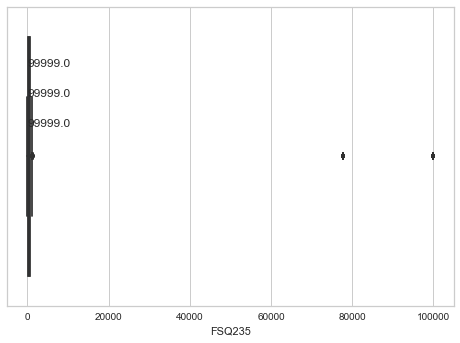

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


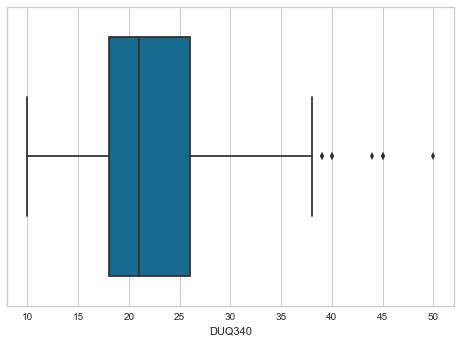

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


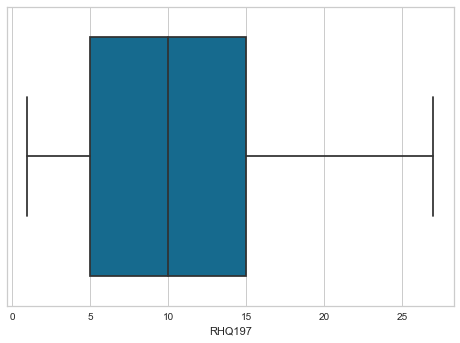

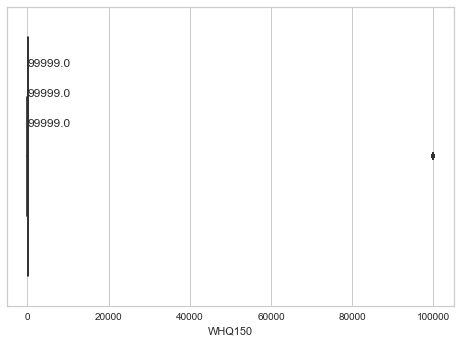

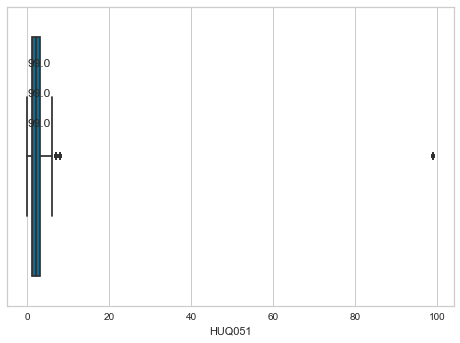

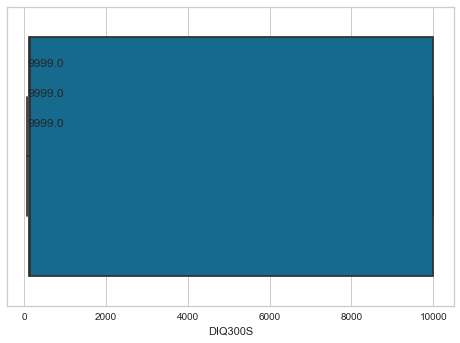

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


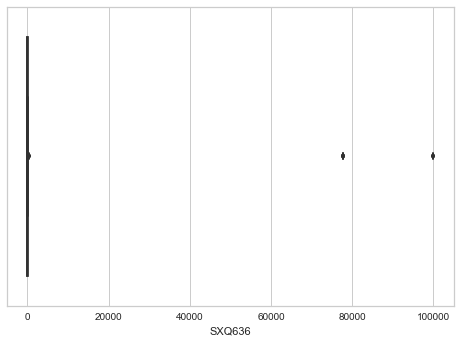

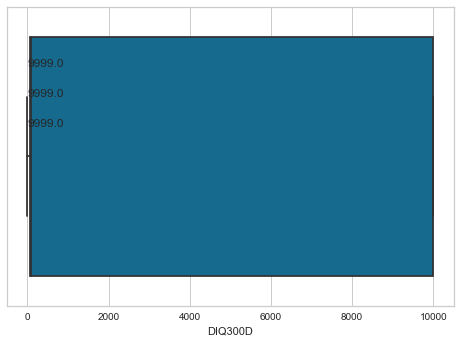

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


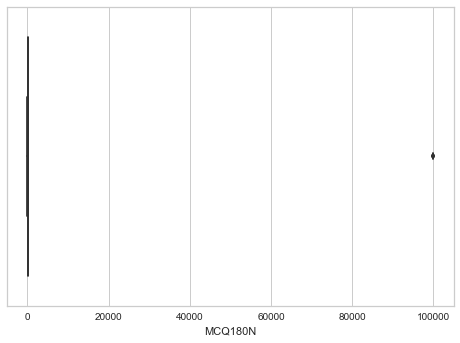

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


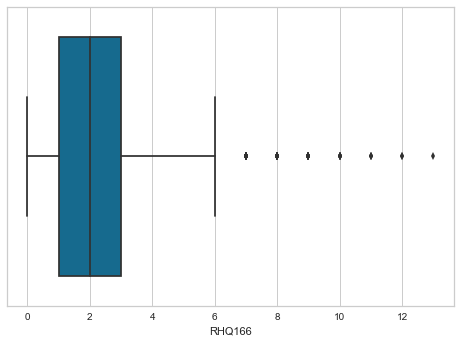

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


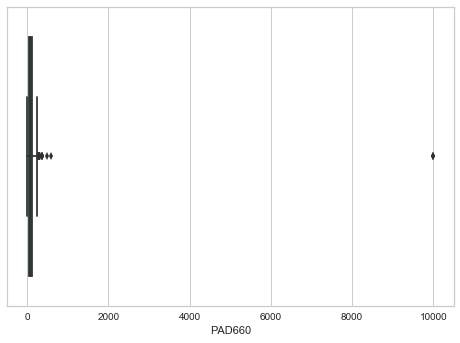

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


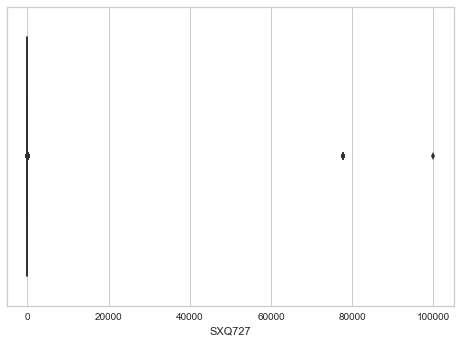

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


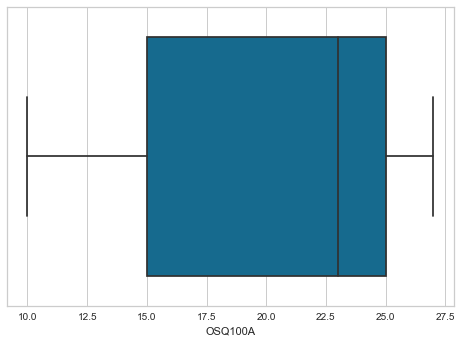

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


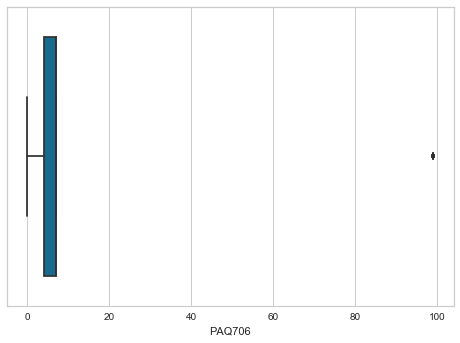

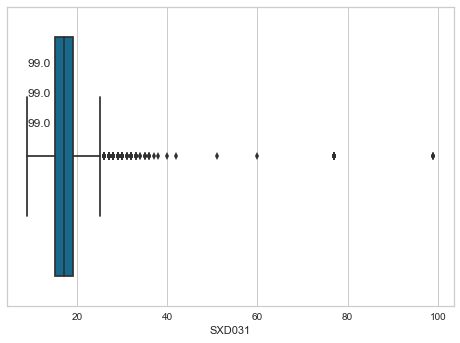

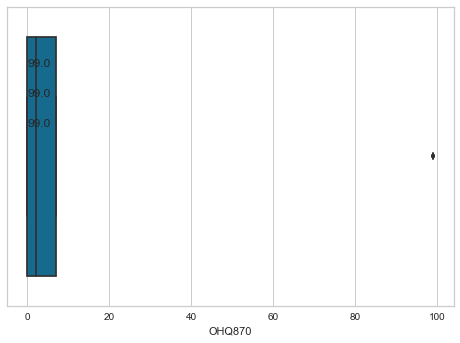

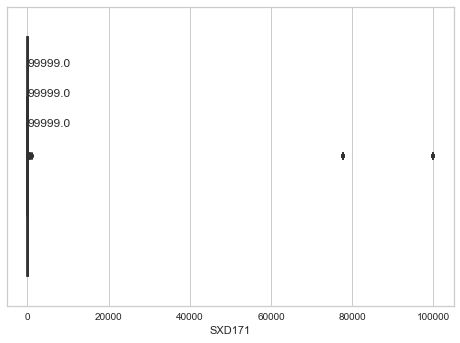

In [12]:
nhs_questionnaire = clean_float(nhs_questionnaire,list(set(ques_cont)^set(['SEQN'])))
visualize_float_columns(nhs_questionnaire,list(set(ques_cont)^set(['SEQN'])))

In [13]:
clean_cat(nhs_diet,diet_cat)
visualize_cat_columns(nhs_diet,diet_cat)

DBD100
[ 2.  1.  3.  9.]
1.0    5277
2.0    2864
3.0    1657
9.0      15
Name: DBD100, dtype: int64




In [14]:
nhs_diet = clean_float(nhs_diet,list(set(diet_cont)^set(['SEQN'])))
visualize_float_columns(nhs_diet,list(set(diet_cont)^set(['SEQN'])))

In [15]:
clean_cat(nhs_demographic,demo_cat)
visualize_cat_columns(nhs_demographic,demo_cat)

SDDSRVYR
[8]
8    10175
Name: SDDSRVYR, dtype: int64


RIDSTATR
[2 1]
2    9813
1     362
Name: RIDSTATR, dtype: int64


RIAGENDR
[1 2]
2    5172
1    5003
Name: RIAGENDR, dtype: int64


RIDRETH1
[4 3 1 2 5]
3    3674
4    2267
1    1730
5    1544
2     960
Name: RIDRETH1, dtype: int64


RIDRETH3
[4 3 1 2 7 6]
3    3674
4    2267
1    1730
6    1074
2     960
7     470
Name: RIDRETH3, dtype: int64


RIDEXMON
[ 1.  2.]
2.0    5182
1.0    4993
Name: RIDEXMON, dtype: int64


DMQMILIZ
[ 1.  2.  7.]
2.0    9312
1.0     862
7.0       1
Name: DMQMILIZ, dtype: int64


DMQADFC
[ 1.  2.  9.]
1.0    5370
2.0    4798
9.0       7
Name: DMQADFC, dtype: int64


DMDBORN4
[ 1  2 77 99]
1     8262
2     1908
77       4
99       1
Name: DMDBORN4, dtype: int64


DMDCITZN
[ 1.  2.  7.  9.]
1.0    9224
2.0     944
7.0       4
9.0       3
Name: DMDCITZN, dtype: int64


DMDEDUC2
[ 3.  4.  5.  2.  1.  9.  7.]
4.0    3105
5.0    2568
3.0    2365
2.0    1359
1.0     770
9.0       5
7.0       3
Name: DMDEDUC2, dt

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


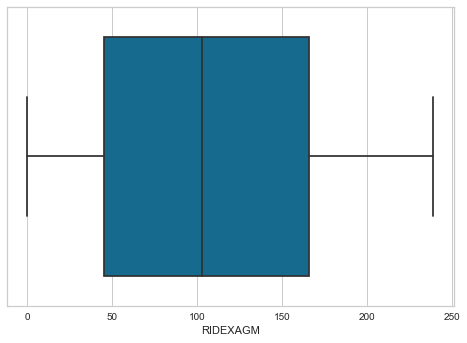

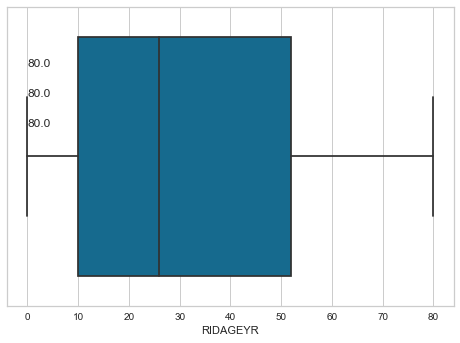

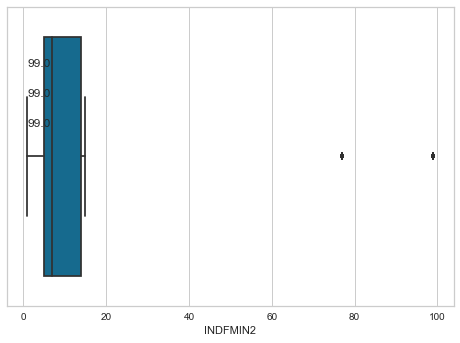

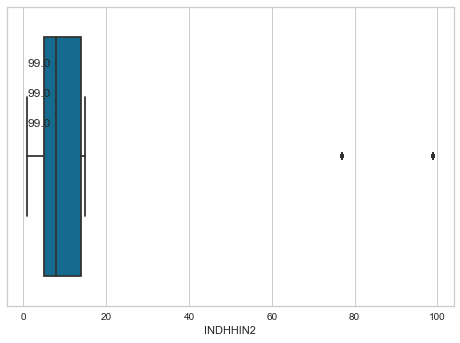

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


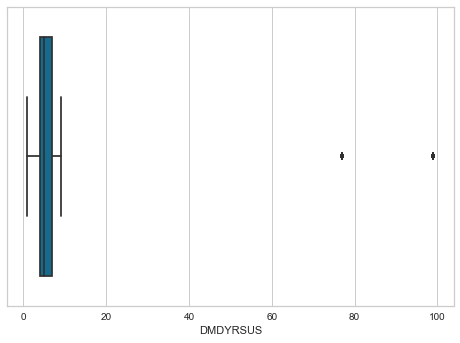

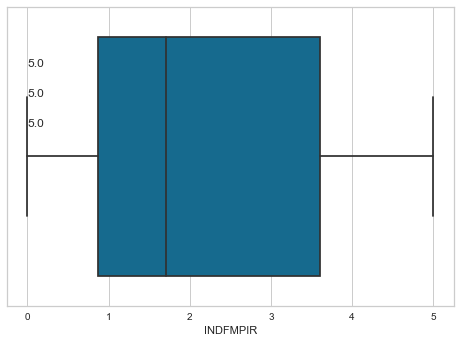

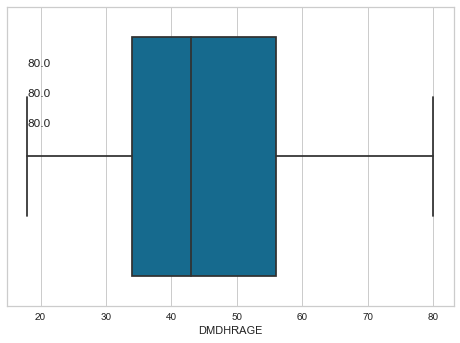

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


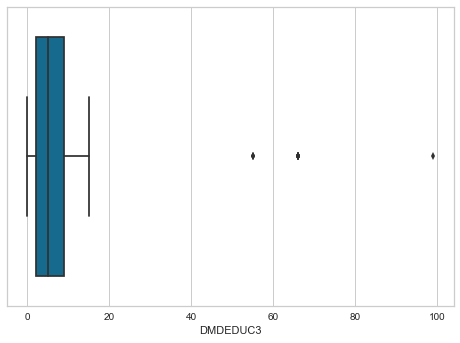

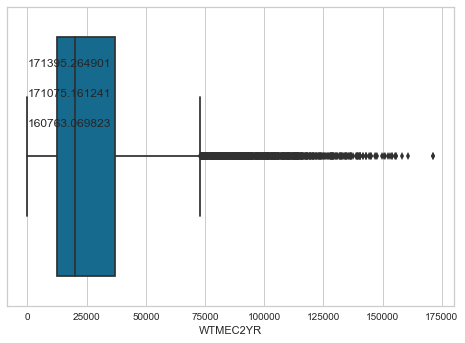

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


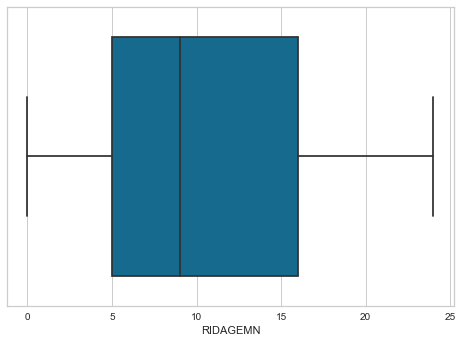

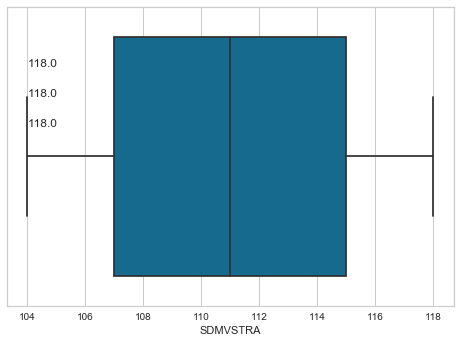

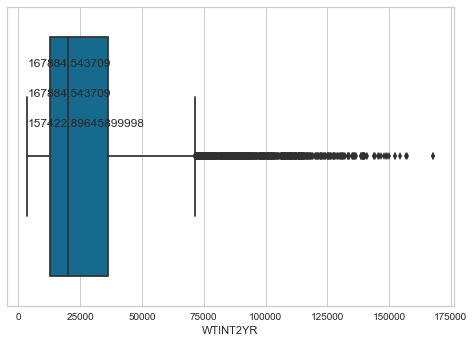

In [16]:
nhs_demographic = clean_float(nhs_demographic,list(set(demo_cont)^set(['SEQN'])))
visualize_float_columns(nhs_demographic,list(set(demo_cont)^set(['SEQN'])))

In [17]:
clean_cat(nhs_examination,exam_cat)
visualize_cat_columns(nhs_examination,exam_cat)

PEASCST1
[1 3 2]
1    9493
3     317
2       3
Name: PEASCST1, dtype: int64


BPAARM
[ 1.  2.  8.]
1.0    9744
2.0      68
8.0       1
Name: BPAARM, dtype: int64


BPACSZ
[ 4.  2.  3.  5.  1.]
4.0    4454
3.0    3395
5.0    1399
2.0     563
1.0       2
Name: BPACSZ, dtype: int64


BPXPULS
[ 1.  2.]
1.0    9678
2.0     135
Name: BPXPULS, dtype: int64


BPXPTY
[ 1.  2.]
1.0    9772
2.0      41
Name: BPXPTY, dtype: int64


BPAEN1
[ 2.  1.]
2.0    9694
1.0     119
Name: BPAEN1, dtype: int64


BPAEN2
[ 2.  1.]
2.0    9344
1.0     469
Name: BPAEN2, dtype: int64


BPAEN3
[ 2.  1.]
2.0    9447
1.0     366
Name: BPAEN3, dtype: int64


BPAEN4
[ nan   2.   1.]
2.0    8610
1.0    1191
Name: BPAEN4, dtype: int64


BMDSTATS
[1 3 2 4]
1    9003
3     423
2     317
4      70
Name: BMDSTATS, dtype: int64


BMIWT
[ nan   4.   3.   1.]
3.0    8889
4.0     451
1.0     435
Name: BMIWT, dtype: int64


BMIRECUM
[ nan   1.]
1.0    9664
Name: BMIRECUM, dtype: int64


BMIHEAD
[ nan]
Series([], Name: BMIHEAD, dt

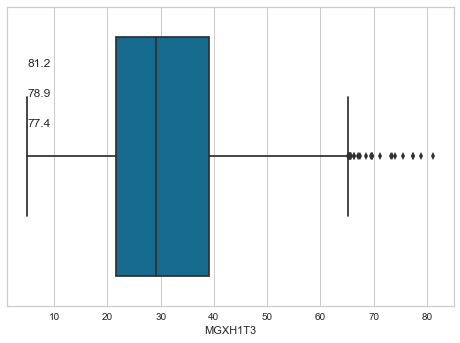

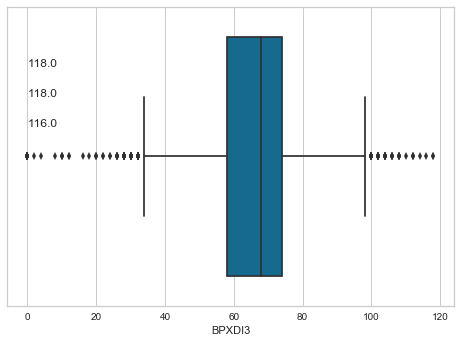

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


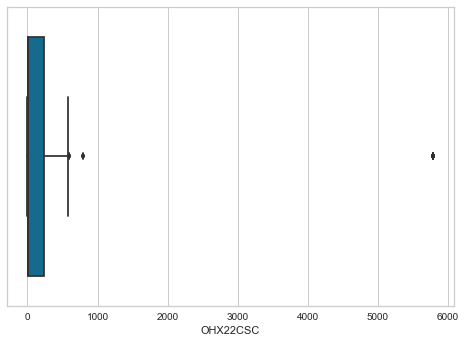

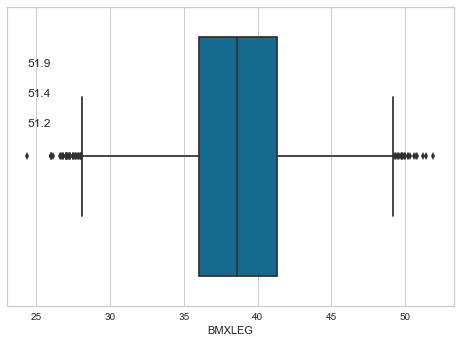

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


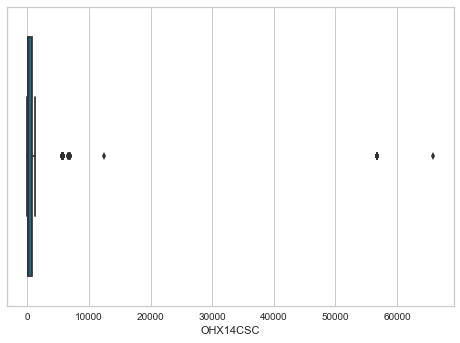

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


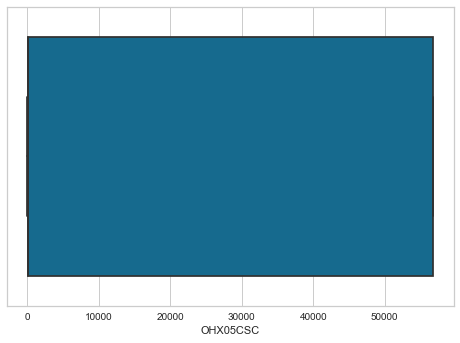

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


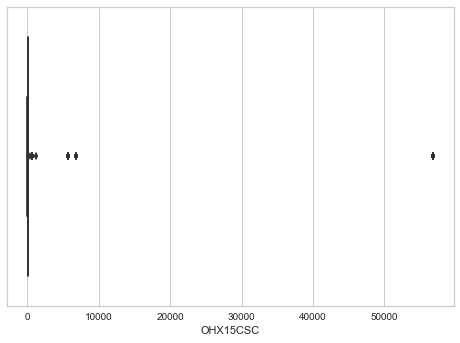

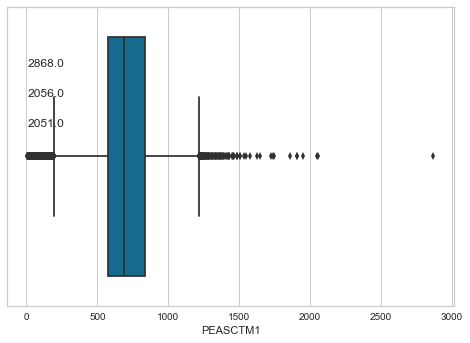

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


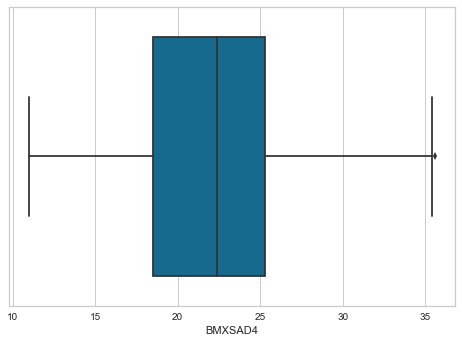

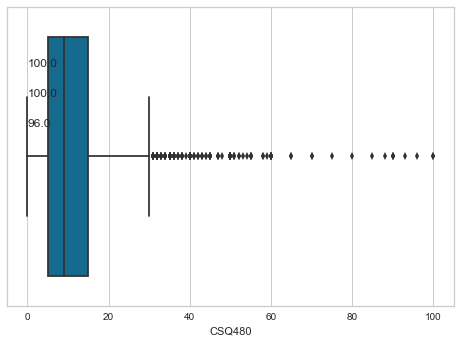

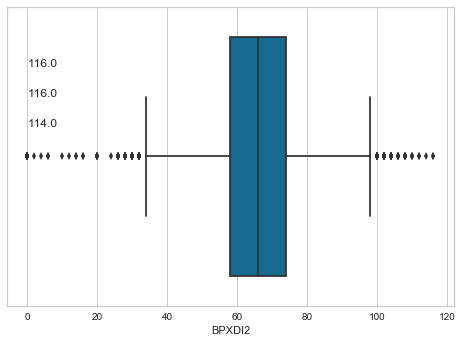

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


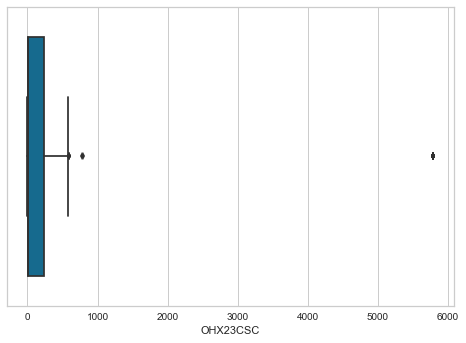

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


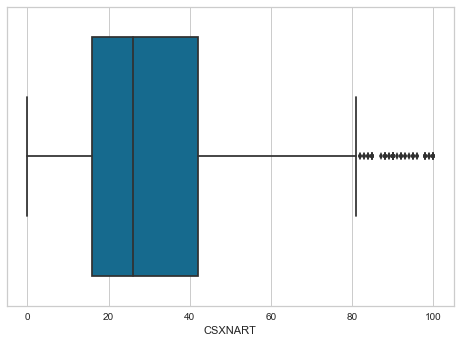

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


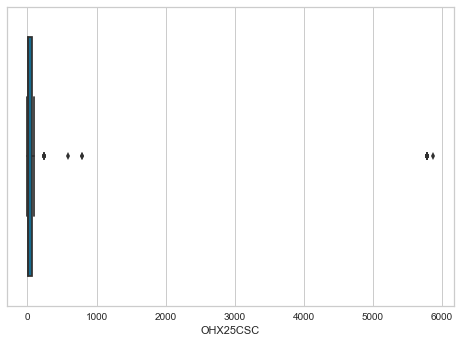

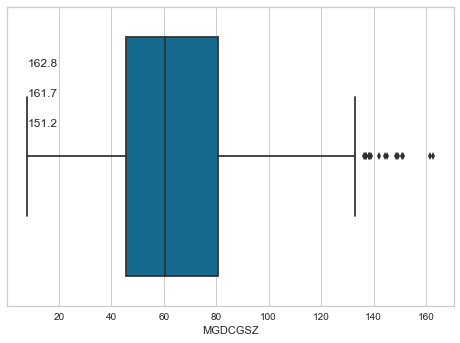

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


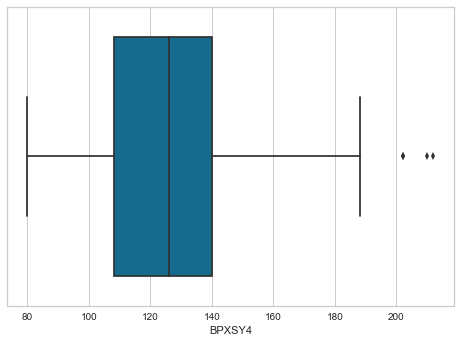

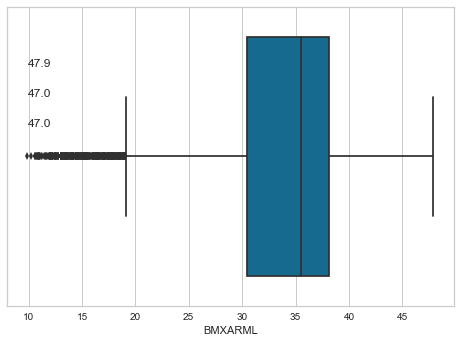

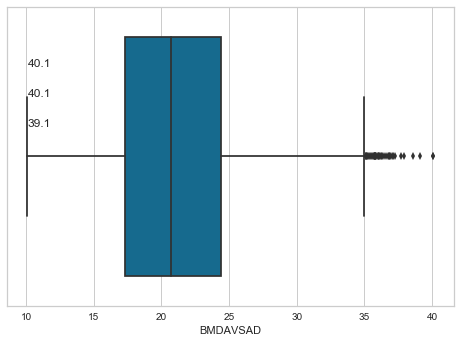

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


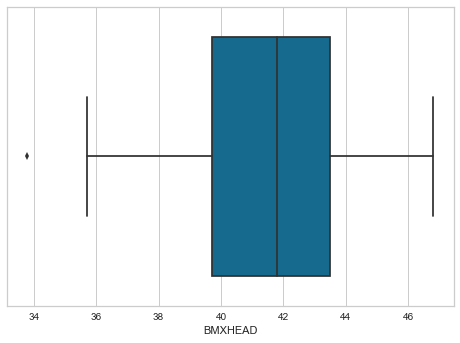

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


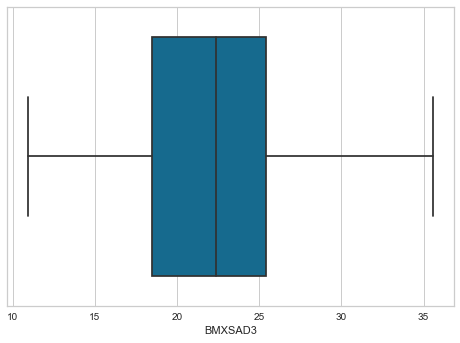

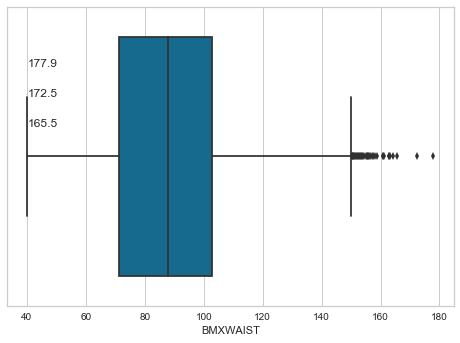

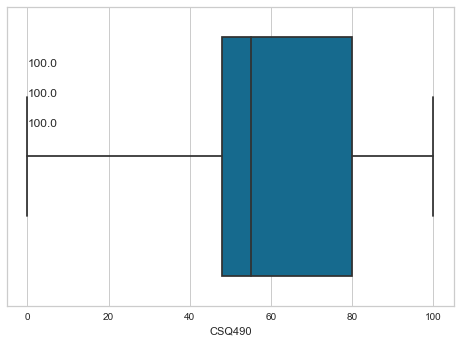

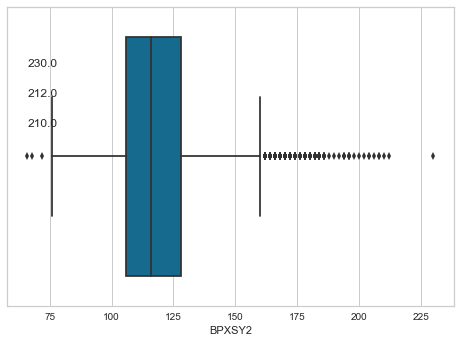

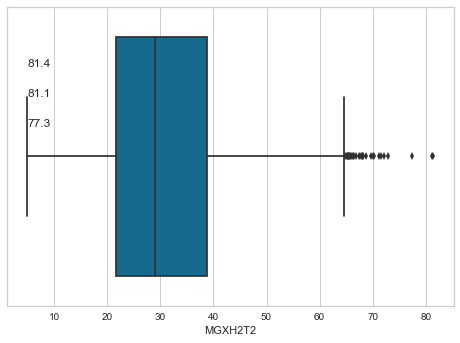

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


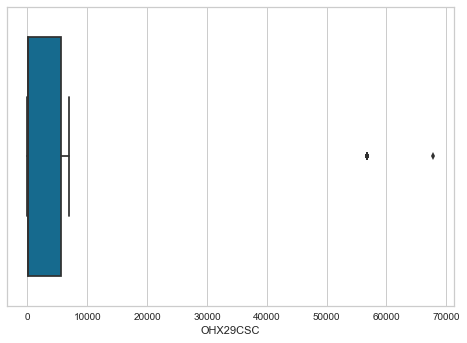

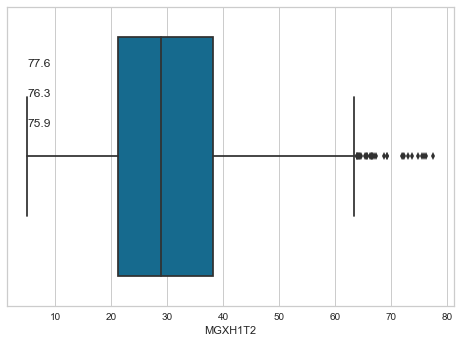

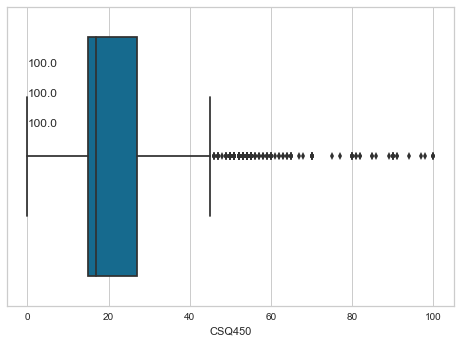

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


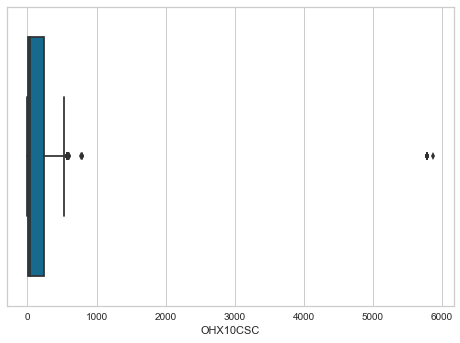

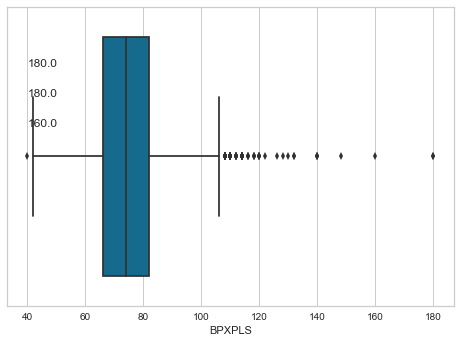

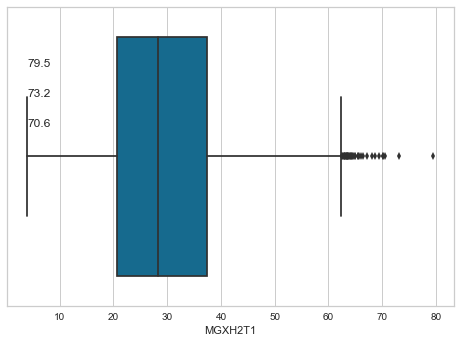

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


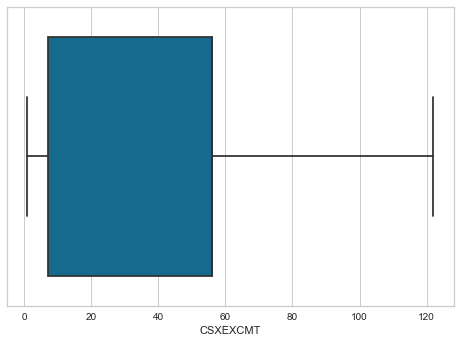

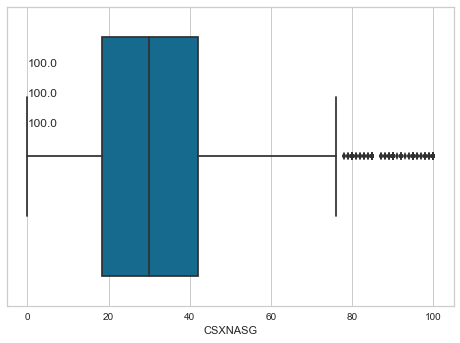

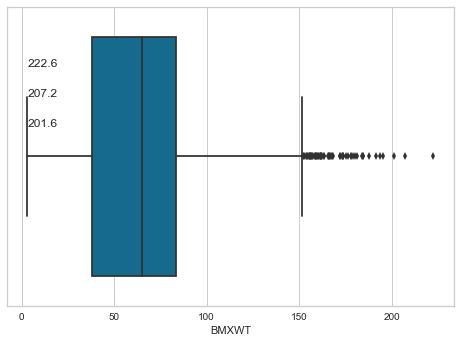

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


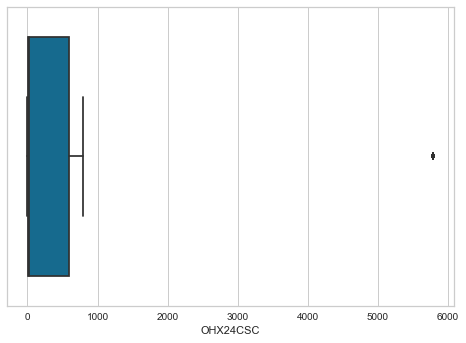

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


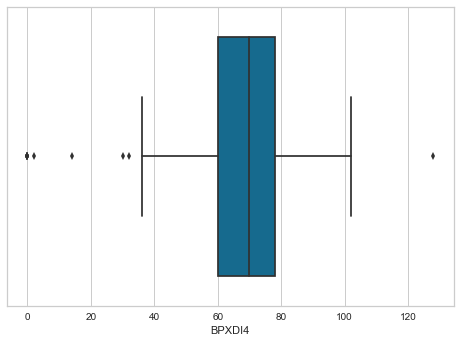

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


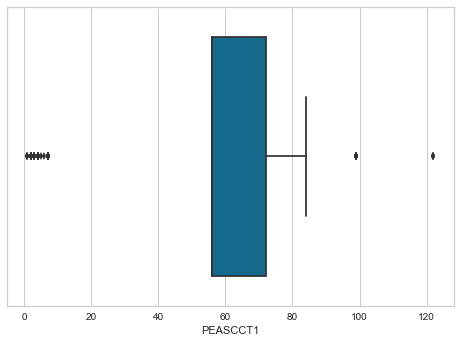

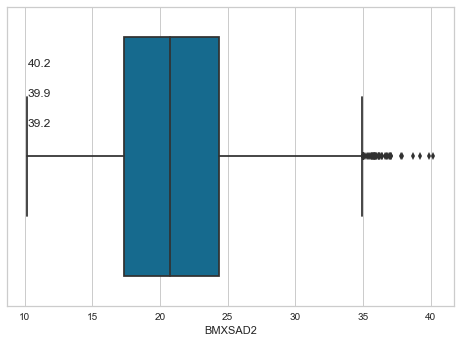

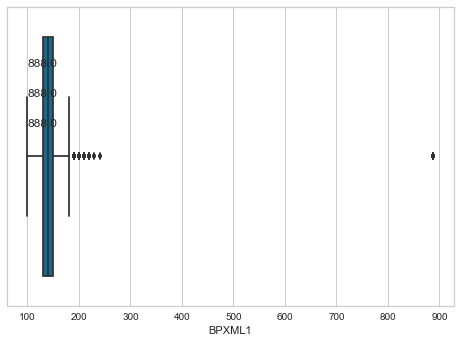

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


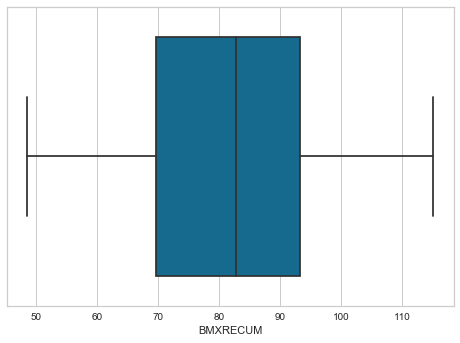

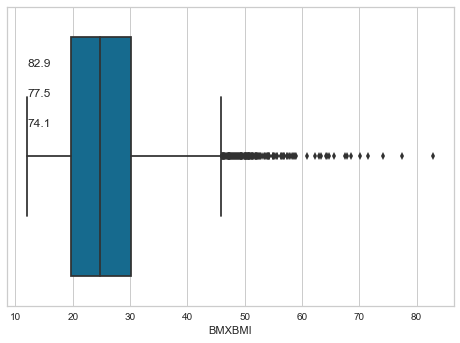

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


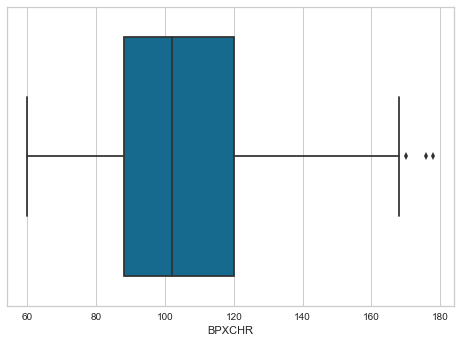

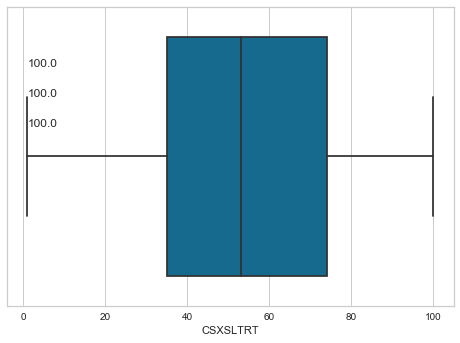

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


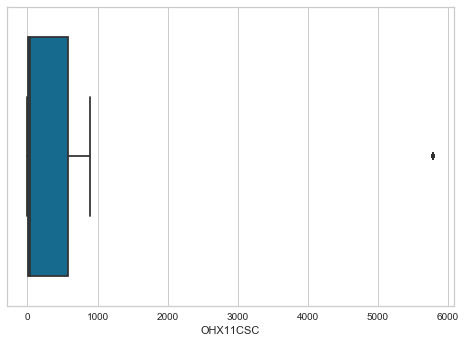

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


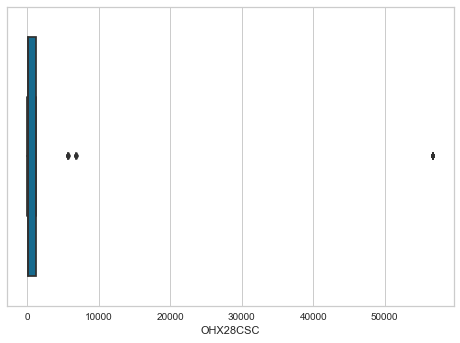

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


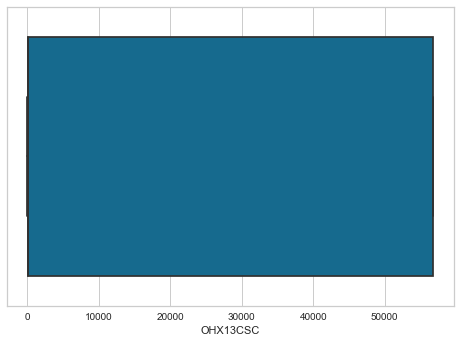

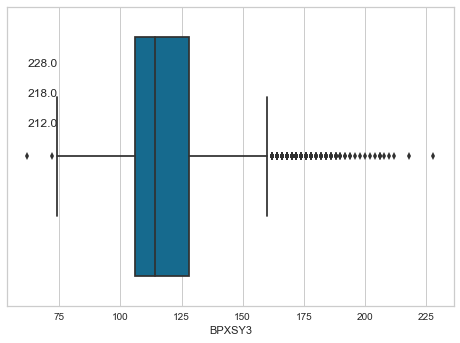

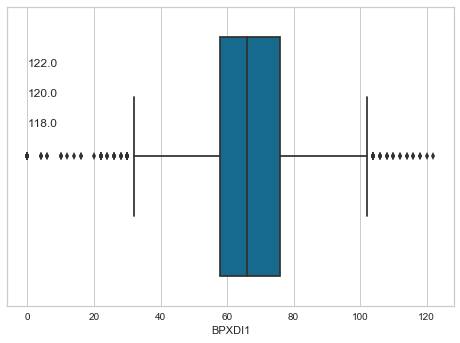

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


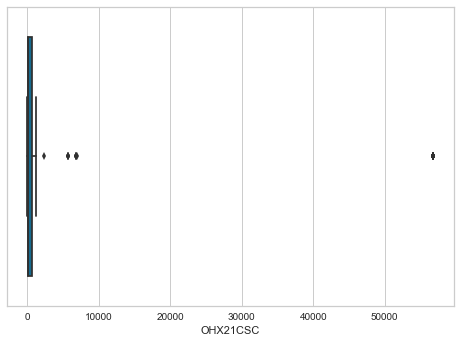

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


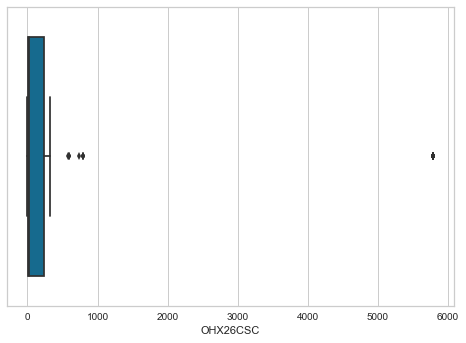

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


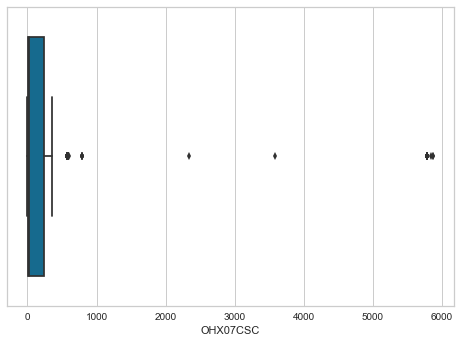

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


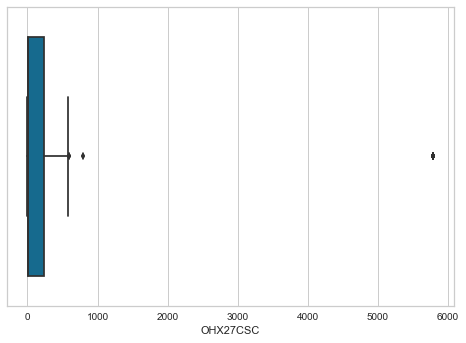

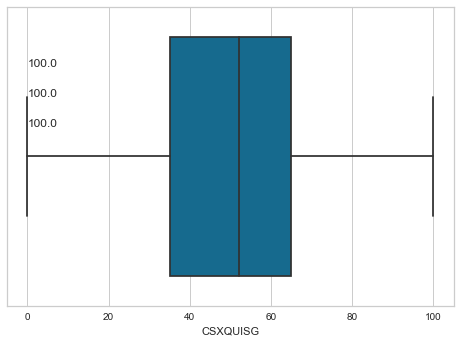

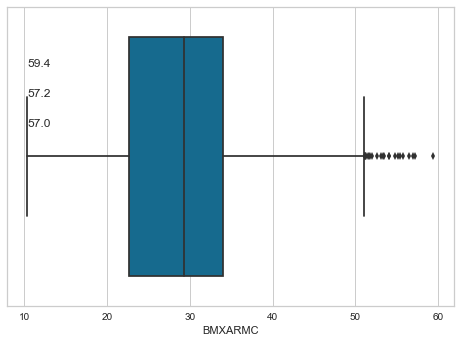

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


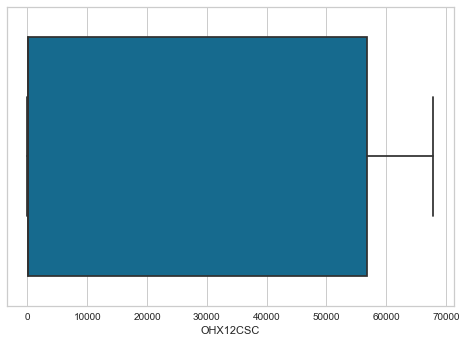

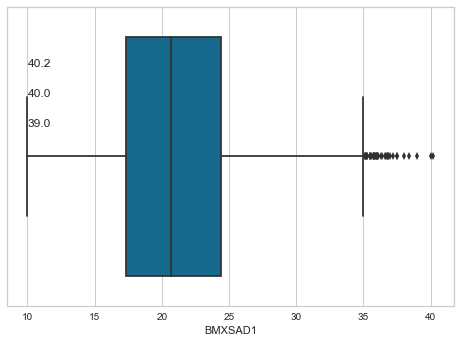

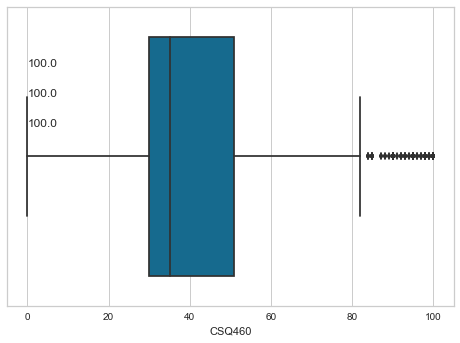

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


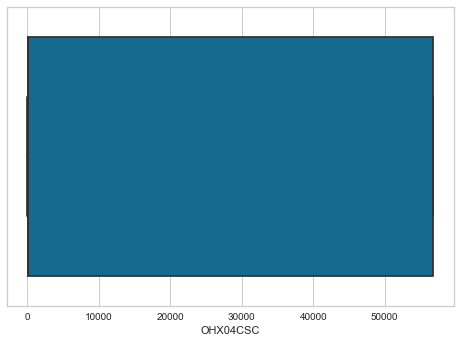

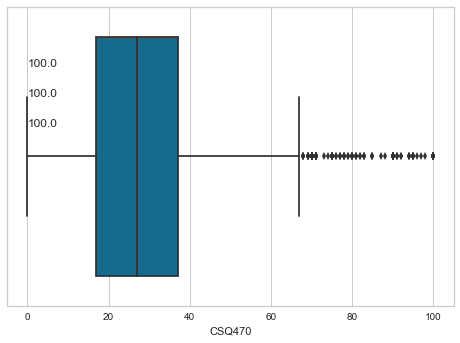

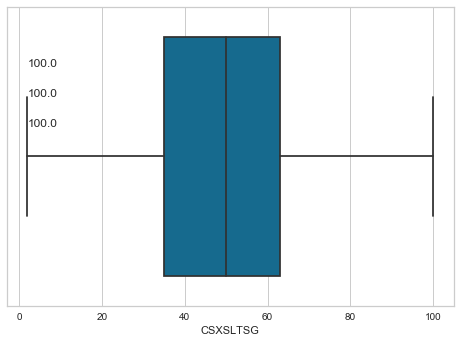

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


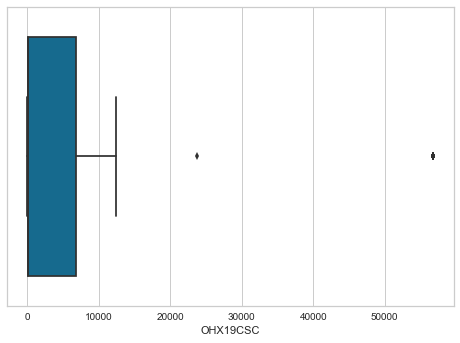

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


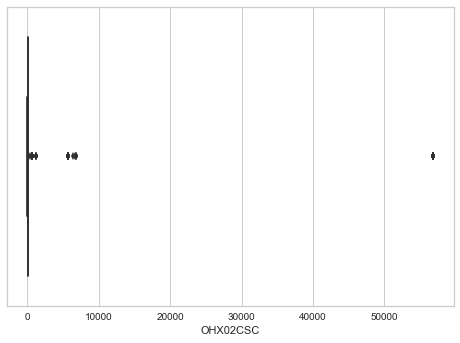

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


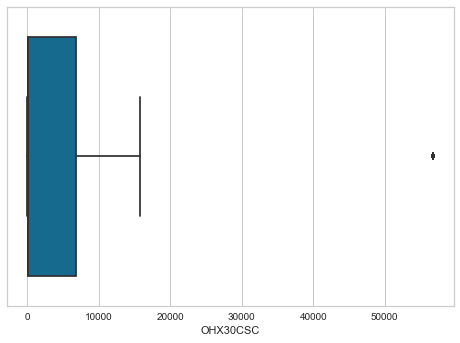

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


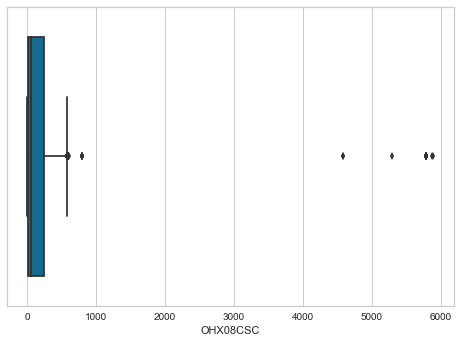

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


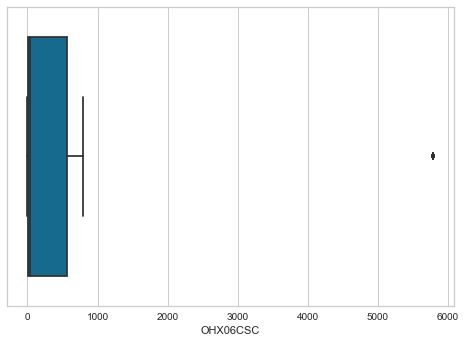

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


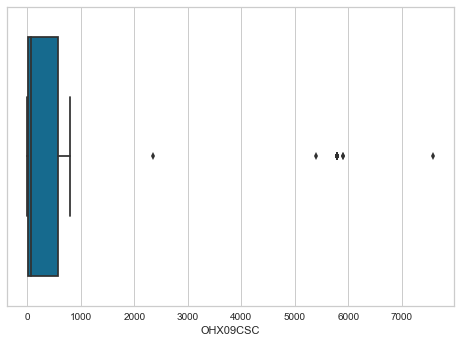

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


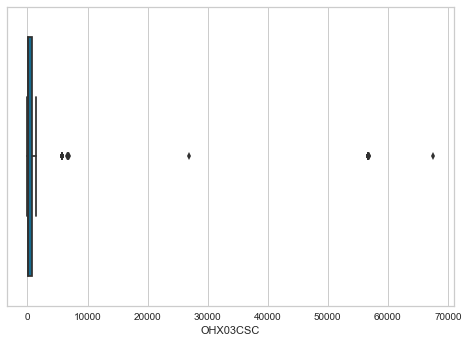

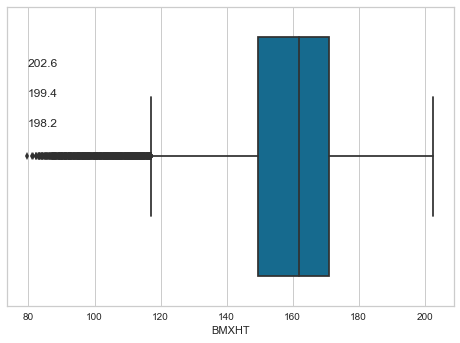

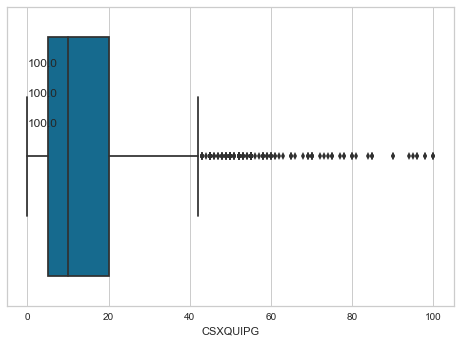

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


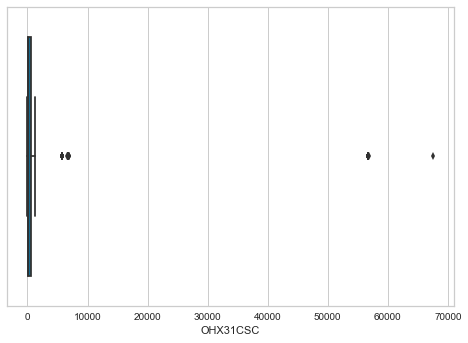

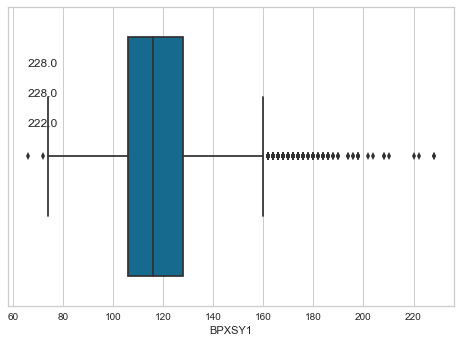

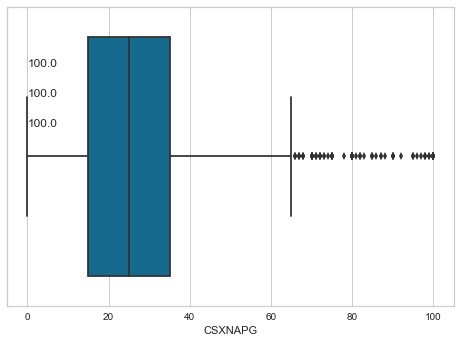

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


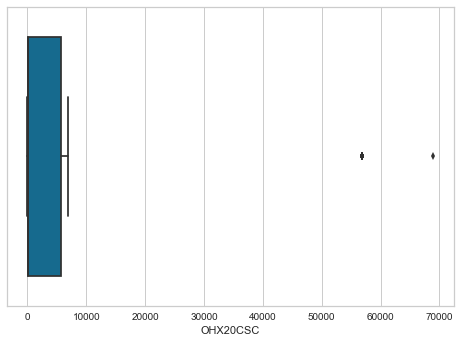

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


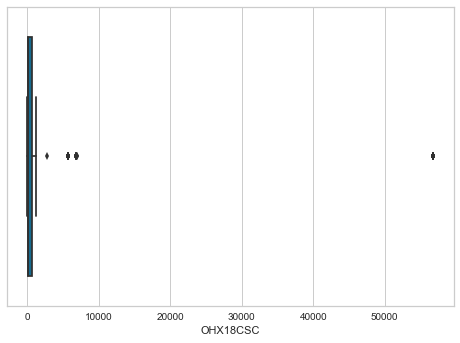

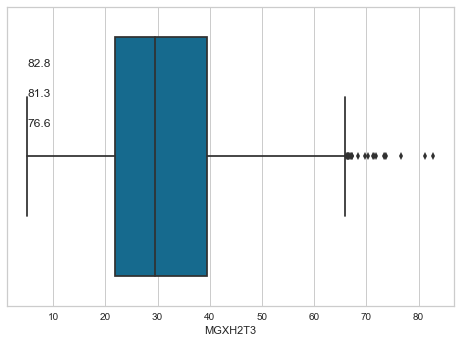

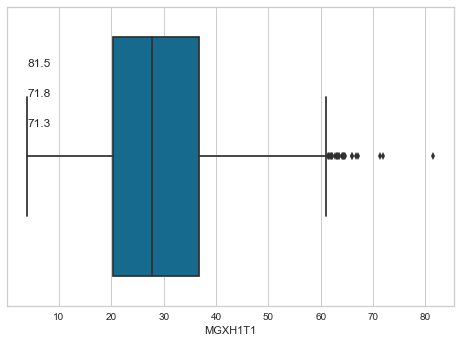

In [18]:
nhs_examination = clean_float(nhs_examination,list(set(exam_cont)^set(['SEQN'])))
visualize_float_columns(nhs_examination,list(set(exam_cont)^set(['SEQN'])))

In [19]:
nhs_labs
clean_cat(nhs_labs,labs_cat)
visualize_cat_columns(nhs_labs,labs_cat)

LBDBANO
[ 0.1  0.   0.2  0.3  0.8]
0.0    5519
0.1    4229
0.2      58
0.3       6
0.8       1
Name: LBDBANO, dtype: int64


URXUCL
[ nan   2.   1.]
2.0    9524
1.0     279
Name: URXUCL, dtype: int64


URDBP3LC
[ nan   0.   1.]
0.0    9517
1.0     286
Name: URDBP3LC, dtype: int64


URDBPHLC
[ nan   0.   1.]
0.0    9403
1.0     400
Name: URDBPHLC, dtype: int64


URDBPFLC
[ nan   1.   0.]
0.0    6360
1.0    3443
Name: URDBPFLC, dtype: int64


URDBPSLC
[ nan   1.   0.]
0.0    8847
1.0     956
Name: URDBPSLC, dtype: int64


URDTLCLC
[ nan   0.   1.]
1.0    6048
0.0    3755
Name: URDTLCLC, dtype: int64


URDTRSLC
[ nan   0.   1.]
0.0    7429
1.0    2374
Name: URDTRSLC, dtype: int64


URDBUPLC
[ nan   1.   0.]
1.0    6673
0.0    3130
Name: URDBUPLC, dtype: int64


URDEPBLC
[ nan   0.   1.]
1.0    5191
0.0    4612
Name: URDEPBLC, dtype: int64


URDMPBLC
[ nan   0.   1.]
0.0    9752
1.0      51
Name: URDMPBLC, dtype: int64


URDPPBLC
[ nan   0.   1.]
0.0    9709
1.0      94
Name: URDPPBLC, dty

[ nan   2.   3.   1.]
2.0    9582
1.0     169
3.0      54
Name: LBDR59.y, dtype: int64


LBDR61.y
[ nan   2.   1.   3.]
2.0    9280
1.0     471
3.0      54
Name: LBDR61.y, dtype: int64


LBDR62.y
[ nan   2.   3.   1.]
2.0    9177
1.0     574
3.0      54
Name: LBDR62.y, dtype: int64


LBDR64.y
[ nan   2.   3.]
2.0    9751
3.0      54
Name: LBDR64.y, dtype: int64


LBDR66.y
[ nan   2.   1.   3.]
2.0    9474
1.0     277
3.0      54
Name: LBDR66.y, dtype: int64


LBDR67.y
[ nan   2.   1.   3.]
2.0    9662
1.0      89
3.0      54
Name: LBDR67.y, dtype: int64


LBDR68.y
[ nan   2.   3.   1.]
2.0    9543
1.0     208
3.0      54
Name: LBDR68.y, dtype: int64


LBDR69.y
[ nan   2.   3.   1.]
2.0    9740
3.0      54
1.0      11
Name: LBDR69.y, dtype: int64


LBDR70.y
[ nan   2.   3.   1.]
2.0    9524
1.0     227
3.0      54
Name: LBDR70.y, dtype: int64


LBDR71.y
[ nan   2.   1.   3.]
2.0    9669
1.0      82
3.0      54
Name: LBDR71.y, dtype: int64


LBDR72.y
[ nan   2.   3.   1.]
2.0    9613
1.0

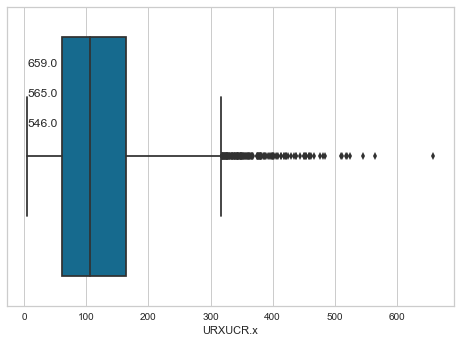

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


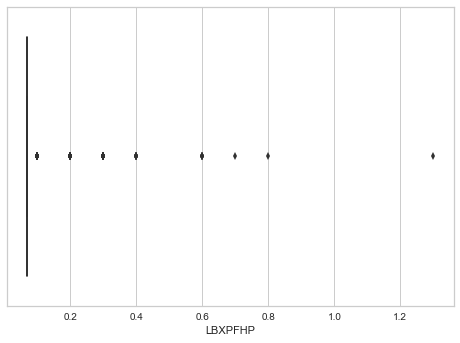

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


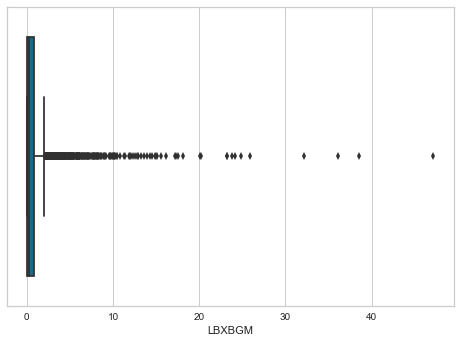

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


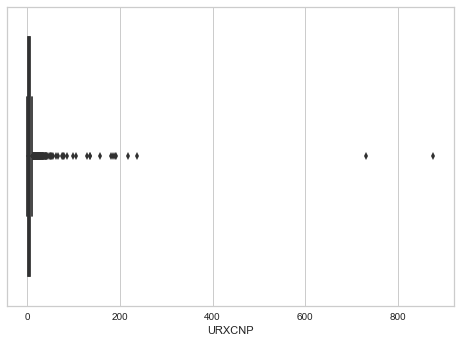

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


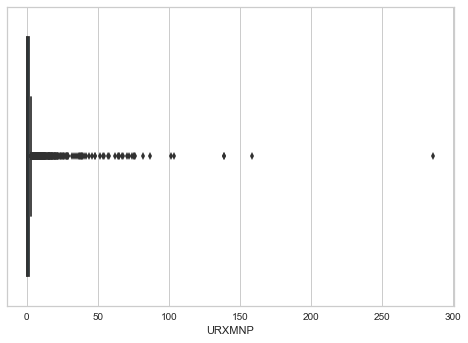

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


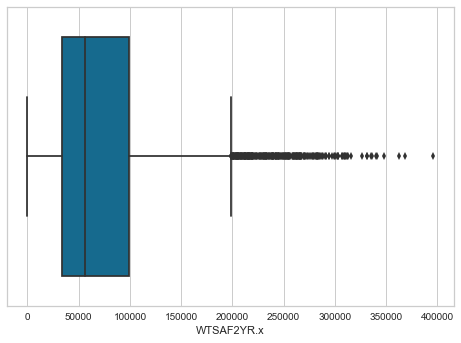

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


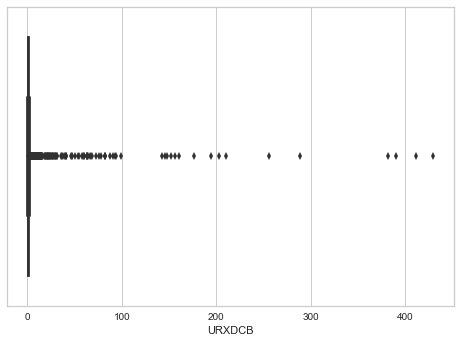

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


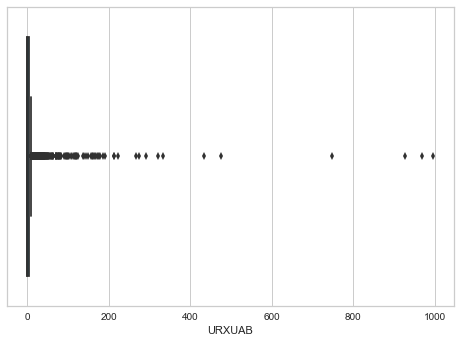

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


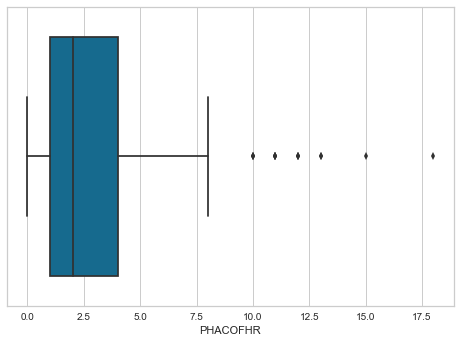

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


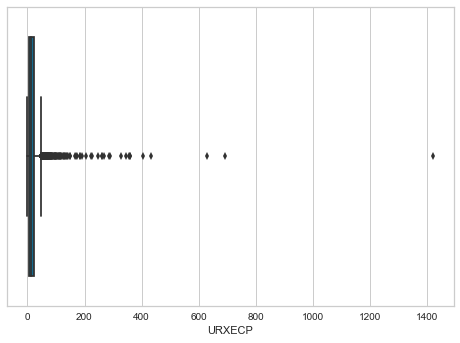

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


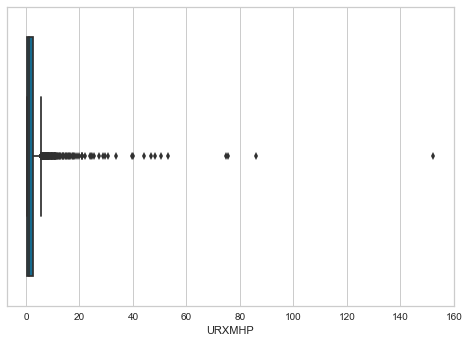

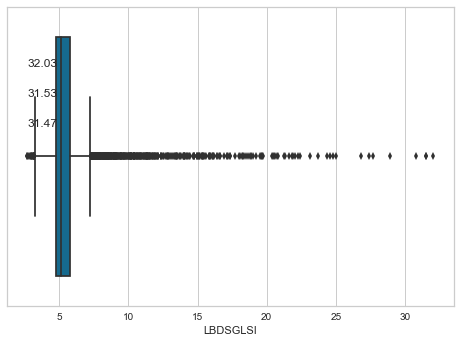

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


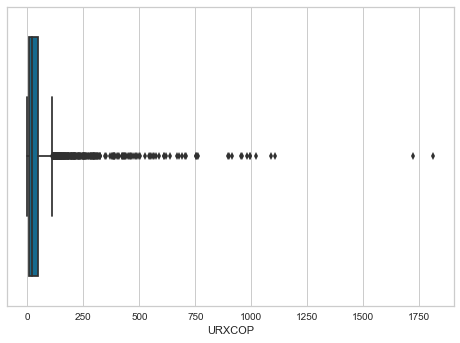

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


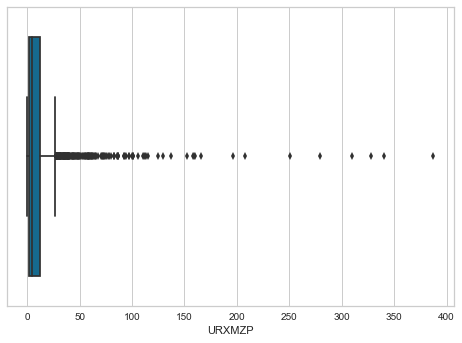

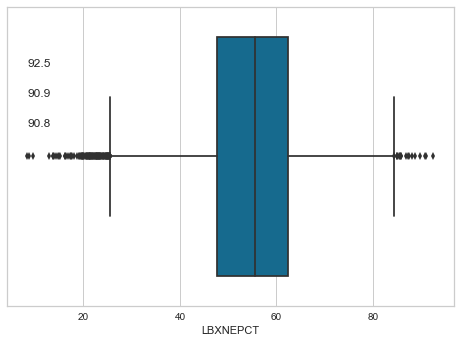

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


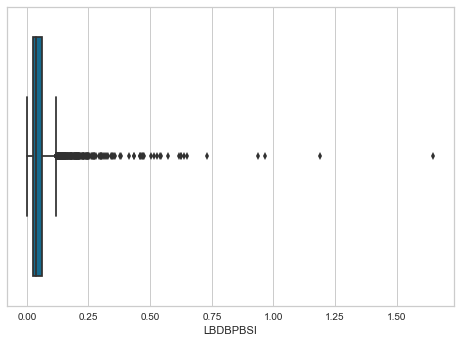

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


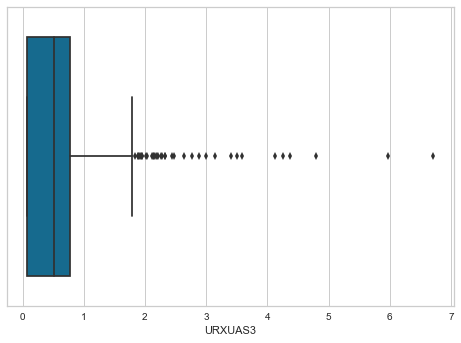

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


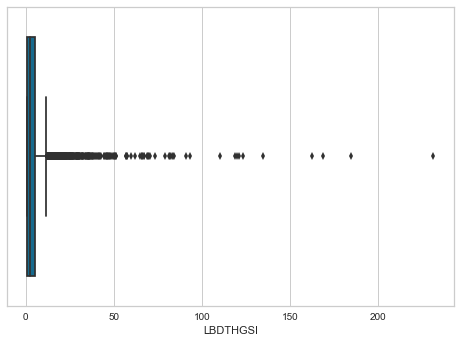

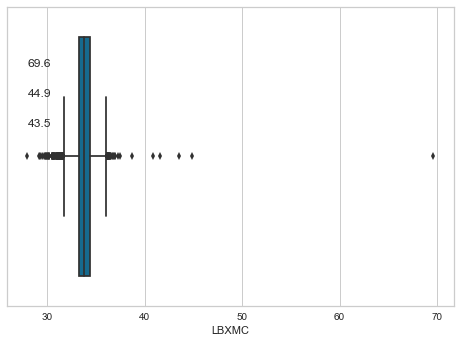

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


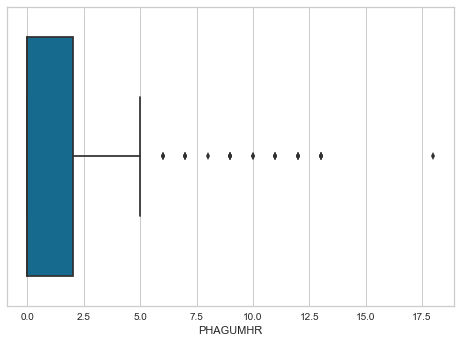

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


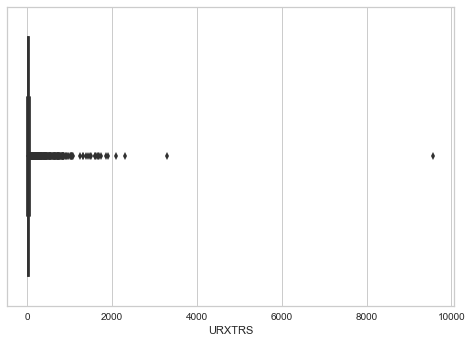

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


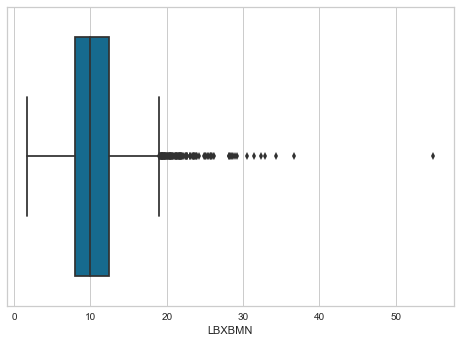

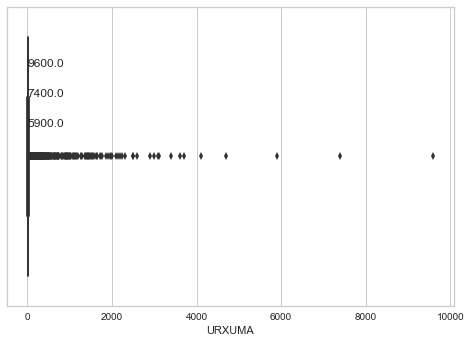

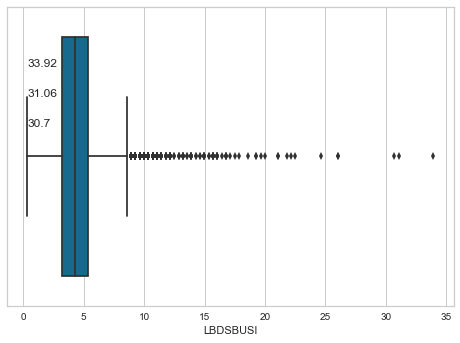

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


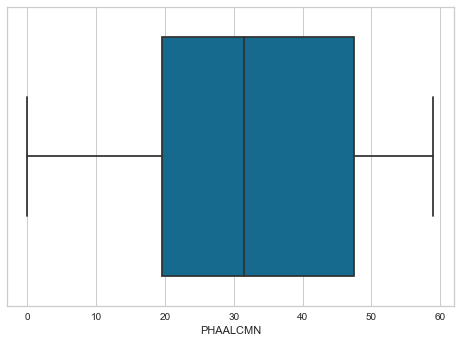

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


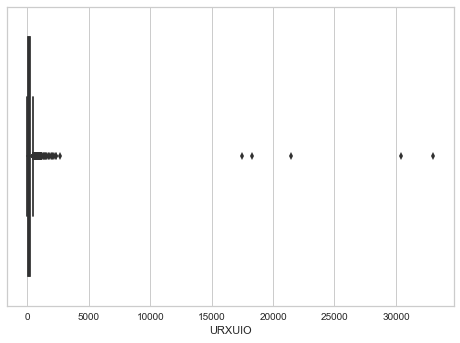

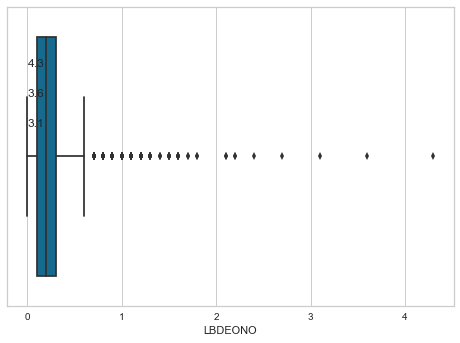

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


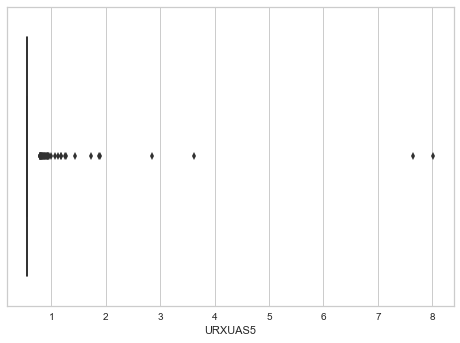

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


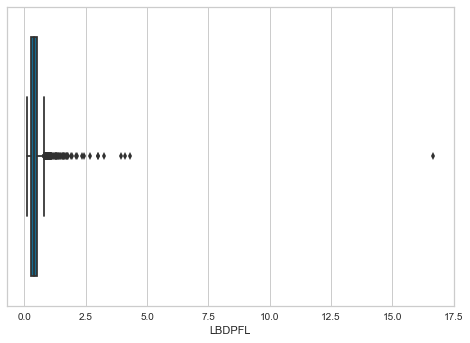

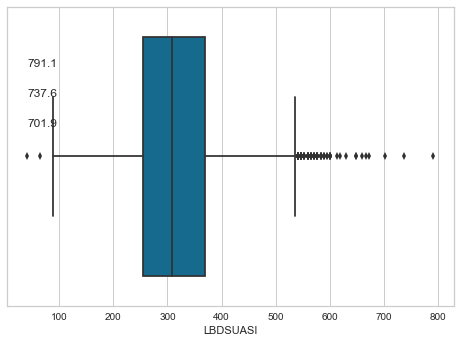

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


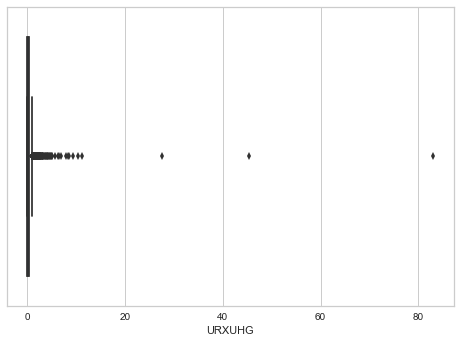

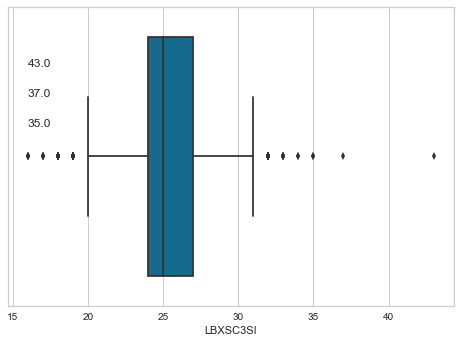

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


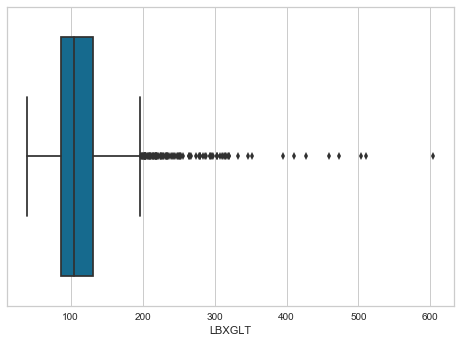

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


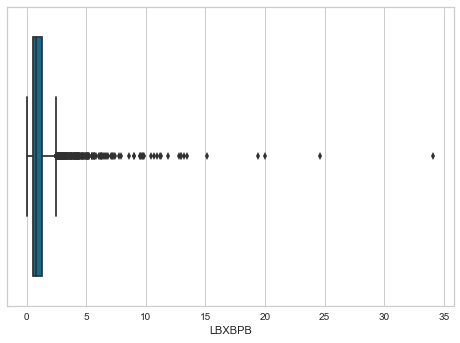

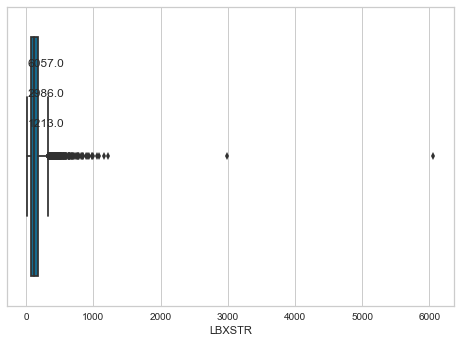

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


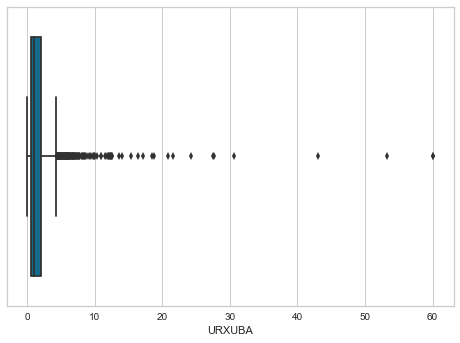

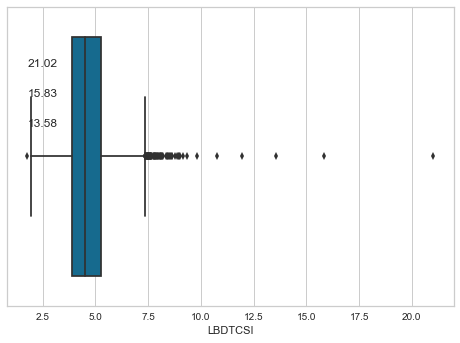

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


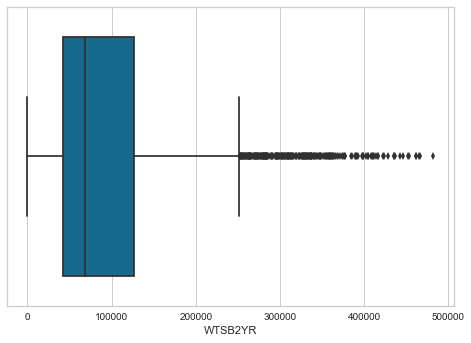

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


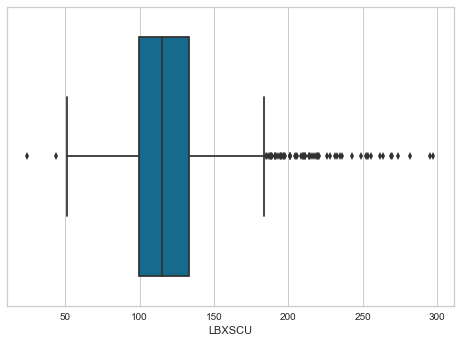

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


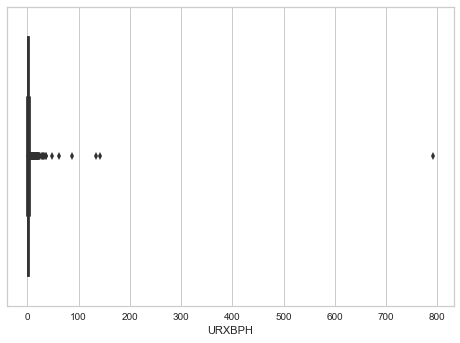

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


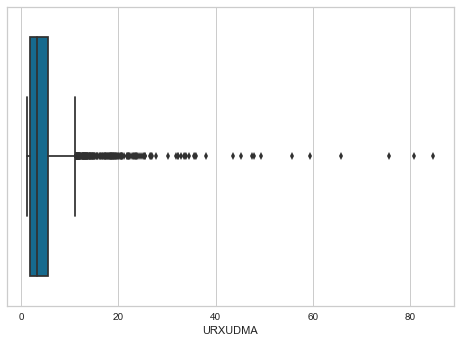

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


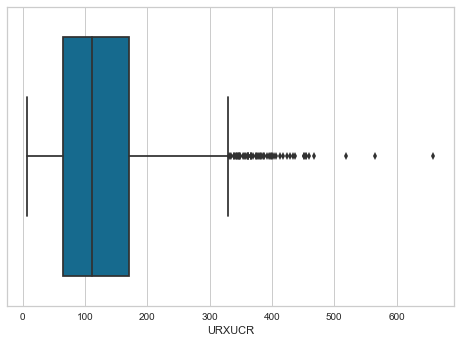

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


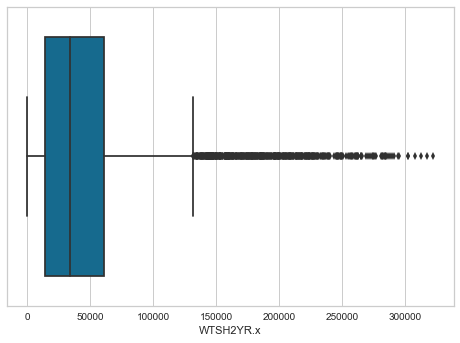

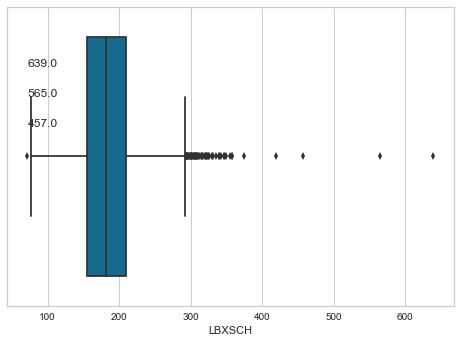

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


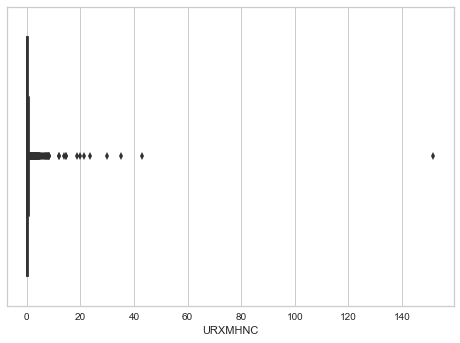

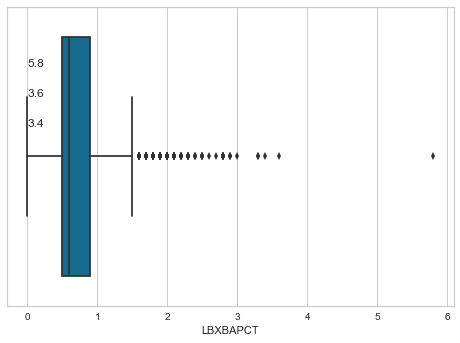

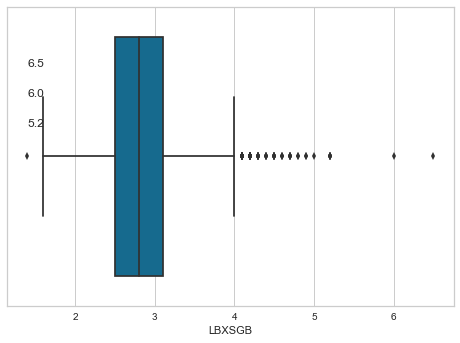

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


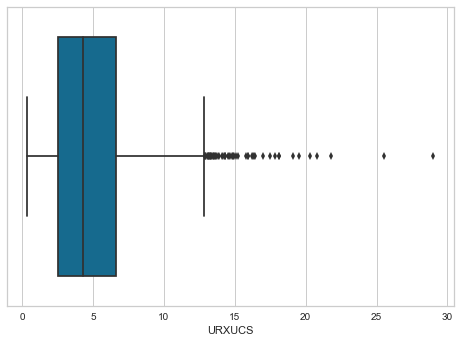

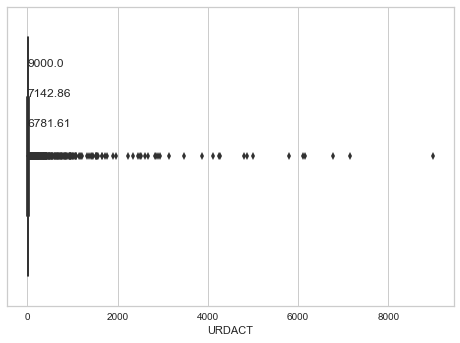

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


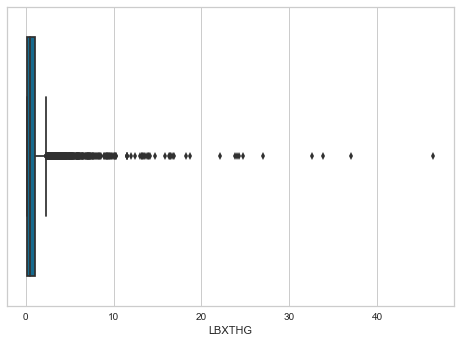

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


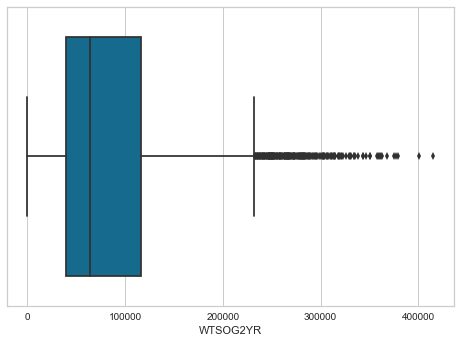

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


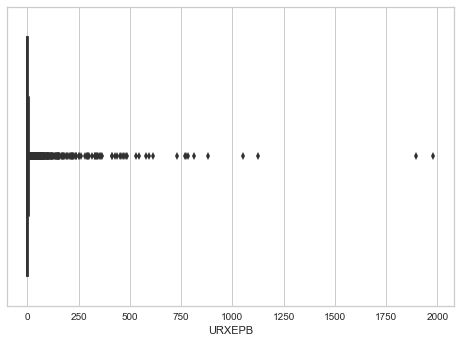

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


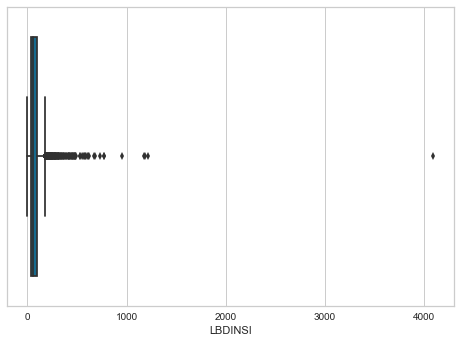

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


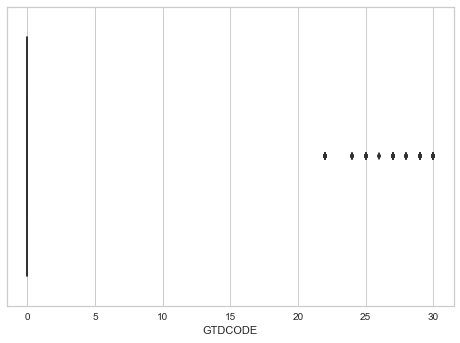

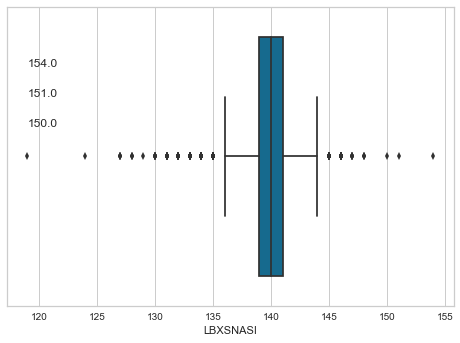

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


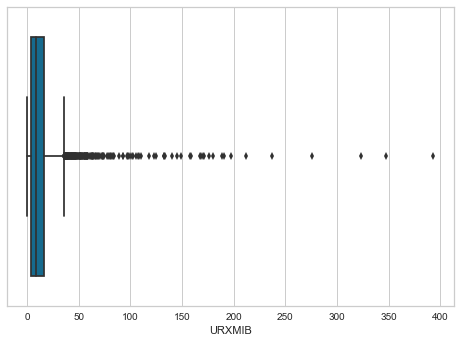

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


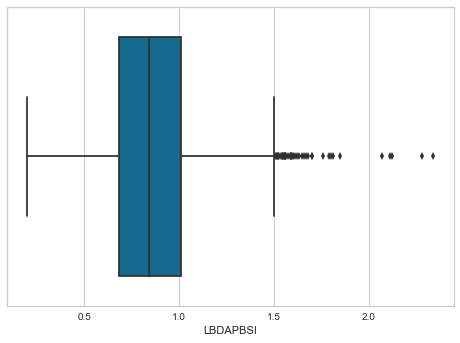

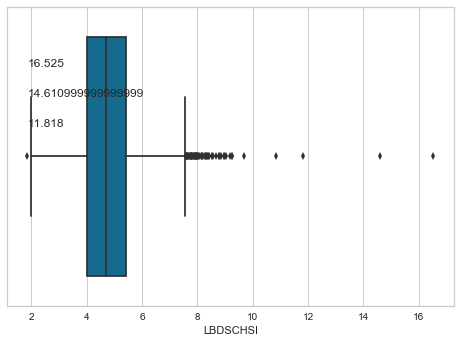

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


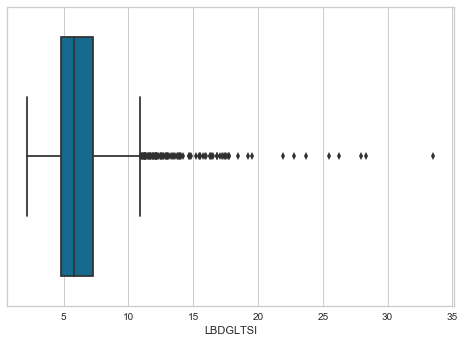

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


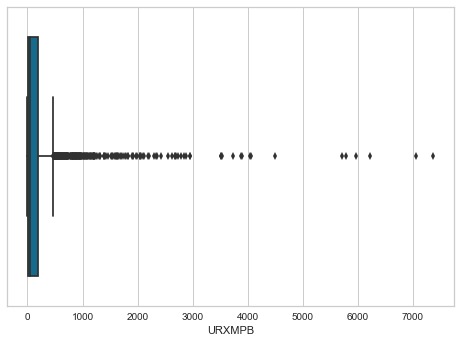

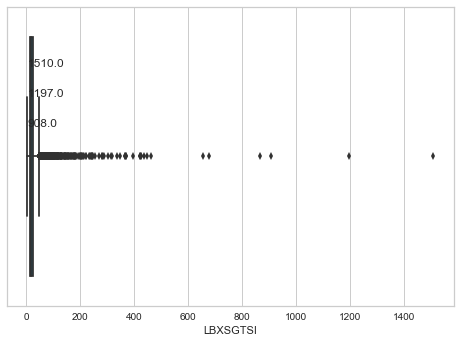

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


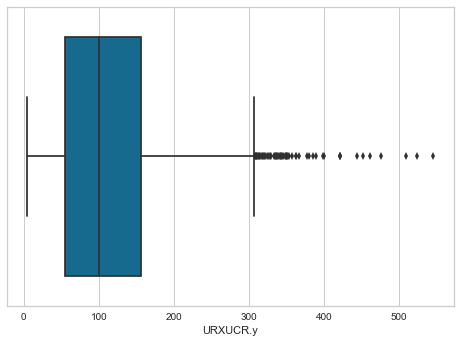

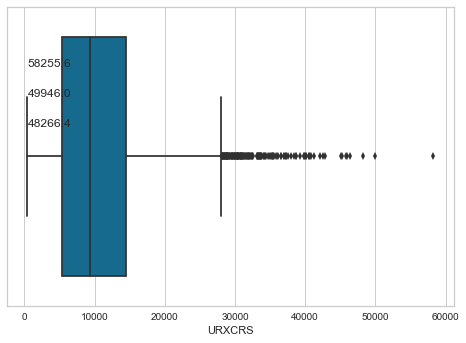

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


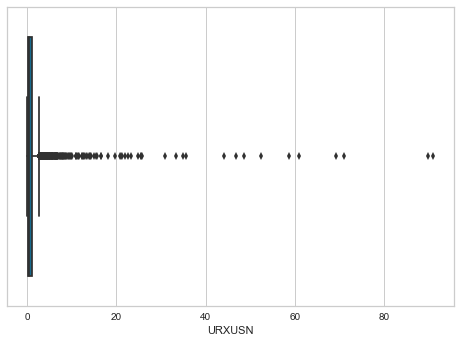

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


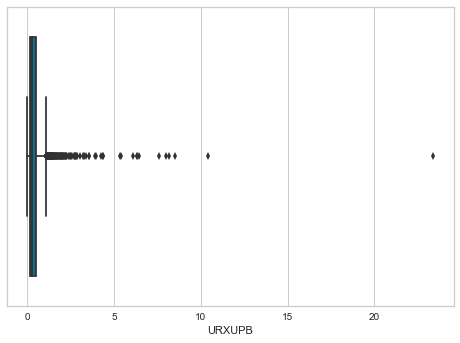

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


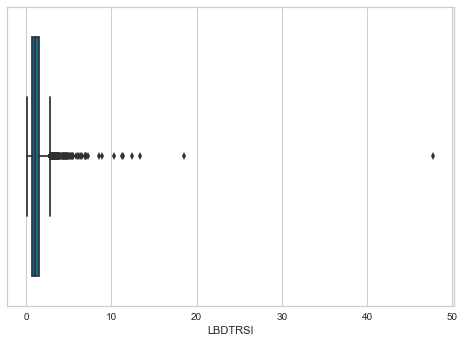

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


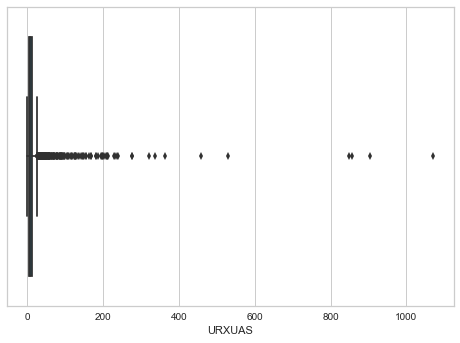

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


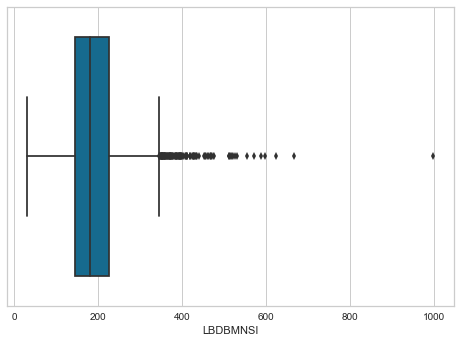

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


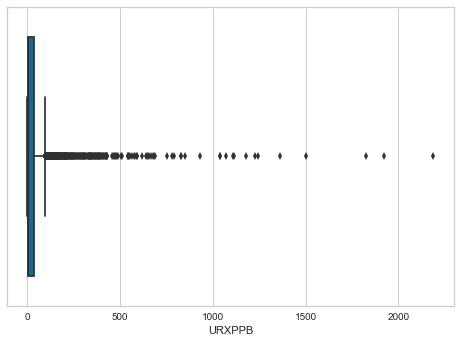

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


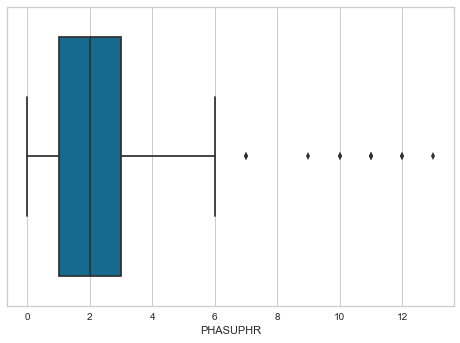

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


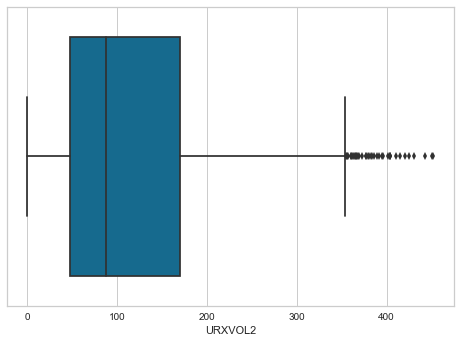

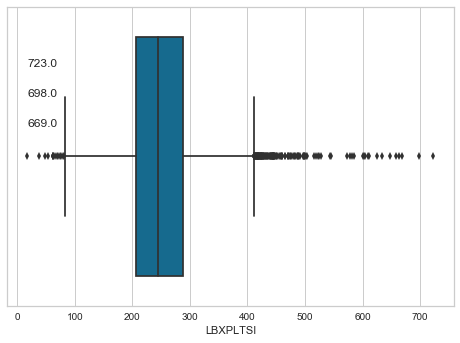

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


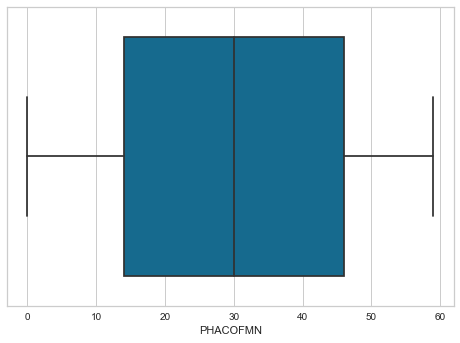

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


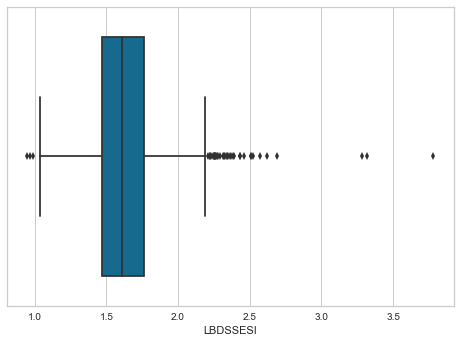

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


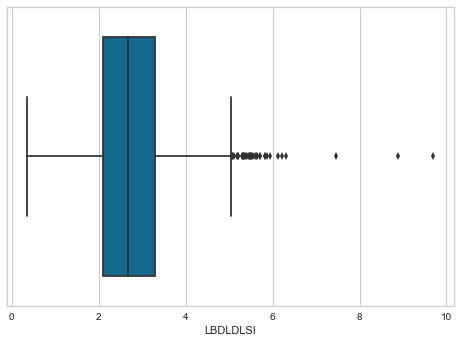

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


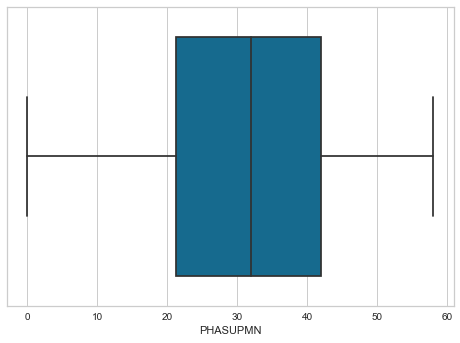

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


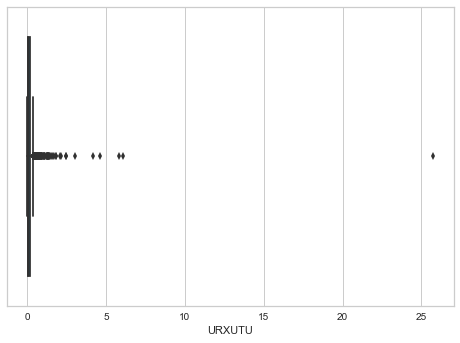

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


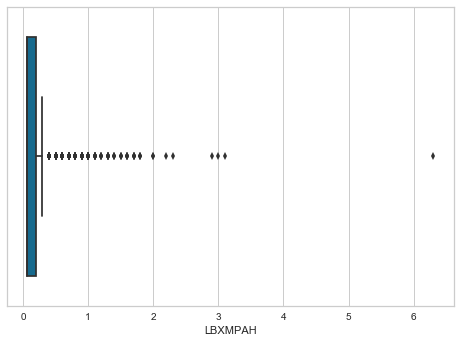

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


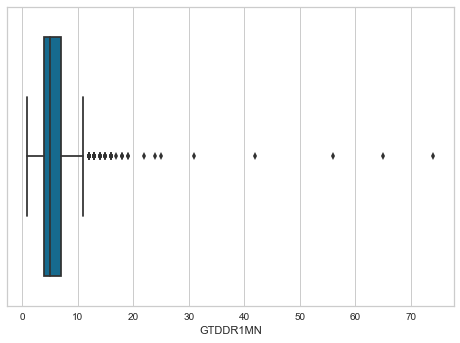

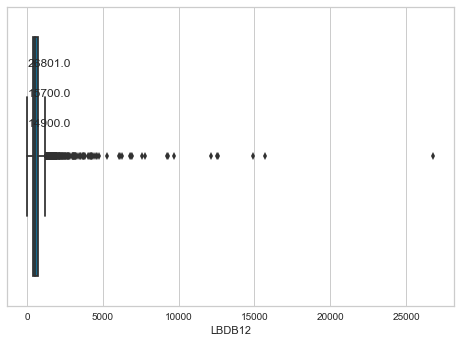

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


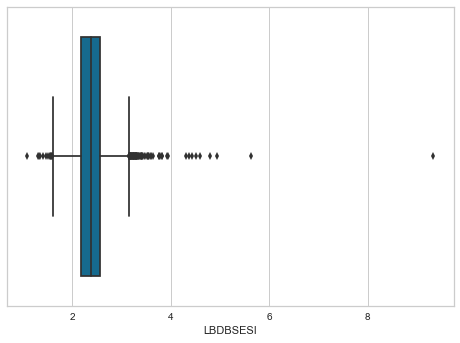

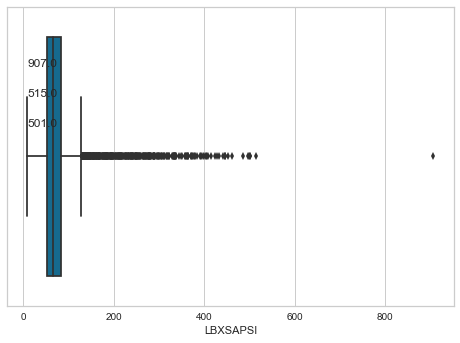

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


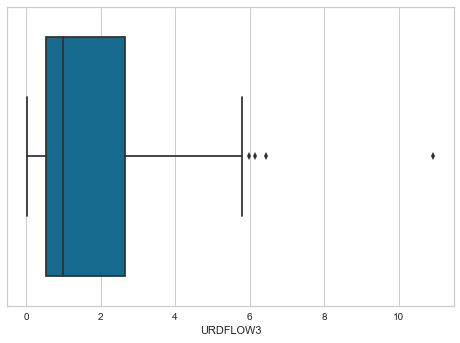

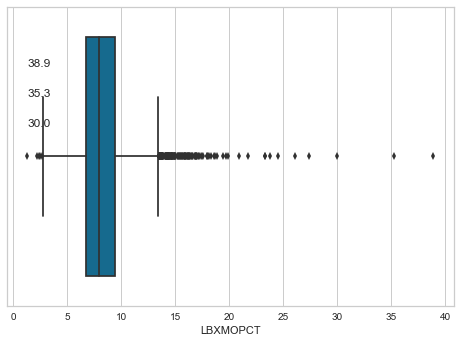

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


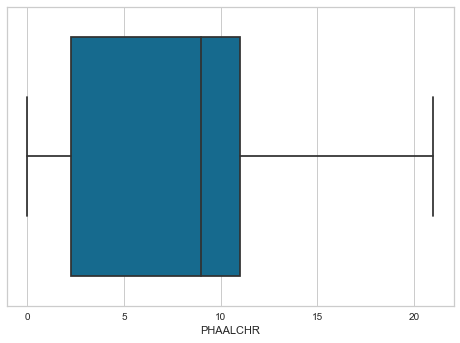

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


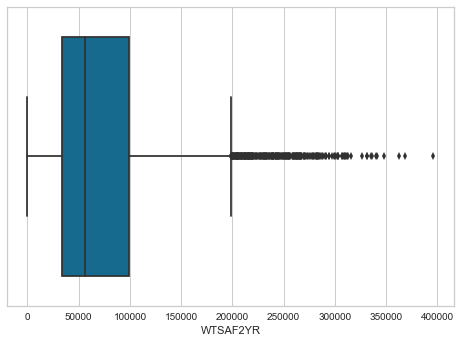

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


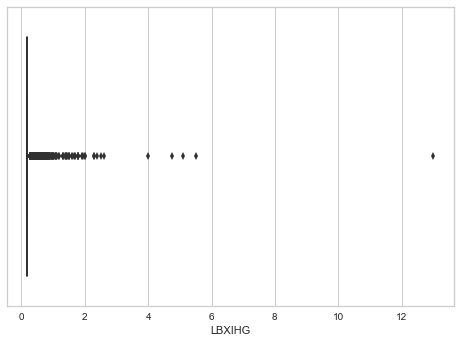

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


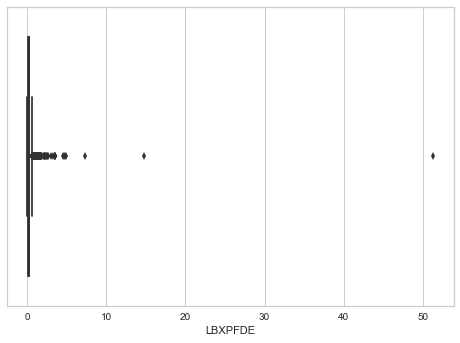

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


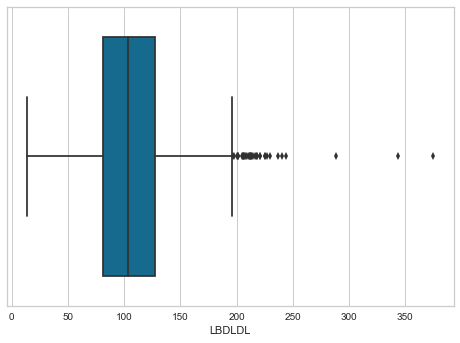

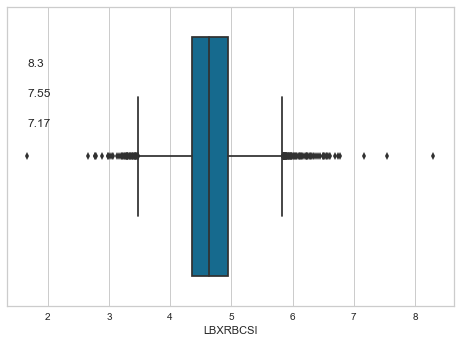

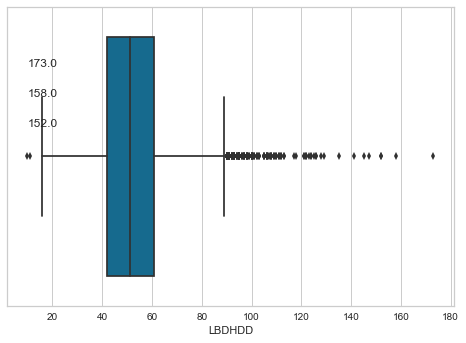

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


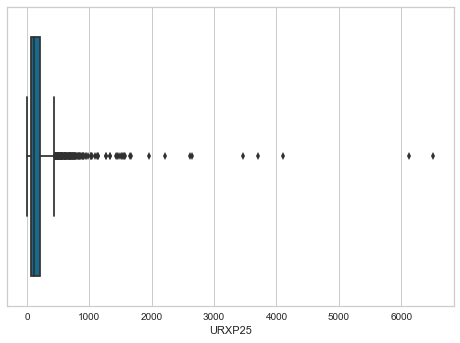

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


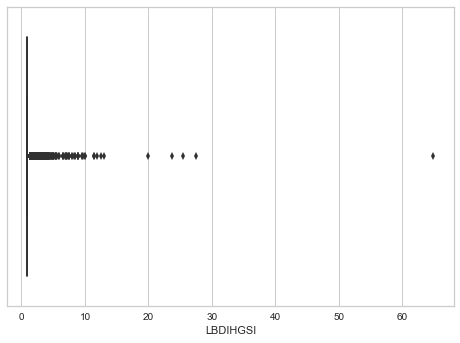

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


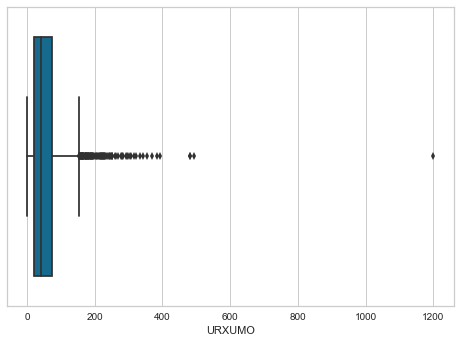

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


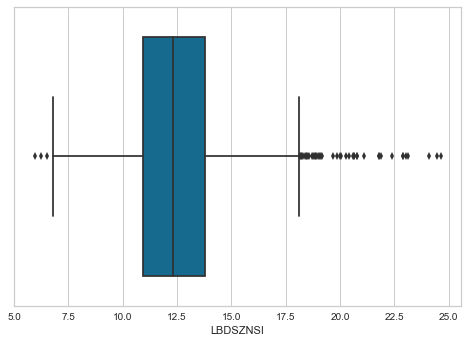

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


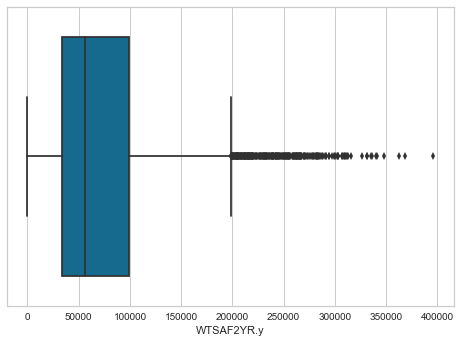

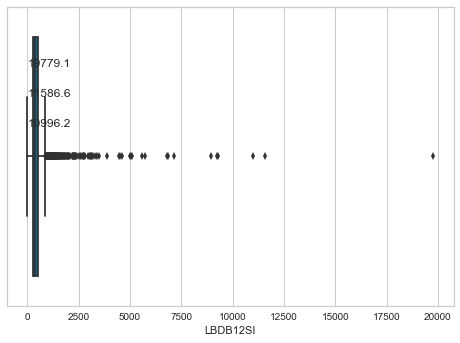

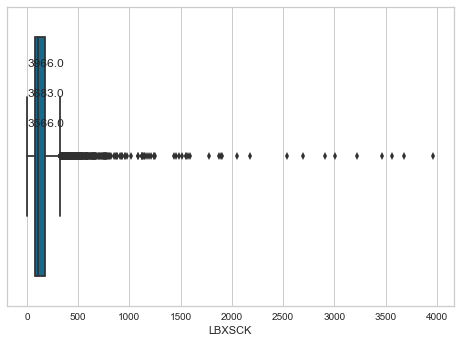

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


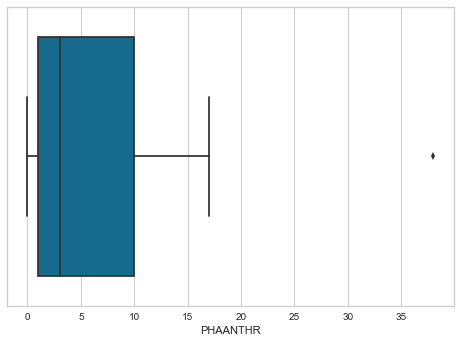

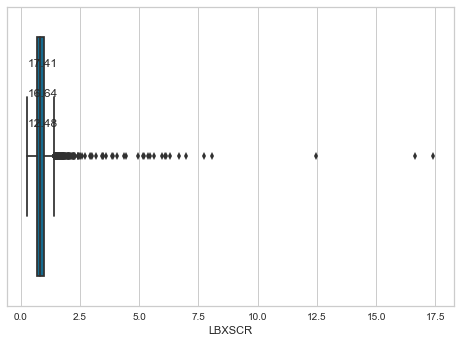

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


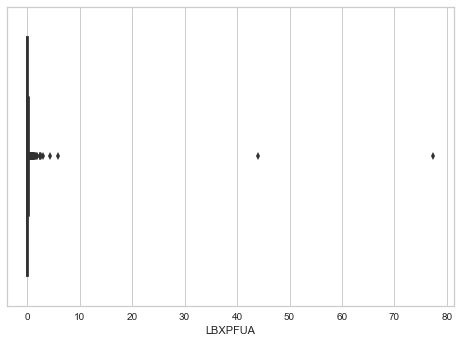

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


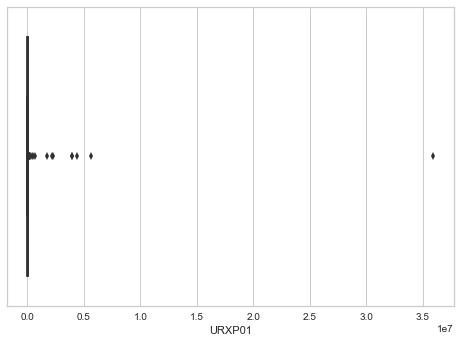

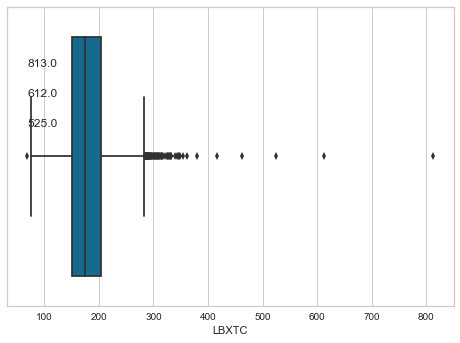

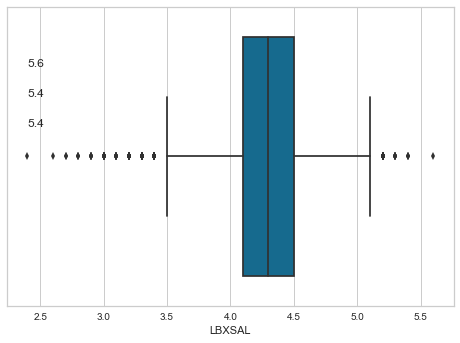

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


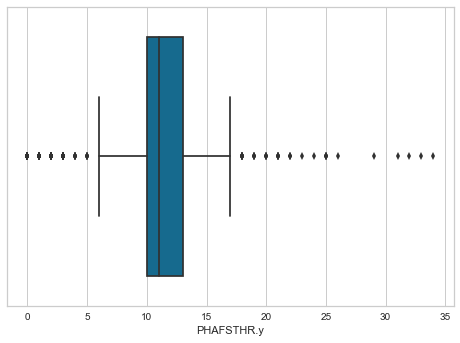

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


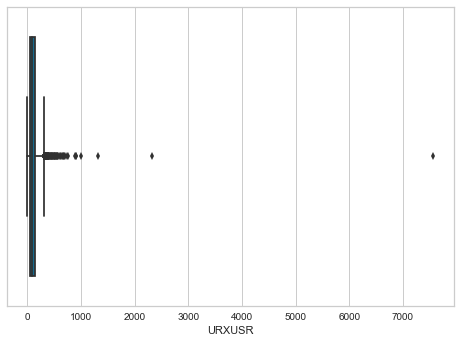

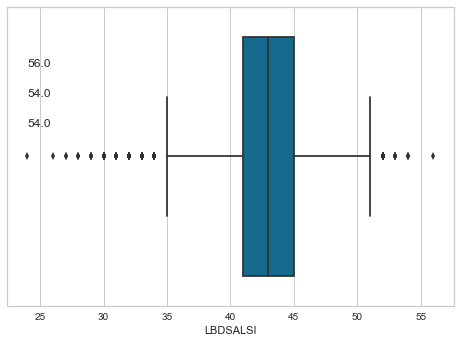

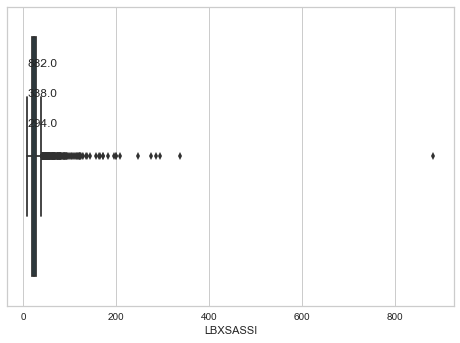

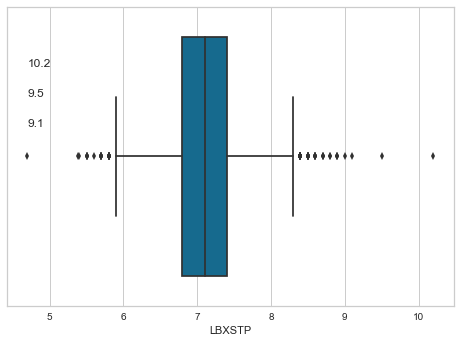

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


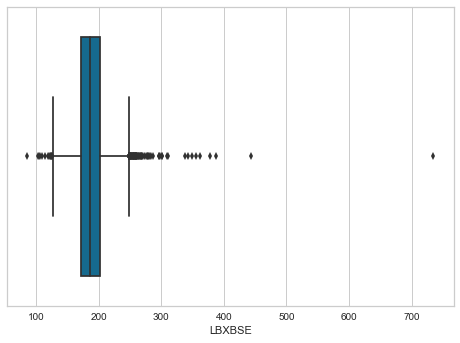

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


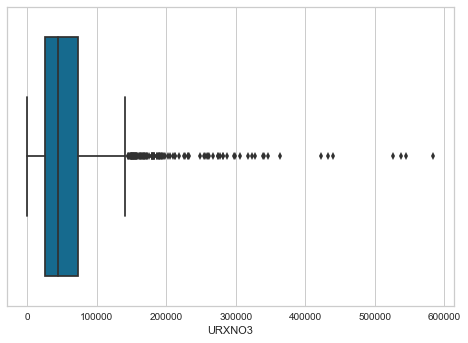

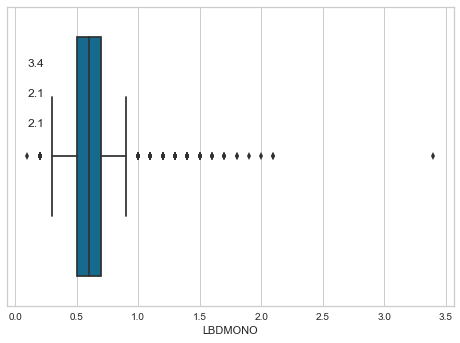

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


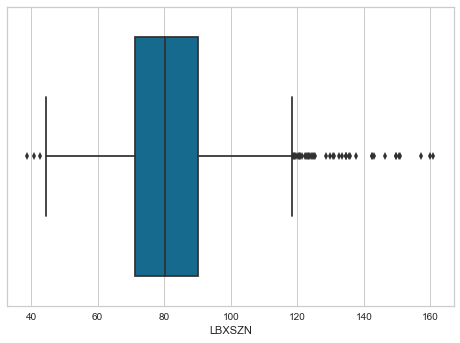

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


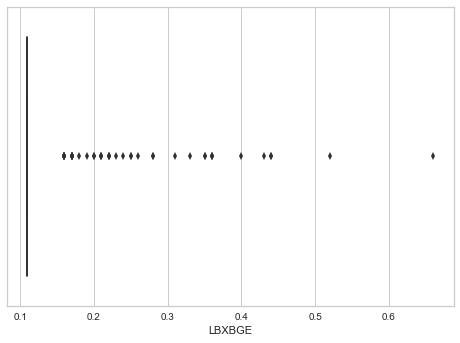

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


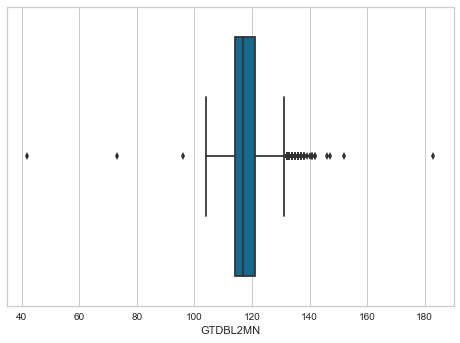

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


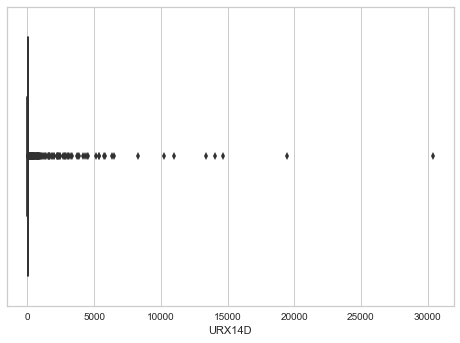

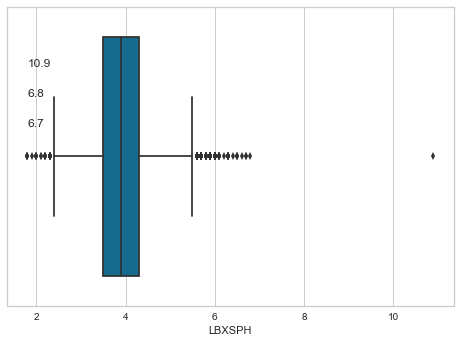

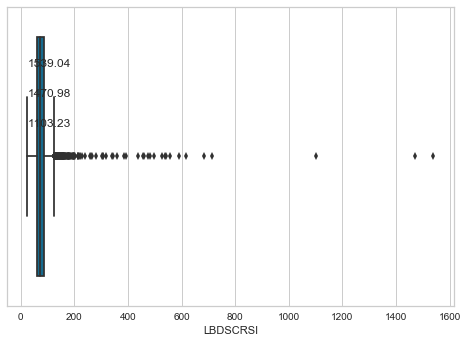

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


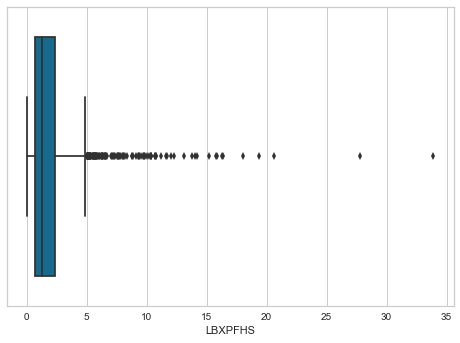

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


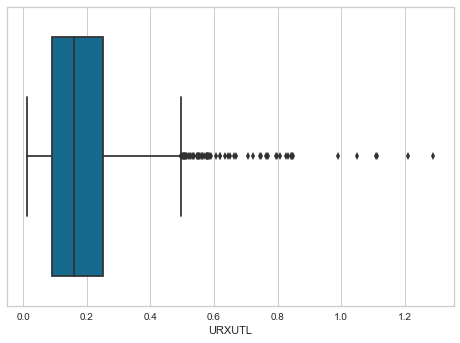

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


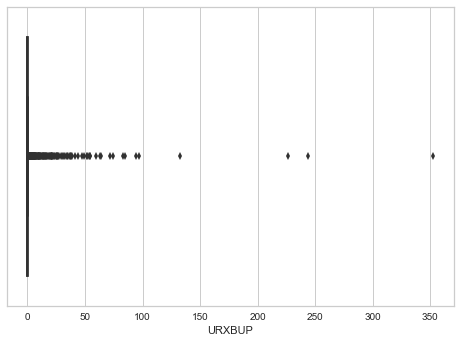

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


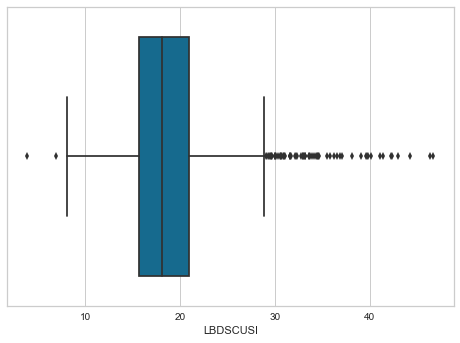

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


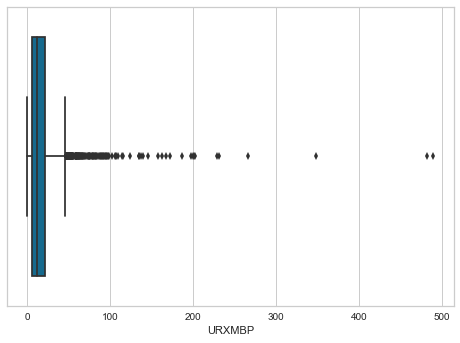

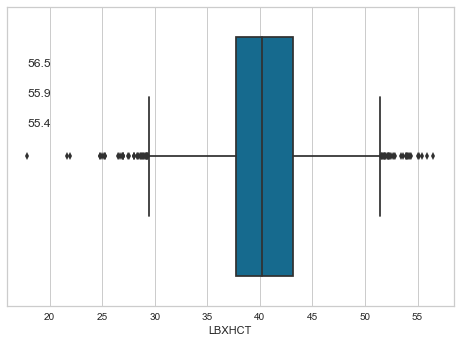

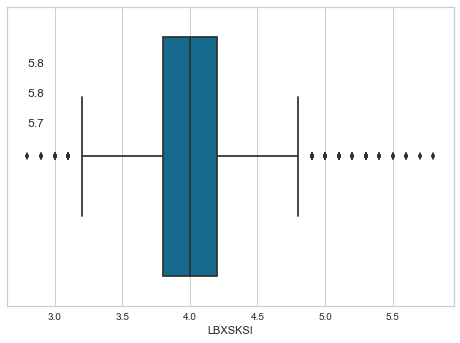

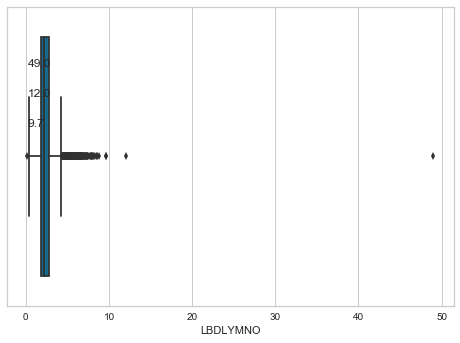

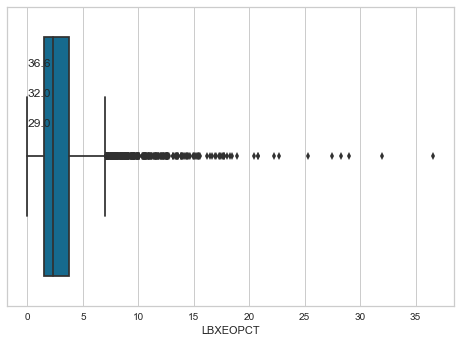

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


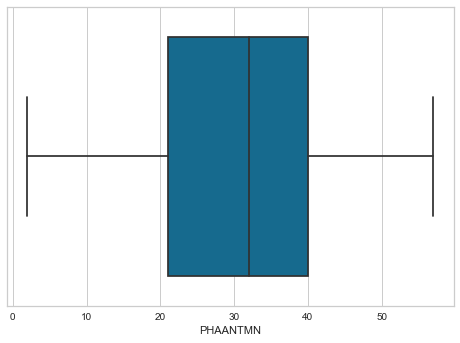

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


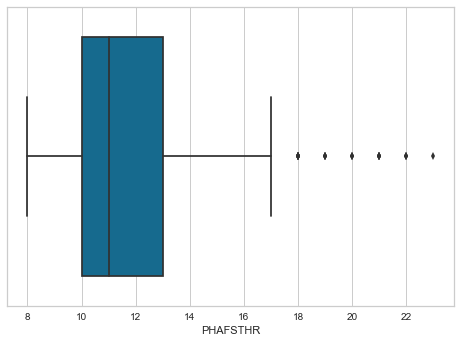

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


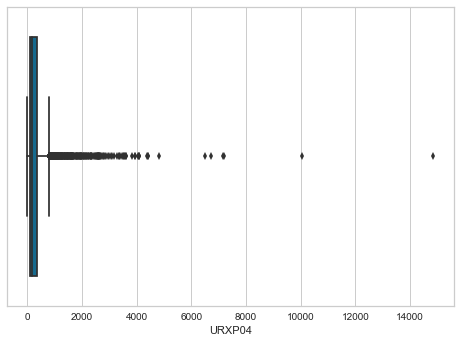

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


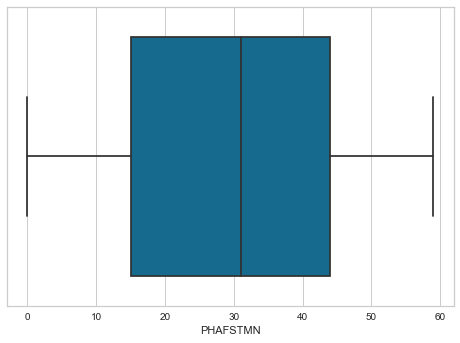

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


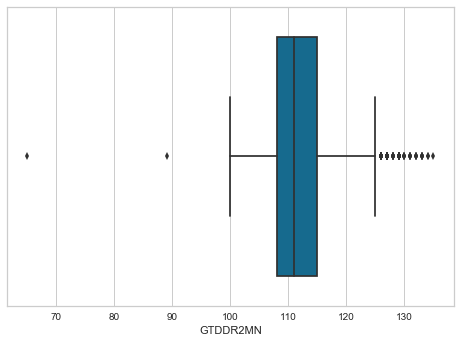

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


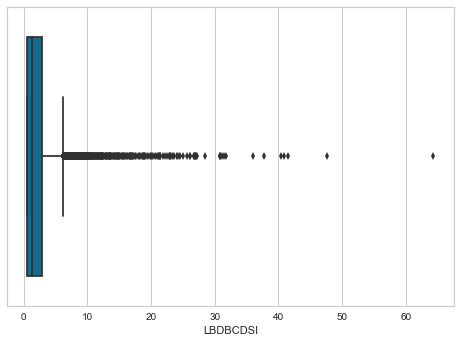

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


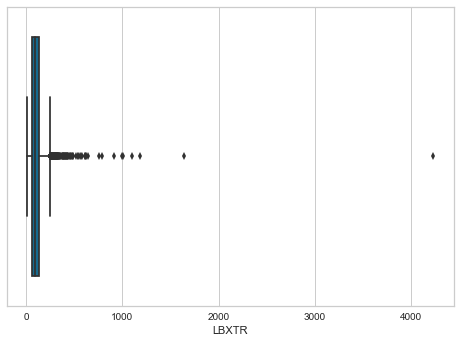

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


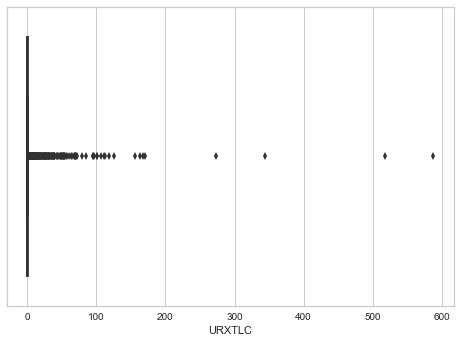

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


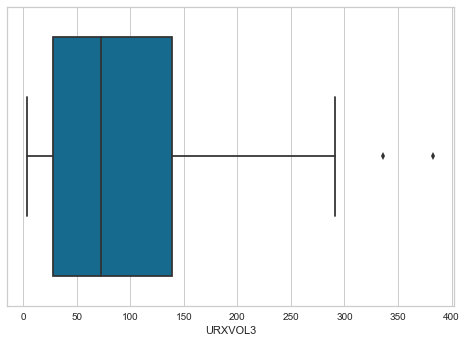

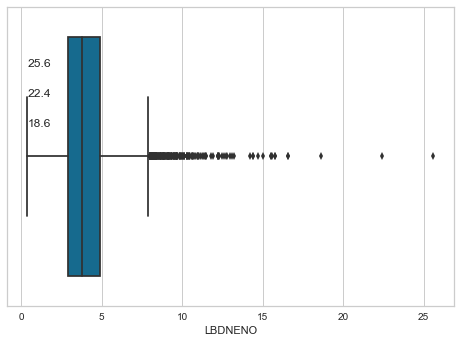

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


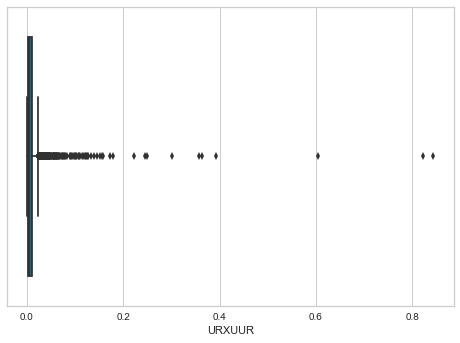

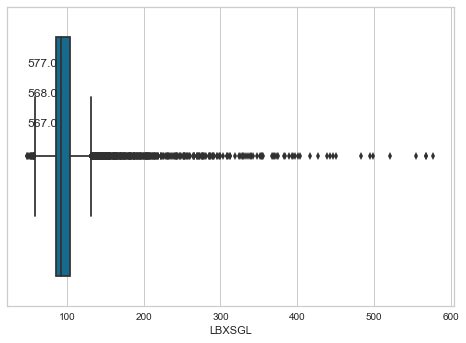

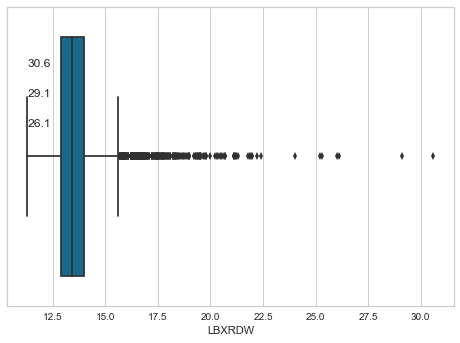

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


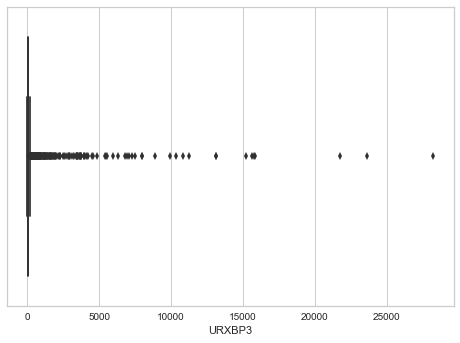

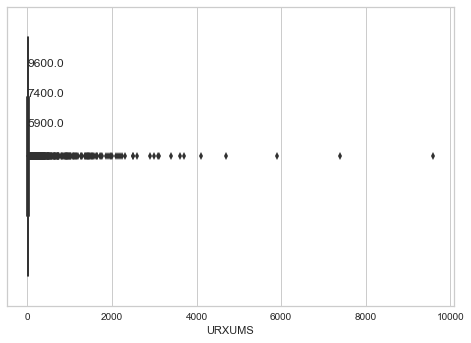

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


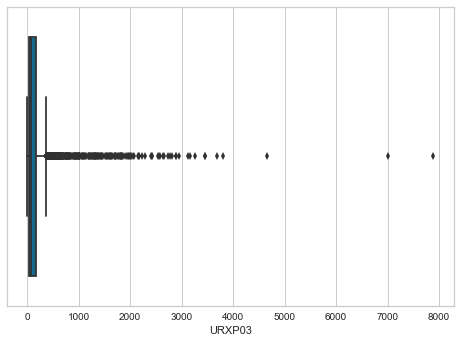

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


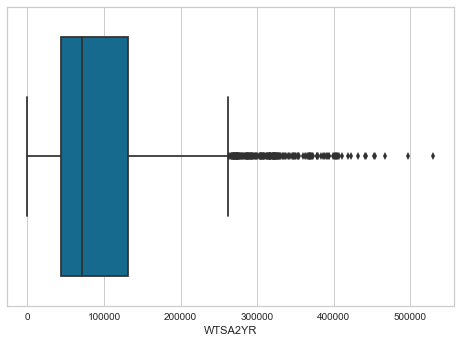

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


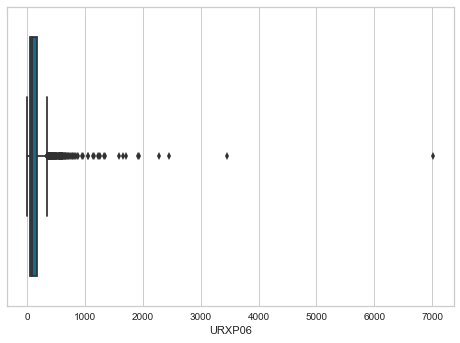

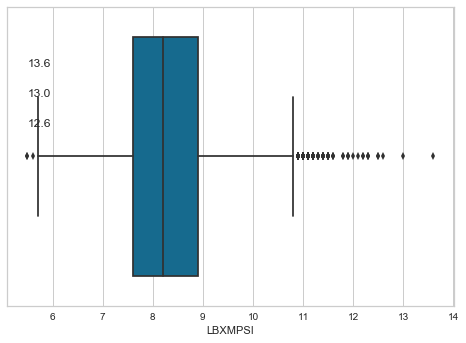

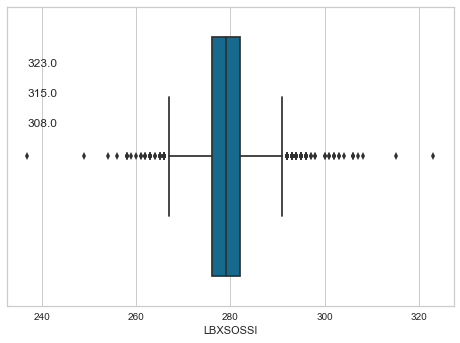

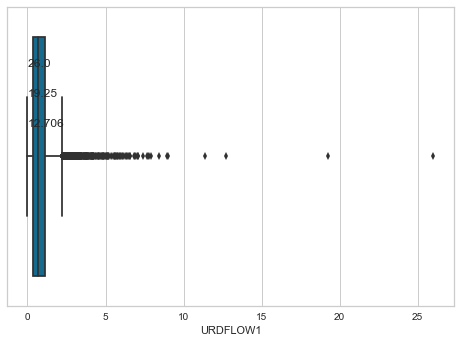

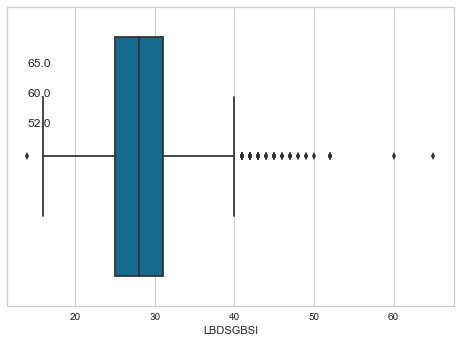

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


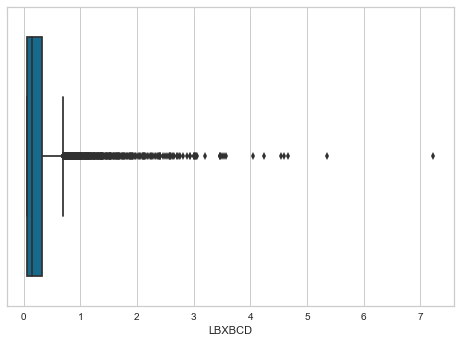

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


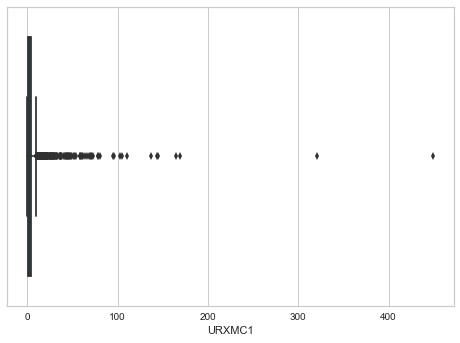

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


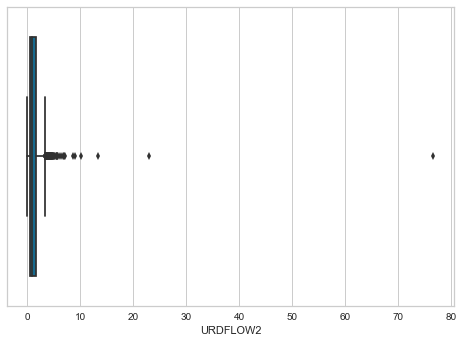

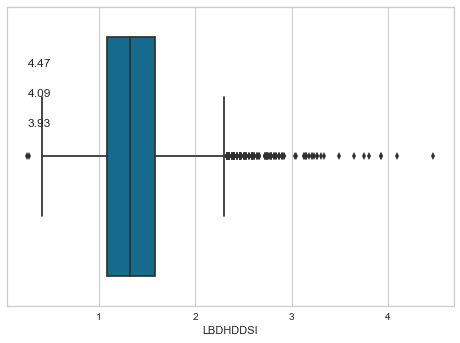

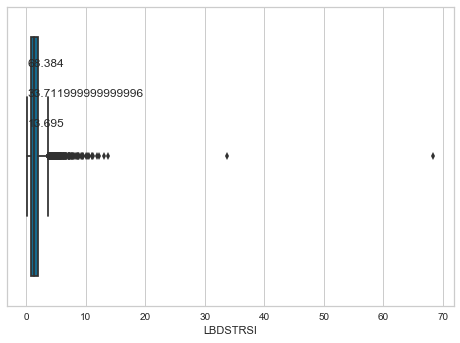

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


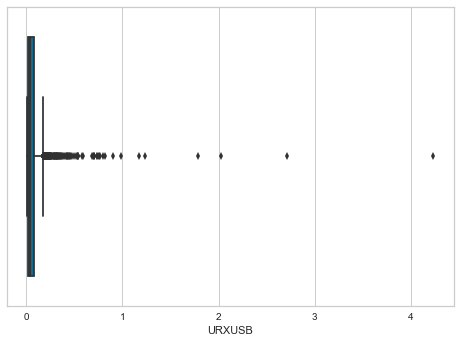

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


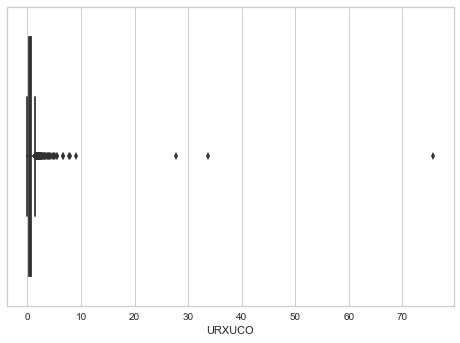

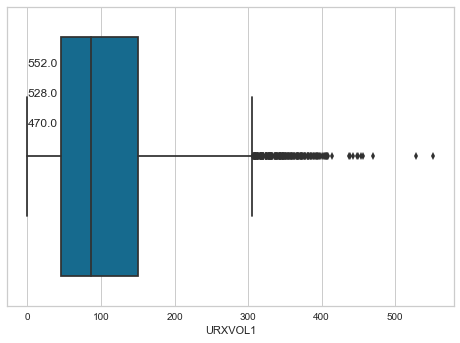

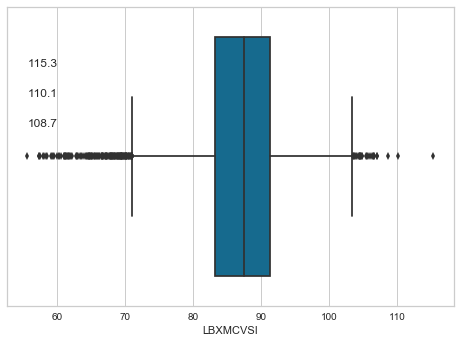

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


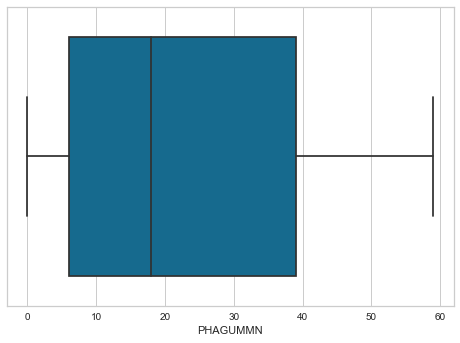

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


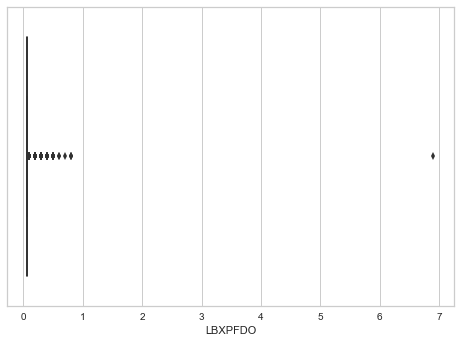

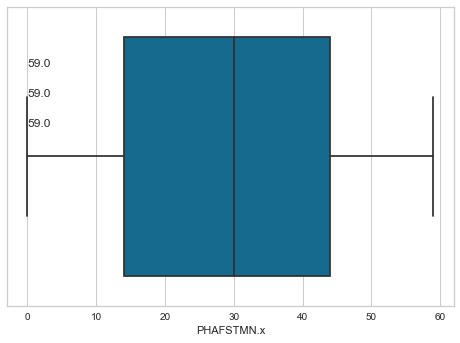

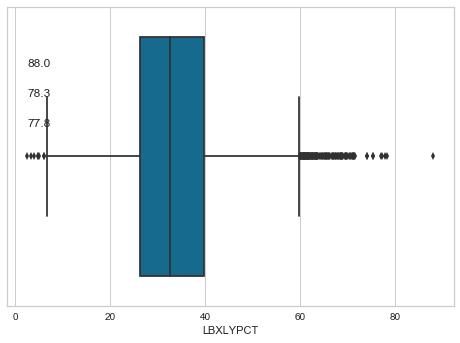

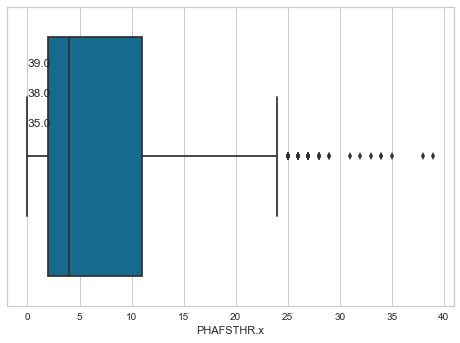

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


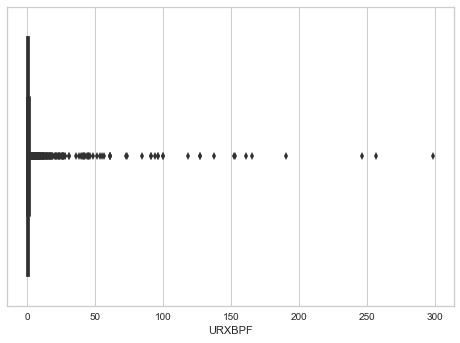

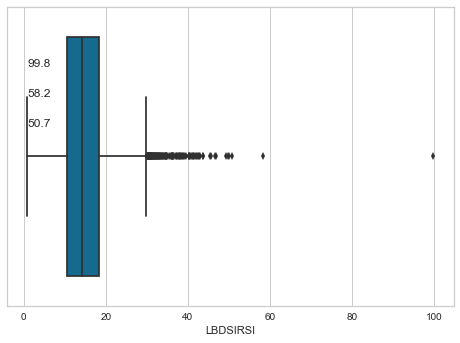

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


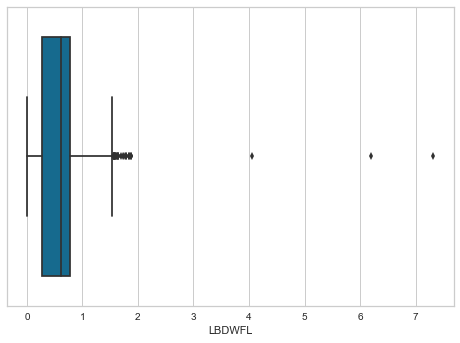

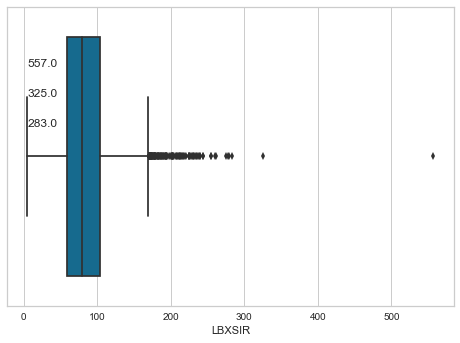

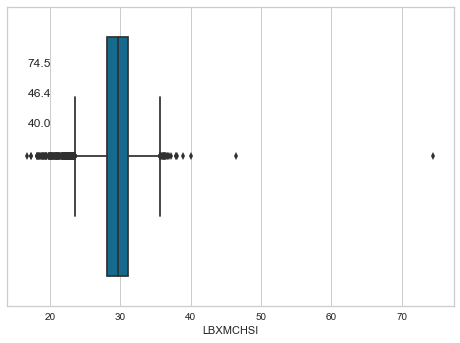

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


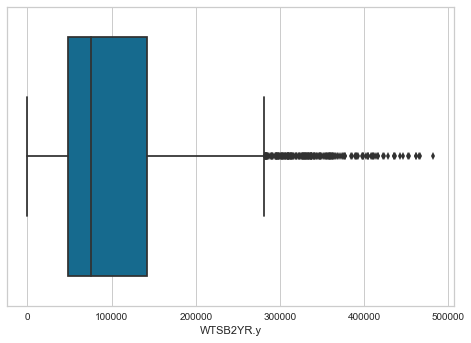

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


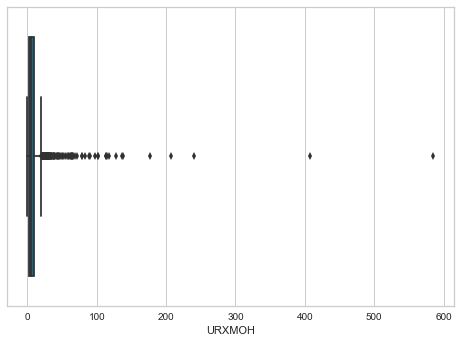

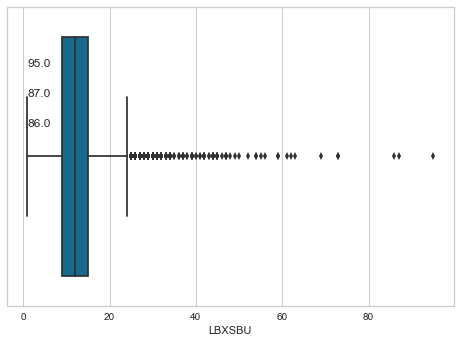

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


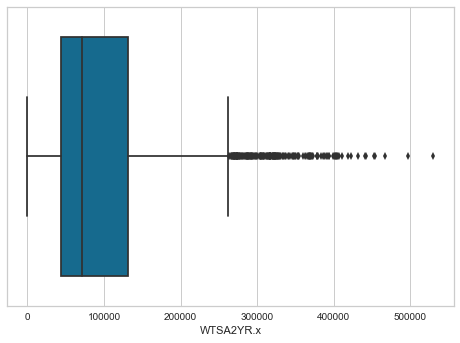

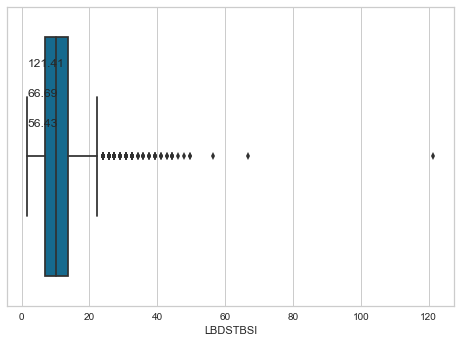

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


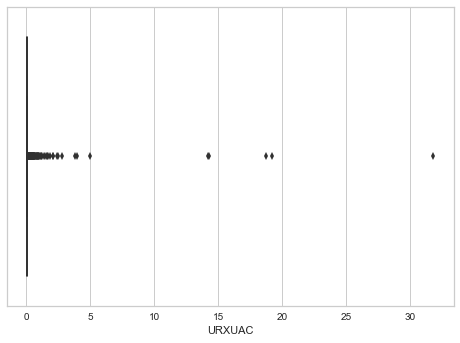

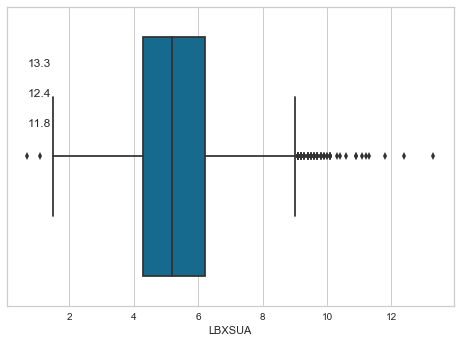

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


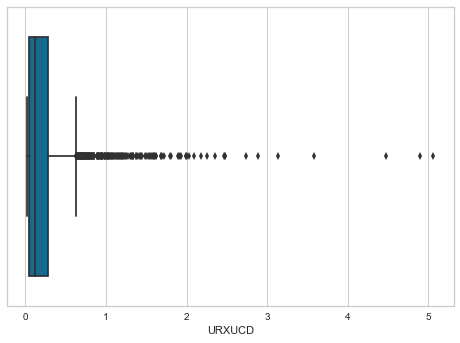

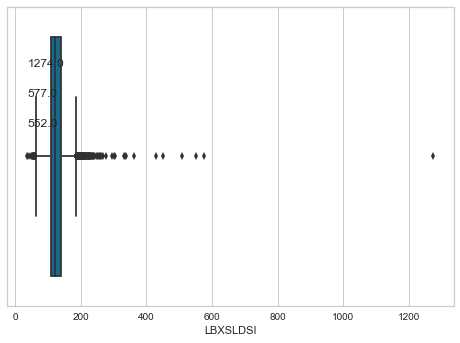

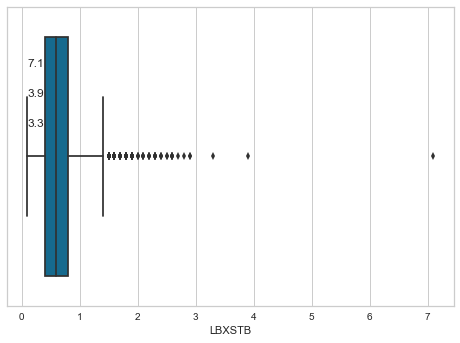

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


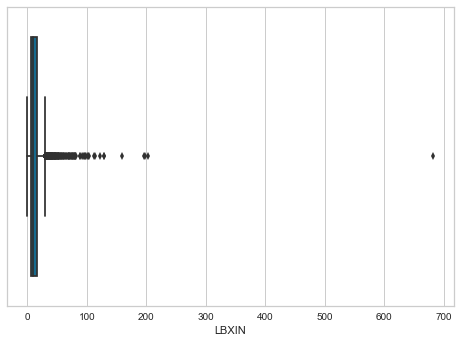

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


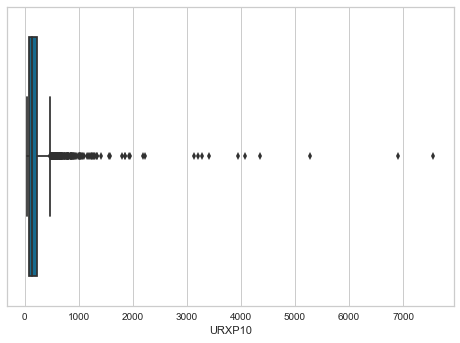

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


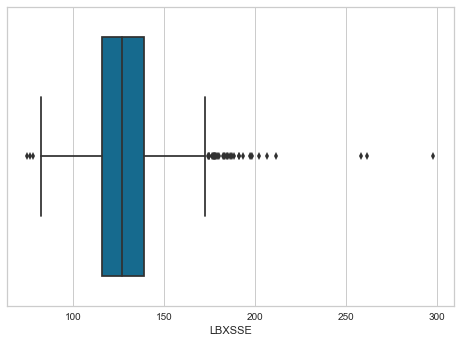

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


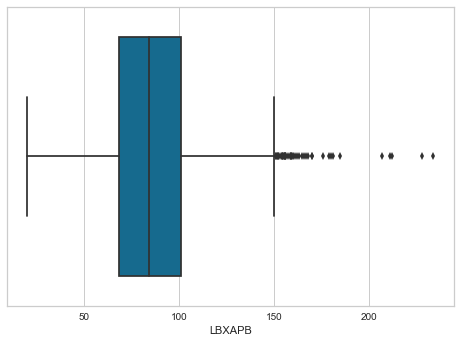

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


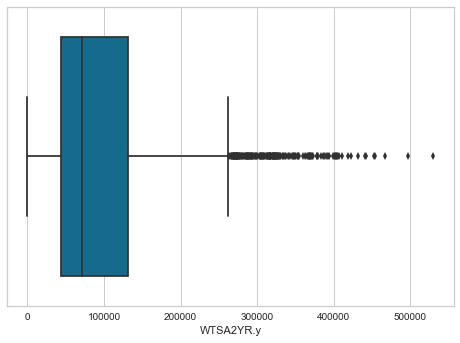

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


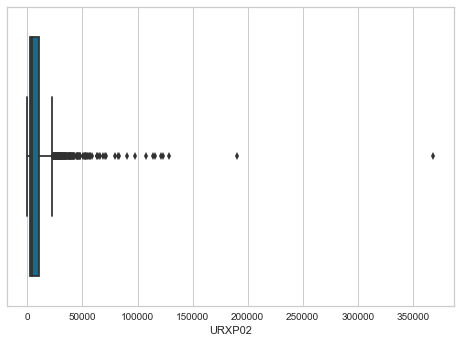

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


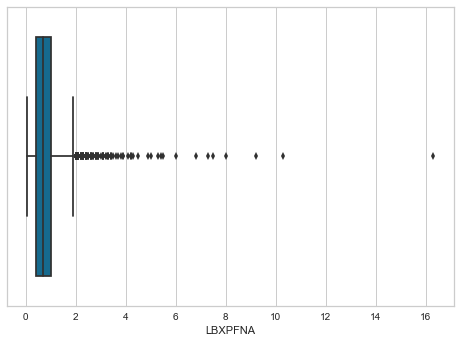

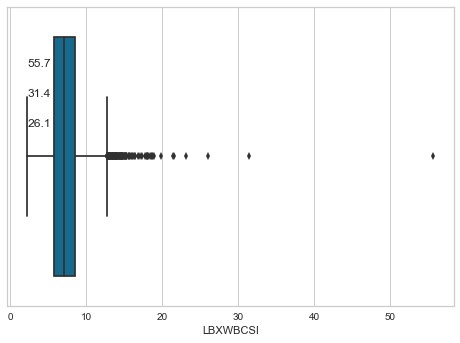

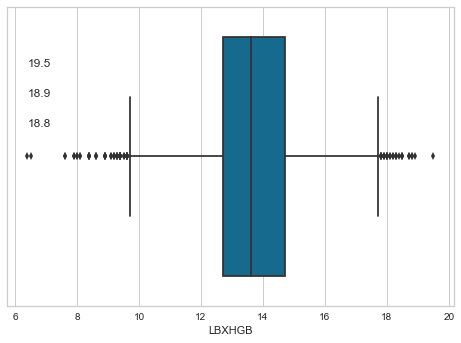

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


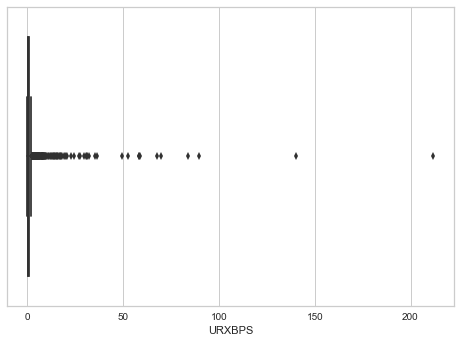

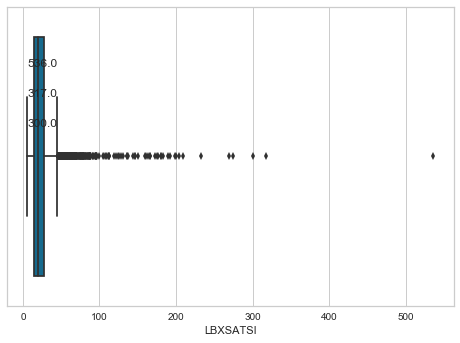

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


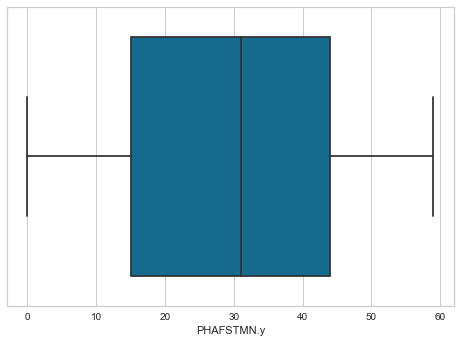

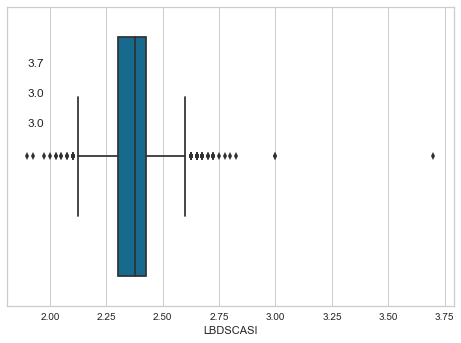

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


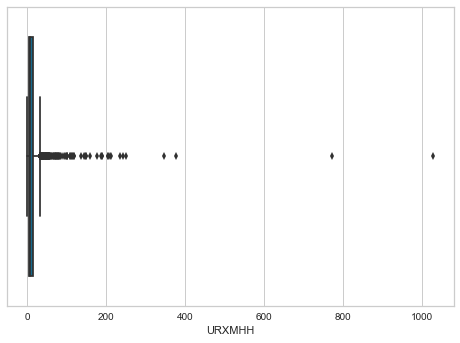

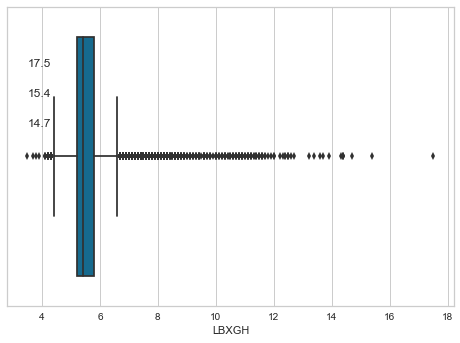

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


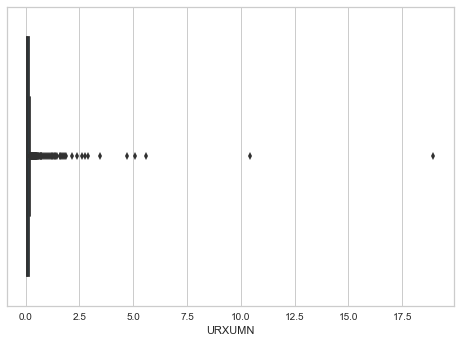

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


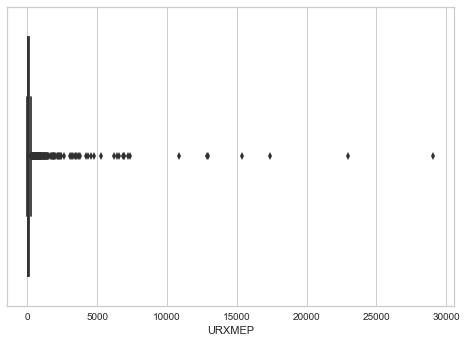

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


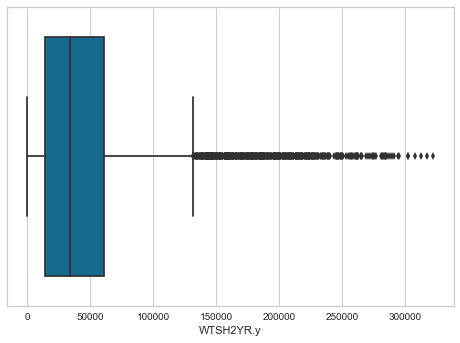

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


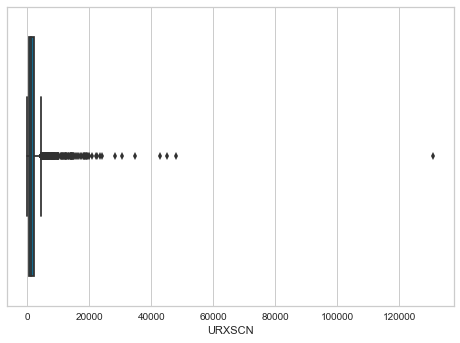

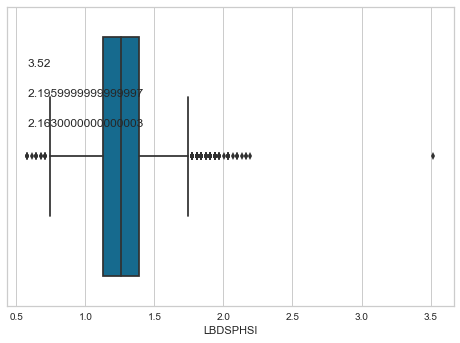

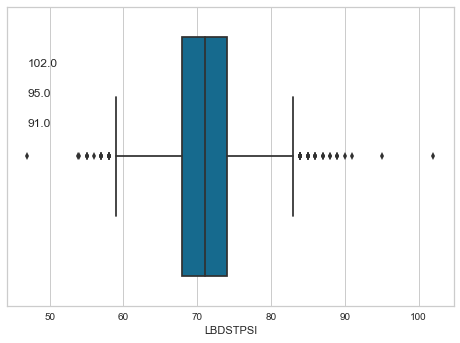

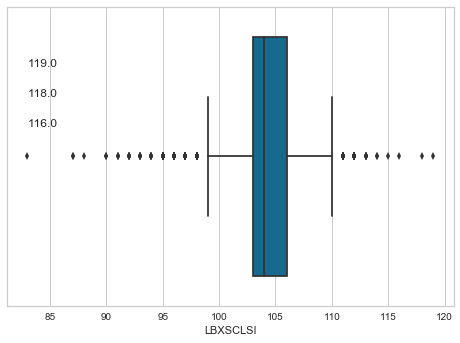

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


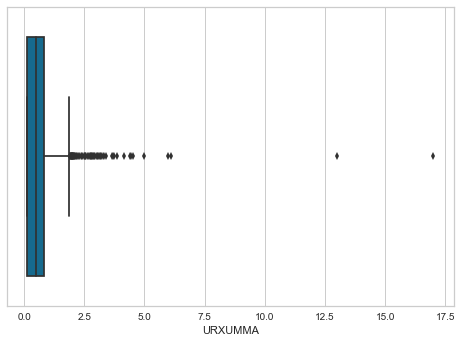

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


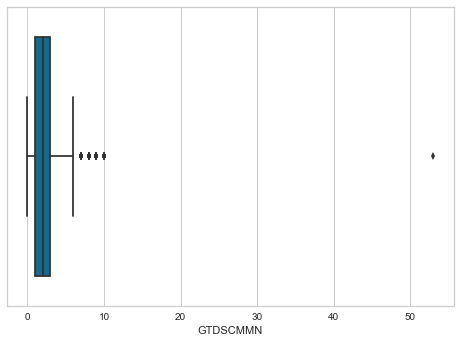

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


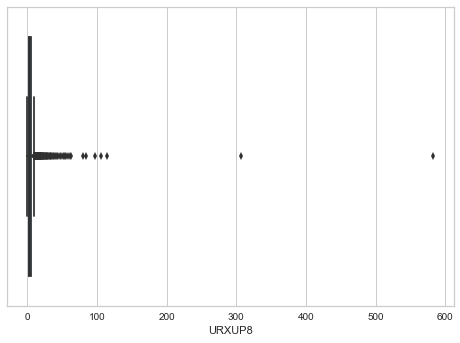

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


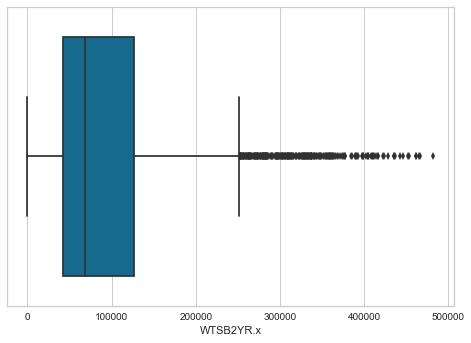

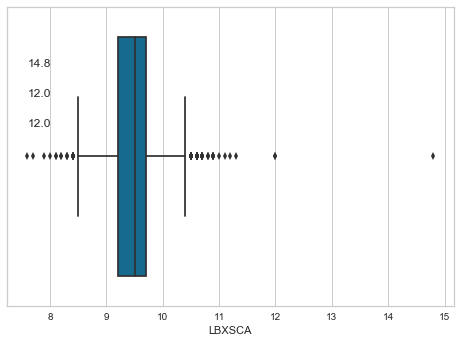

In [20]:
nhs_labs = clean_float(nhs_labs,list(set(labs_cont)^set(['SEQN'])))
visualize_float_columns(nhs_labs,list(set(labs_cont)^set(['SEQN'])))

## Combining and Merging dataframes into single df

In [21]:
#nhs_diet
nhs_demographic.drop(['SEQN'], axis = 1, inplace=True)
nhs_examination.drop(['SEQN'], axis = 1, inplace=True)
nhs_labs.drop(['SEQN'], axis = 1, inplace=True)
nhs_questionnaire.drop(['SEQN'], axis = 1, inplace=True)

#joining all dataframes into single
df = pd.concat([nhs_diet_new, nhs_demographic], axis=1, join='inner')
df = pd.concat([df, nhs_examination], axis=1, join='inner')
df = pd.concat([df, nhs_labs], axis=1, join='inner')
df = pd.concat([df, nhs_questionnaire], axis=1, join='inner')

In [22]:
df.shape

(9813, 1646)

In [23]:
df.describe()

SEQN       DBD100  SDDSRVYR     RIDSTATR     RIAGENDR  \
count   9813.000000  5399.000000    9813.0  9813.000000  9813.000000   
mean   78644.559971     1.652899       8.0     1.964231     1.509426   
std     2938.592266     0.811360       0.0     0.185723     0.499937   
min    73557.000000     1.000000       8.0     1.000000     1.000000   
25%    76092.000000     1.000000       8.0     2.000000     1.000000   
50%    78643.000000     1.000000       8.0     2.000000     2.000000   
75%    81191.000000     2.000000       8.0     2.000000     2.000000   
max    83731.000000     9.000000       8.0     2.000000     2.000000   

          RIDAGEYR    RIDAGEMN     RIDRETH1     RIDRETH3     RIDEXMON  \
count  9813.000000  650.000000  9813.000000  9813.000000  9813.000000   
mean     31.466320   10.390769     3.092734     3.291246     1.510140   
std      24.413015    6.874703     1.263960     1.614486     0.499923   
min       0.000000    0.000000     1.000000     1.000000     1.000000   
25%      10.000000    5.000000     2.000000     2.000000     1.000000   
50%      26.000000    9.000000     3.000000     3.000000     2.000000   
75%      52.000000   16.000000     4.000000     4.000000     2.000000   
max      80.000000   24.000000     5.000000     7.000000     2.000000   

          ...       WHD080U  WHD080L       WHD110       WHD120       WHD130  \
count     ...        9320.0   9813.0  4036.000000  4842.000000  2667.000000   
mean      ...          35.0     40.0   413.440287   567.920074   373.831646   
std       ...           0.0      0.0  1511.368399  1975.492188  1716.831150   
min       ...          35.0     40.0    75.000000    55.000000    50.000000   
25%       ...          35.0     40.0   140.000000   125.000000    63.000000   
50%       ...          35.0     40.0   165.000000   150.000000    66.000000   
75%       ...          35.0     40.0   198.000000   180.000000    70.000000   
max       ...          35.0     40.0  9999.000000  9999.000000  9999.000000   

            WHD140        WHQ150      WHQ030M       WHQ500       WHQ520  
count  5879.000000   5800.000000  9810.000000  9810.000000  9810.000000  
mean    315.447355    574.222069     2.553925     2.287564     1.741182  
std    1075.040013   7288.930842     0.783402     1.186966     0.701706  
min      85.000000     10.000000     1.000000     1.000000     1.000000  
25%     155.000000     25.000000     2.000000     1.000000     1.000000  
50%     185.000000     38.000000     3.000000     2.000000     2.000000  
75%     225.000000     53.000000     3.000000     3.000000     2.000000  
max    9999.000000  99999.000000     9.000000     9.000000     9.000000  

[8 rows x 1615 columns]

### Initial cleaning - Removing na's if in rows and columns from the merged dataframe

In [24]:
lst = df.columns[df.isna().all()].tolist()
df.dropna(axis=1, how='all',inplace=True)
df.dropna(axis=0, how='all',inplace=True)
df.shape

(9813, 1641)

### Output label assignment

According to WHO and American Diabetes Association, based on the below values, we can tell whether the person is either normoglycemic(i.e no risk of diabetes), prediabetic, and diabetic.
HbA1c:  LBXGH
normoglycemic <5.7%, pre-diabetic = 5.7%-6.4%, diabetic>6.4%; 
FPG: LBDGLUSI
normoglycemic <100 mg/dl, pre-diabetic = 100-125 mg/dl, diabetic>125 mg/dl; 
OGTT: LBDGLTSI
normoglycemic <140 mg/dl(7.7714), prediabetic = 140-200 mg/dl(7.7714-11.102), diabetic >200mg/dl(11.102) (American
Diabetes Association, 2014)

Apart from the above attributes, there are other variables in the dataset which tells whether the person was informed whether he had diabetes before, or prediabetes before. Using these, we are assigning output labels as 0-no diabetes, 1-prediabetes, 2-diabetic

In [25]:
df.loc[((df['LBXGH'] < 5.7) | (df['LBDGLTSI']<7.7714)), 'Diabetes'] = 0
df.loc[(((df['LBXGH'] >= 5.7) & (df['LBXGH'] <= 6.4)) | ((df['LBDGLTSI']>= 7.7714) & (df['LBDGLTSI']<= 11.102))), 'Diabetes'] = 1
df.loc[((df['LBXGH'] > 6.4) | (df['LBDGLTSI']>11.102)), 'Diabetes'] = 2

In [26]:
df.loc[((df.Diabetes.isna()) & (df.DIQ010 == 1)), 'Diabetes'] = 2
df.loc[((df.Diabetes.isna()) & (df.DIQ010 == 3)), 'Diabetes'] = 1
df.loc[((df.Diabetes.isna()) & (df.DIQ010 == 2)), 'Diabetes'] = 0

In [27]:
##removing the rows with nan diabetes values -- 122 rows will be deleted
df = df[np.isfinite(df['Diabetes'])]

In [28]:
df.shape

(9809, 1642)

In [29]:
df.Diabetes.value_counts()

0.0    7180
1.0    1710
2.0     919
Name: Diabetes, dtype: int64

Text(0, 0.5, 'Number of counts')

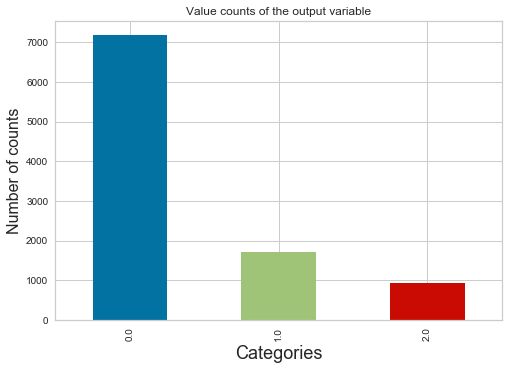

In [30]:
pd.value_counts(df['Diabetes']).plot(kind="bar", title='Value counts of the output variable')
plt.xlabel('Categories', fontsize=18)
plt.ylabel('Number of counts', fontsize=16)

### Dividing the merged df variables

In [31]:
cat_vars = ques_cat+diet_cat+demo_cat+exam_cat+labs_cat
cat_vars = [x for x in cat_vars if x not in lst]
num_vars = list(ques_cont)+list(diet_cont)+list(demo_cont)+list(exam_cont)+list(labs_cont)
num_vars = [x for x in num_vars if x not in lst]
obj_vars = list(set(df.columns)^set(cat_vars)^set(num_vars))

### Encoding categorical variables using Label Encoder

We are using Label Encoder because the models which we are going to use for feature selection performs best on label encoded categorical features. We did not use one hot encoding because, already the feature size was 1600 and using OHE will explode the number of features even more, and models performance might affect even more further

In [32]:
df_array = df.as_matrix(columns=cat_vars)
le = LabelEncoder()
for i in range(len(cat_vars)):   
     df_array[:,i] = le.fit_transform(df_array[:,i])
newdf=pd.DataFrame(df_array, columns=cat_vars)   

In [33]:
df_array1 = df.as_matrix(columns=obj_vars)
le1 = LabelEncoder()
for i in range(len(obj_vars)): 
    df_array1[:,i] = le1.fit_transform(df_array1[:,i].astype(str))
        
newdf1=pd.DataFrame(df_array1, columns=obj_vars)

In [34]:
newdf['SEQN'] = df['SEQN']
newdf1['SEQN'] = df['SEQN']

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9809 entries, 0 to 9812
Columns: 1642 entries, SEQN to Diabetes
dtypes: float64(1588), int64(23), object(31)
memory usage: 123.3+ MB


In [36]:
df.loc[df.SEQN.isin(newdf.SEQN), cat_vars] = newdf[cat_vars]
df.loc[df.SEQN.isin(newdf1.SEQN), obj_vars] = newdf1[obj_vars]

In [37]:
df_encoded = df.iloc[:9805]

In [38]:
df_encoded=df_encoded.dropna(axis=1,how='all')
df_encoded=df_encoded.dropna(axis=0,how='all')
df_encoded.shape

(9805, 1642)

## Dimensionality Reduction and variance check using PCA

In [39]:
X = df_encoded.drop(labels = ['Diabetes','LBXGH','LBDGLTSI','DIQ010','DIQ160'], axis=1).values
y = df_encoded['Diabetes'].values
X = StandardScaler().fit_transform(X)

In [40]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imp.fit_transform(X)

In [41]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df_encoded[['Diabetes']]], axis = 1)


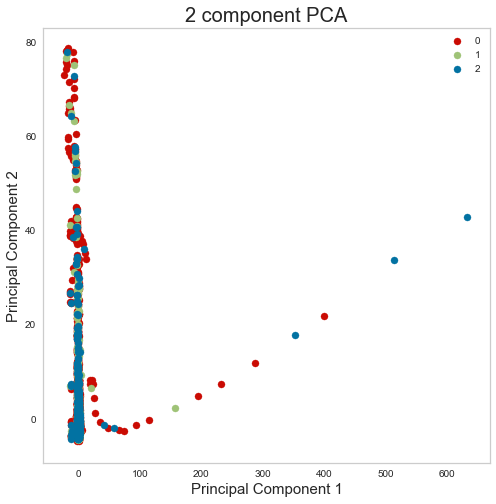

In [42]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1,2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Diabetes'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [43]:
pca.explained_variance_ratio_

array([ 0.09477823,  0.04650925])

From the above explained variance ratio, for components=2, it is hardly 12% which is not really helpful.

In [44]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
finalDf = pd.concat([principalDf, df_encoded[['Diabetes']]], axis = 1)


In [45]:
pca.explained_variance_ratio_

array([ 0.09477823,  0.04650925,  0.03082188])

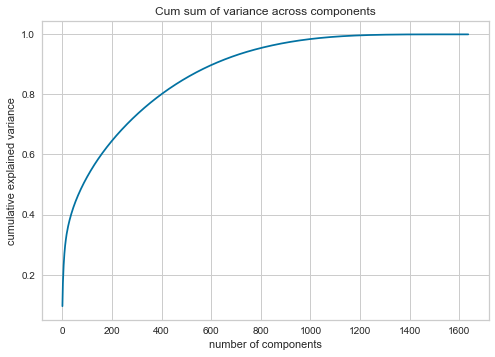

In [46]:
## obtain all the components and plot the cumulatie explained variance with respect to the number of components
pca =  PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cum sum of variance across components')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

After plotting the cumulative sum of variance over the number of components, to get a 90% variance, we should use atleast 1100 features which is very close to our actual size. We are not proceeding with dimensionality reduction now.

## Feature Selection using various ML models

### Linear regression with lasso
Lasso model when we input various features, will make the coefficients 0 which are not contributing to the output. But, our features are mostly categorical.

In [47]:
reg = LassoCV(cv=5, random_state=0).fit(X, y)
reg.score(X, y)

0.18712216554126604

In [48]:
(reg.coef_)

array([-0.        ,  0.01263868,  0.        , ..., -0.        ,
       -0.        ,  0.        ])

In [49]:
coefficients = pd.concat([pd.DataFrame(df_encoded.columns),pd.DataFrame(np.transpose(reg.coef_))], axis = 1)

In [50]:
coefficients.columns = ['column','coeff']

Picking up the top 20 features

In [51]:
lasso_75 = coefficients.sort_values('coeff',ascending = False).head(75)
features_lasso = list(lasso_75.column)
features_lasso[:21]

['BPACSZ',
 'OHDEXSTS',
 'OHX24TC',
 'LBXHBS',
 'LBDBANO',
 'OHX30TC',
 'LBXSGL',
 'OHX28CTC',
 'OHX08TC',
 'OHX10CTC',
 'OHX18SE',
 'MGDEXSTS',
 'URDMIBLC',
 'DBD100',
 'OHX19TC',
 'OCQ380',
 'DMDHHSZE',
 'OHX05TC',
 'OHX13TC',
 'PFQ061E',
 'OHQ620']

### Random forests for predicting top 25 features
Random forests are good estimators for the output feature importance. We are selecting the top 25.

In [52]:
param_grid = dict()
clf = RandomForestClassifier(n_estimators=500, random_state=0)
grid_search = GridSearchCV(clf, param_grid=param_grid, verbose=3,scoring='accuracy').fit(X, list(y))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... , score=0.7124502906087489, total=  39.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.4s remaining:    0.0s


[CV] ....................... , score=0.7362301101591188, total=  42.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s


[CV] ....................... , score=0.7356181150550796, total=  43.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.2min finished


In [53]:
clf = grid_search.best_estimator_
clf.fit(X,list(y))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [54]:
d = {}
for feature in zip(df_encoded.columns,clf.feature_importances_):
    d[feature[0]]=feature[1]
    

sorted_d = sorted(d.items(), key=operator.itemgetter(1),reverse=True)
dic = sorted_d[:75]
lst_rf = list(zip(*dic))

In [55]:
features_rf = lst_rf[0]
features_rf[:25]

('OHX18CTC',
 'OHX19CTC',
 'OHX31CTC',
 'OHX30CTC',
 'OHX14CTC',
 'OHX03CTC',
 'OHX02CTC',
 'BPACSZ',
 'OHX15CTC',
 'DIQ175V',
 'PEASCTM1',
 'OHX13TC',
 'LBXPLTSI',
 'OHX04TC',
 'OHX04CTC',
 'WTINT2YR',
 'BMXARMC',
 'BMXWT',
 'OHX08TC',
 'WTMEC2YR',
 'LBXMCVSI',
 'OHX11CTC',
 'LBXLYPCT',
 'OHX13CTC',
 'OHX06CTC')

## Using complex wrapper methods- RandomForests with Boruta
Modifying the random forests using Boruta. This is a good model for categorical features as 70% of our features are categorical. For each iteration, Boruta goes through the features and either accept or reject them.

In [56]:
rfc = RandomForestClassifier(n_estimators=200, n_jobs=4, class_weight='balanced', max_depth=6)
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2)
df2 = df_encoded.drop(labels = ['Diabetes','LBXGH','LBDGLTSI','DIQ010','DIQ160','SEQN'], axis=1)

x=imp.fit_transform(df2.values)
boruta_selector.fit(x,list(df_encoded['Diabetes'].values))
print (boruta_selector.n_features_)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	1636
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	1636
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	1636
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	1636
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	1636
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	1636
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	1636
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	105
Rejected: 	1531
Iteration: 	9 / 100
Confirmed: 	46
Tentative: 	59
Rejected: 	1531
Iteration: 	10 / 100
Confirmed: 	46
Tentative: 	59
Rejected: 	1531
Iteration: 	11 / 100
Confirmed: 	46
Tentative: 	59
Rejected: 	1531
Iteration: 	12 / 100
Confirmed: 	46
Tentative: 	51
Rejected: 	1539
Iteration: 	13 / 100
Confirmed: 	46
Tentative: 	51
Rejected: 	1539
Iteration: 	14 / 100
Confirmed: 	46
Tentative: 	51
Rejected: 	1539
Iteration: 	15 / 100
Confirmed: 	46
Tentative: 	51
Rejected: 	1539
Iteration: 	16 / 1

In [57]:
(boruta_selector.ranking_).shape
print ('\n Top %d features:' % boruta_selector.n_features_)
df_boruta = df2.head(boruta_selector.n_features_)
features_boruta = df_boruta.columns


 Top 46 features:


In [58]:
boruta_selector.ranking_

array([  15, 1551, 1374, ...,  731,  521,  735])

### Lightbgm
LightGBM is one of the best performers for categorical features. This is the reason we are using it for better performance.

Plot feature importances…


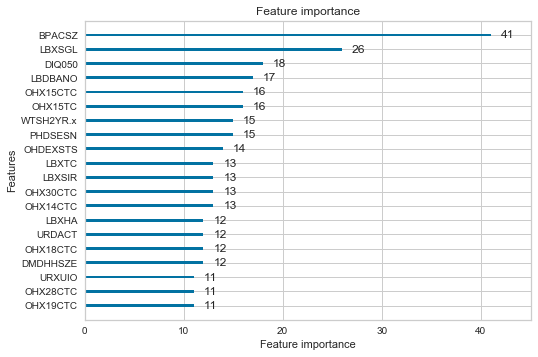

In [59]:
df_new = df_encoded.drop(labels = ['Diabetes','LBXGH','LBDGLTSI','DIQ010','DIQ160','SEQN'], axis=1)
ob_vars = df_new.select_dtypes(include=['object'])
for i in ob_vars:
    df_new[i] = df_new[i].astype(str).astype(float)
lbg_cat_vars = list(set(cat_vars)^set(['LBXGH','LBDGLTSI','DIQ010','DIQ160']))
lst = ['LBXGH','LBDGLTSI','DIQ010','DIQ160']
lbg_cat_vars.remove('LBDGLTSI')
lbg_cat_vars.remove('LBXGH')
d_train = lgb.Dataset(df_new, label=df_encoded['Diabetes'])
param = {'max_depth': 5, 'learning_rate' : 0.1, 'num_leaves': 900, 'n_estimators': 100}
model2 = lgb.train(params=param,train_set=d_train, categorical_feature=lbg_cat_vars)
print('Plot feature importances…')
ax = lgb.plot_importance(model2, max_num_features=20)
plt.show()

In [60]:
lst = []
for f in range(len(model2.feature_importance())):
    val=list(model2.feature_importance())[f]
    if val!=0:
        lst.append(list(model2.feature_name())[list(model2.feature_importance()).index(val)])


In [61]:
features_lgb = list(set(lst))

In [62]:
features_lgb

['OHDEXSTS',
 'DMDYRSUS',
 'INDHHIN2',
 'BMXWAIST',
 'BPXSY2',
 'BPACSZ',
 'LBXSGL',
 'PHDSESN',
 'MGQ100',
 'DMDHHSIZ',
 'DMDHHSZE',
 'RIDEXMON',
 'MGDEXSTS',
 'RIDAGEMN',
 'LBDBANO',
 'DIQ050',
 'DBD100',
 'OHX15TC',
 'OHX14CTC',
 'RIAGENDR']

### Final Selecting features from the above models

We have analysed the above outputs, and Using some domain expertise, and referring to various research done on diabetes, we have found that the intersection of the top features given by boruta and lightGBM seemed more accurate. 

In [63]:
features = [features_lasso, features_rf, features_boruta, features_lgb]

In [64]:
set(features_boruta).intersection(features_lgb)

{'BMXWAIST',
 'BPACSZ',
 'BPXSY2',
 'DBD100',
 'DIQ050',
 'DMDHHSIZ',
 'DMDHHSZE',
 'DMDYRSUS',
 'INDHHIN2',
 'LBDBANO',
 'LBXSGL',
 'MGDEXSTS',
 'MGQ100',
 'OHDEXSTS',
 'OHX14CTC',
 'OHX15TC',
 'PHDSESN',
 'RIAGENDR',
 'RIDAGEMN',
 'RIDEXMON'}

About the selected features:
These are the output features that are given by our machine learning models.
Age, gender, race are very common things that have effect on any disease condition. They have significant important towards developing any medical condition. Some of the interesting things we have observed is- whether any of the immediate family members have diabetes.The risk of person's immediate family having diabetes, it increases the risk of person getting it by even more. One more interesting feature we observed is the persons overall dental hygiene contributing to the output. Initially we thought it to be a non relevant features, but then after  some ground work, we understood that oral dental hygiene can be a good predictor, because dental hygiene contributes to the changes in glucose level in the body, which inturn causes diabetes.  Some other important features our models have given are related to income to poverty line, and education level. Though these all are not the actual predictors of pre diabetes and diabetes, they are carrying a significant weightage towards the output. Apart from the useful features, our models have also given some irrelavant or atleast not yet proven relation to diabetes. We are not discarding these, as they might require further analysis whether they are important or not.

In [65]:
list(set(features_boruta).intersection(features_lgb))
selected_features= ['BMXWAIST',
 'BPACSZ',
 'BPXSY2',
 'DBD100',
 'DIQ050',
 'DMDHHSIZ',
 'DMDHHSZE',
 'DMDYRSUS',
 'INDHHIN2',
 'LBDBANO',
 'LBXSGL',
 'MGDEXSTS',
 'MGQ100',
 'OHDEXSTS',
 'OHX14CTC',
 'OHX15TC',
 'PHDSESN',
 'RIAGENDR',
 'RIDAGEMN',
 'RIDEXMON']

In [66]:
selected_features.append('Diabetes')
selected_features.append('SEQN')
df_model = df_encoded[selected_features]

In [67]:
X = X = df_model.drop(labels = ['Diabetes'], axis=1).values
y = df_encoded['Diabetes'].values
X = StandardScaler().fit_transform(X)

In [68]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imp.fit_transform(X)

## Exploratory Data Analysis on selected features

In [69]:
selected_features

['BMXWAIST',
 'BPACSZ',
 'BPXSY2',
 'DBD100',
 'DIQ050',
 'DMDHHSIZ',
 'DMDHHSZE',
 'DMDYRSUS',
 'INDHHIN2',
 'LBDBANO',
 'LBXSGL',
 'MGDEXSTS',
 'MGQ100',
 'OHDEXSTS',
 'OHX14CTC',
 'OHX15TC',
 'PHDSESN',
 'RIAGENDR',
 'RIDAGEMN',
 'RIDEXMON',
 'Diabetes',
 'SEQN']

In [70]:
categorical_features = list(set(selected_features).intersection(cat_vars))
print('categorical: ',categorical_features)
continuos_features = list(set(selected_features).intersection(num_vars))
print('continous: ',continuos_features)

categorical:  ['OHDEXSTS', 'BPACSZ', 'PHDSESN', 'DIQ050', 'DMDHHSIZ', 'DMDHHSZE', 'RIDEXMON', 'MGDEXSTS', 'MGQ100', 'LBDBANO', 'DBD100', 'OHX15TC', 'RIAGENDR']
continous:  ['INDHHIN2', 'BMXWAIST', 'DMDYRSUS', 'BPXSY2', 'LBXSGL', 'SEQN', 'RIDAGEMN']


In [71]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9805 entries, 0 to 9808
Data columns (total 22 columns):
BMXWAIST    8653 non-null float64
BPACSZ      9805 non-null object
BPXSY2      7405 non-null float64
DBD100      9805 non-null object
DIQ050      9805 non-null object
DMDHHSIZ    9805 non-null object
DMDHHSZE    9805 non-null object
DMDYRSUS    1835 non-null float64
INDHHIN2    9675 non-null float64
LBDBANO     9805 non-null object
LBXSGL      6552 non-null float64
MGDEXSTS    9805 non-null object
MGQ100      9805 non-null object
OHDEXSTS    9805 non-null object
OHX14CTC    9805 non-null object
OHX15TC     9805 non-null object
PHDSESN     9805 non-null object
RIAGENDR    9805 non-null object
RIDAGEMN    649 non-null float64
RIDEXMON    9805 non-null object
Diabetes    9805 non-null object
SEQN        9805 non-null int64
dtypes: float64(6), int64(1), object(15)
memory usage: 2.0+ MB


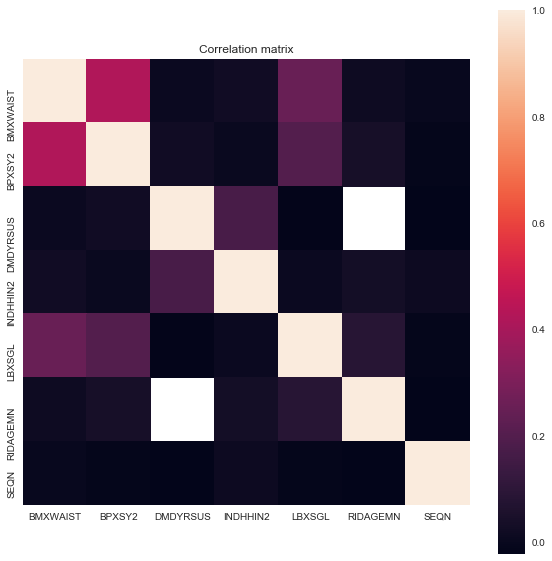

In [72]:
corr = df_model.corr()
plt.figure(figsize=(10,10))
plt.title('Correlation matrix')
sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values, square=True)

In [73]:
pandas_profiling.ProfileReport(df_model)

## Doing the Test Train split

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [75]:
df_X = pd.DataFrame(X)
df_y = pd.DataFrame(y)

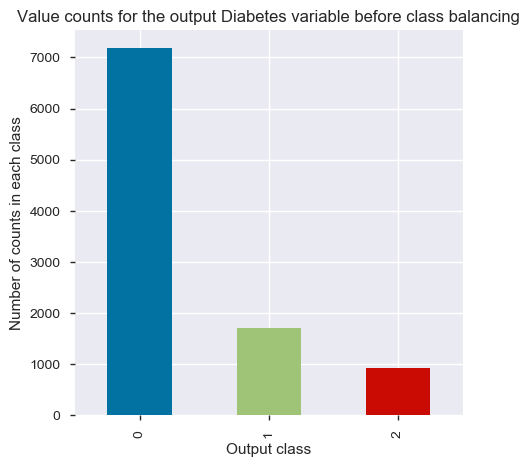

In [76]:
plt.figure(figsize=(5,5))
plt.title('Value counts for the output Diabetes variable before class balancing')
plt.xlabel('Output class')
plt.ylabel('Number of counts in each class')
pd.value_counts(df_y[0]).plot(kind="bar", colors=['b','g','r'])

In [77]:
np.unique(y_train)

array([0, 1, 2], dtype=object)

## Data Balancing
Now moving onto the predicting part of the project. Once after selecting the features, we have done some exploratory
data analysis part by plotting variance between features, imputing data, and then we have done test train split for the models.
After our analysis, we realized that our output feature is highly imbalanced, with one class more data points that is majority class
and the rest two are minority.
The problem with this is, models may tend to do very well predicting the majority class, but they won't do well in minority classes.
And in our case, the predicting the minority classes that is diabetic and pre diabetic is extremely important.
We have used synthetic minority over-sampling technique to balance our data before we input to the machine learning models. 
These are the class distributions before and after the balancing is done using SMOTE.
The output variable is heavily imbalanced. We should use the balancing techniques to modify the data for the better models prediction. We have choosen SMOTE technique to do our data balancing.

In [78]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [79]:
## Instantiate smote and balance training data only
sm = SMOTE()
X_res, y_res = sm.fit_resample(X_train, y_train)

## Compute and print percentage of high quality wine after balancing
print('Percentage of high quality counts in the balanced data:{}%'.format((y_res==1).sum()/X_res.shape[0]*100))

Percentage of high quality counts in the balanced data:33.33333333333333%


In [80]:
df_X_smote = pd.DataFrame(X_res)
df_y_smote = pd.DataFrame(y_res)

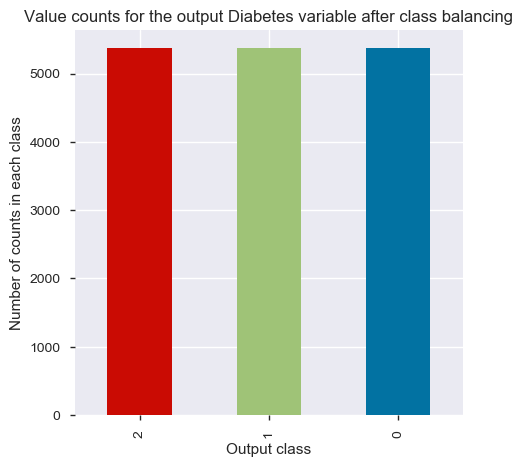

In [81]:
plt.figure(figsize=(5,5))
plt.title('Value counts for the output Diabetes variable after class balancing')
plt.xlabel('Output class')
plt.ylabel('Number of counts in each class')
pd.value_counts(df_y_smote[0]).plot(kind="bar", colors=['r','g','b'])

## Dimensionality Reduction with PCA
Also we have used PCA to understand the variance in the data and reduce the dimensionality.
Before feature selection, PCA with 2 components hardly had any variance. 
But after feature selection, PCA with 2 components has good variance. And we have plotted the cumulative sum
of variance across all the components. To acheive 90% variance, we should use atleast 13 components.


In [82]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df_encoded[['Diabetes']]], axis = 1)

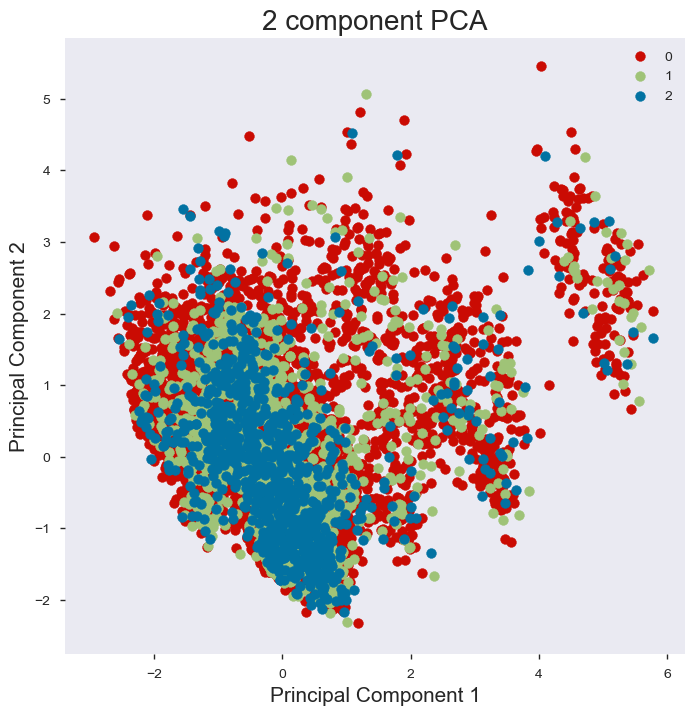

<Figure size 500x500 with 0 Axes>

In [83]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1,2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Diabetes'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
plt.figure(figsize=(5,5))
ax.legend(targets)
ax.grid()

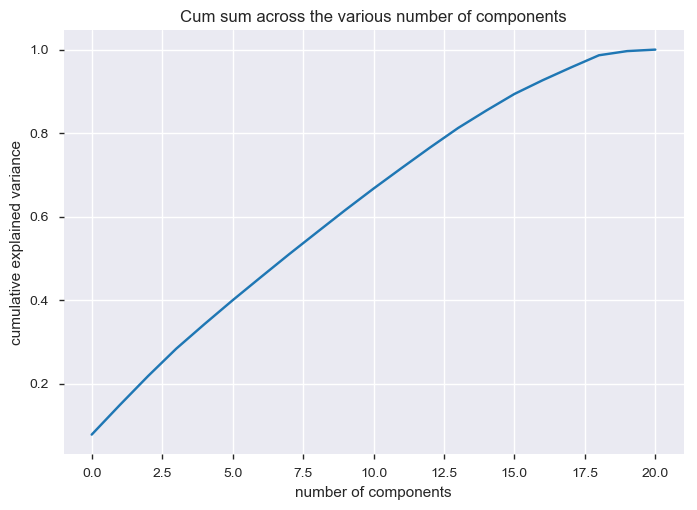

In [84]:
## obtain all the components and plot the cumulatie explained variance with respect to the number of components
pca =  PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cum sum across the various number of components')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

To get 90% variance, we atleast need 13 features. 

## Model Training and Evaluation
After cleaning, and transforming the data into machine learning ready, we have used various classifiers to predict our outputs.
Starting with the naive bayes as our baseline classfier, we moved on to complex non linear classfiers such as decision trees,
SVM, Logistic regression with Lasso and Ridge regularization, and ensemble models random forests, and XGBoost.

Each classifier is traied using grid search cv by passing the hyper parameters for tuning. 
As ours is multi class classification problem, we have used OneVsRestClassifier in the grid search cv and passed 
our models into it for hyper parameter tuning. 
Once we got the best model out of the grid search cv, we have fitted on our train data and predicted on the test data
split which we have created before. 

In [85]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

In [86]:
# Binarize the output
y_res = label_binarize(y_res, classes=[0, 1, 2])
y_test = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test.shape[1]

In [87]:
data_dict = {}
data_dict['X_train'] = X_res
data_dict['y_train'] = y_res
data_dict['X_test'] = X_test
data_dict['y_test'] = y_test

In [88]:
default_seed = 1

## Fitting various models

In [89]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                           metric='f1_micro',
                          model_name = None,
                          n_splits=3,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts  
      - metric = scoring
    '''
        
    out = {} # output dictionary
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']  
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------
    # Learn to predict each class against the other
    cv_model = GridSearchCV(OneVsRestClassifier(model, n_jobs=-1), cv_parameters, n_jobs=-1,
                            scoring=metric, cv=n_splits)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
        # Check whether any of the CV parameters are on the edge of
    # the search space
    opt_params_on_edge = find_opt_params_on_edge(cv_model)
    out.update({'search_on_edge':opt_params_on_edge})
    
    # Find out how different the scores are for the different values
    # tested for by cross-validation. If they're not too different, then
    # even if the parameters are off the edge of the search grid, we should be ok
    score_variation = find_score_variation(cv_model)
    out.update({'score_variation':score_variation})
    
    out.update({'all_cv_scores':cv_model.cv_results_['mean_test_score']})
    
    out.update({'model':best_model})
    
    # --------------------------
    #   Step 4 - Print to Screen
    # --------------------------
    if print_to_screen:
        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")
        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")

        print("Were parameters on edge? : " + str(opt_params_on_edge))
        print("Score variations around CV search grid : " + str(score_variation))
        print( str(cv_model.cv_results_['mean_test_score']) )
    
    return out

In [90]:
def calculate_roc(y_test, y_score, n_classes = 3):
    '''
    Displays ROC Curve
    '''
    out = {}
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        out.update({roc_auc[i]:roc_auc[i]})
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    out.update({roc_auc["micro"]:roc_auc["micro"]})


    # Compute macro-average ROC curve and ROC area
    lw = 2 
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

## Naive Bayes

  Model: Naive Bayes Classifier
Fit time: 3.9 seconds
Optimal parameters:
{}

Were parameters on edge? : False
Score variations around CV search grid : 0.0
[ 0.37210595]


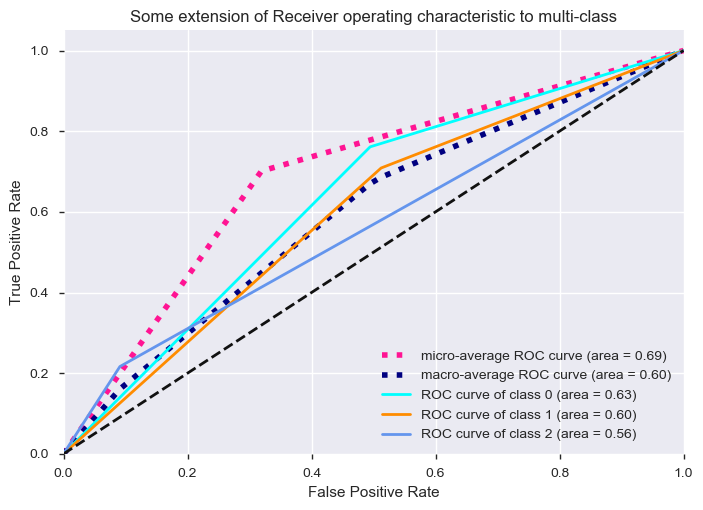

In [91]:
gnb = GaussianNB()
gnb_classifier = fit_classification(gnb, data_dict,{}, model_name = "Naive Bayes Classifier")

best_model = gnb_classifier['model']
y_score = best_model.fit(X_res, y_res).predict(X_test)
y_score.shape
calculate_roc(y_test, y_score, n_classes=3)

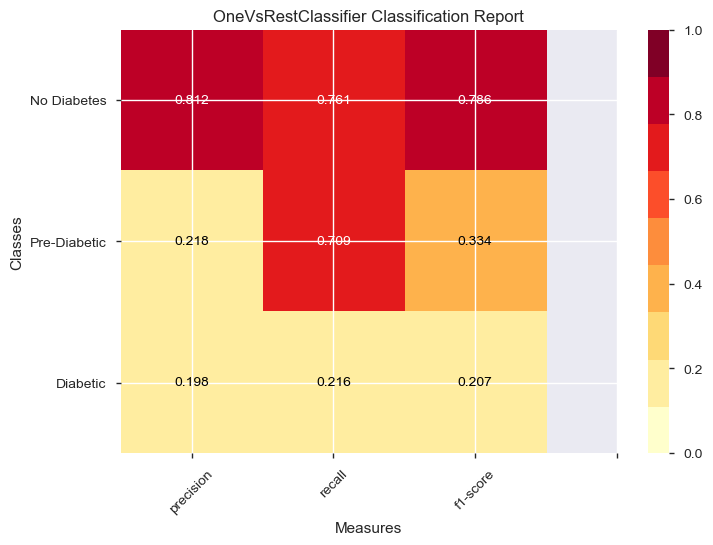

In [92]:
best_model.fit(X_res, y_res) 
y_pred = best_model.predict(X_test) 
target_names = ['No Diabetes', 'Pre-Diabetic', 'Diabetic']
visualizer = ClassificationReport(best_model, classes=target_names, support=True)
visualizer.fit(X_res, y_res)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data


## Decision Trees

  Model: Decision tree
Fit time: 0.69 seconds
Optimal parameters:
{'estimator__min_samples_leaf': 500}

Were parameters on edge? : True
Score variations around CV search grid : 4.96248046603
[ 0.14530907  0.13883947  0.13809813]


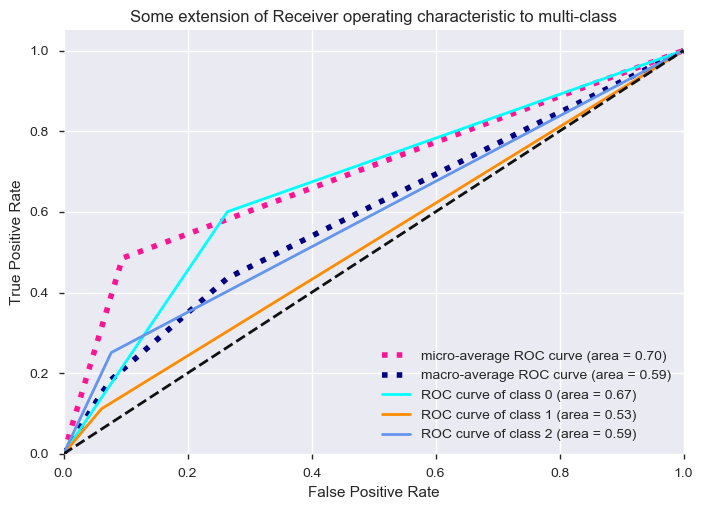

In [93]:
decision_tree = DecisionTreeClassifier()
cv_parameters = {'estimator__min_samples_leaf':[500,600,700]}

decision_tree = fit_classification(decision_tree, data_dict, 
                          cv_parameters = cv_parameters, model_name = "Decision tree")

best_model = decision_tree['model']
y_score = best_model.fit(X_res, y_res).predict(X_test)
y_score.shape
calculate_roc(y_test, y_score, n_classes=3)

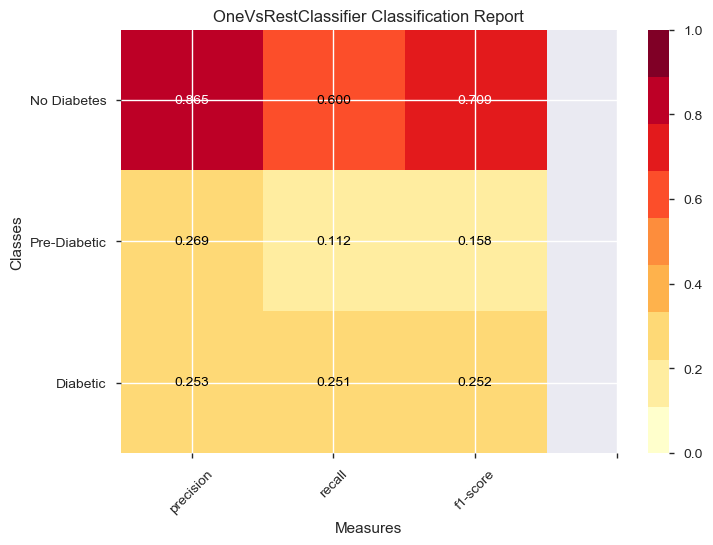

In [94]:
best_model.fit(X_res, y_res) 
y_pred = best_model.predict(X_test) 
target_names = ['No Diabetes', 'Pre-Diabetic', 'Diabetic']
visualizer = ClassificationReport(best_model, classes=target_names, support=True)
visualizer.fit(X_res, y_res)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

## SVM

In [95]:
cv_parameters = {
    "estimator__C": [1,2,3],
    "estimator__kernel": ["linear"]
}

SV_classifier = SVC()

SV_classifier = fit_classification(SV_classifier, data_dict, 
                             cv_parameters = cv_parameters, model_name = "SV Classifier")

  Model: SV Classifier
Fit time: 244.0 seconds
Optimal parameters:
{'estimator__C': 3, 'estimator__kernel': 'linear'}

Were parameters on edge? : True
Score variations around CV search grid : 0.200847991791
[ 0.09958576  0.09959347  0.09978618]


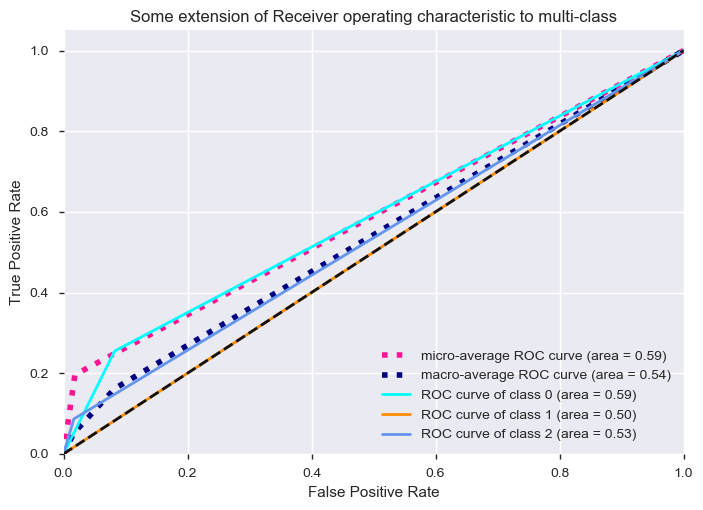

In [96]:
best_model = SV_classifier['model']
y_score = best_model.fit(X_res, y_res).predict(X_test)
y_score.shape
calculate_roc(y_test, y_score, n_classes=3)

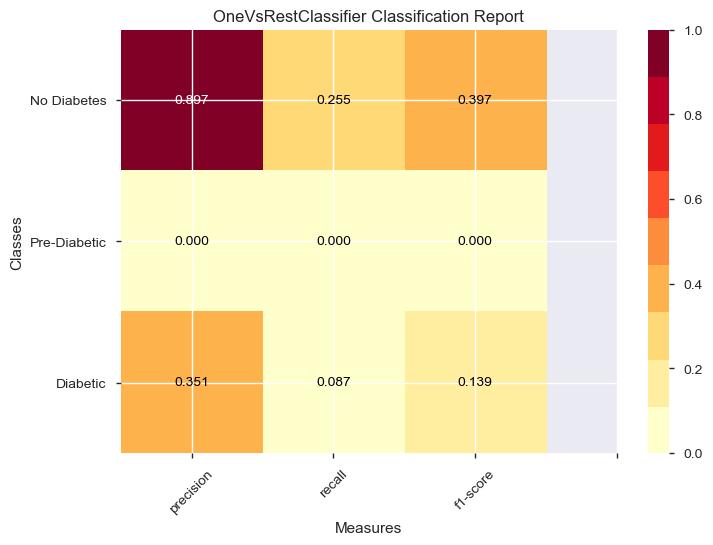

In [97]:
best_model.fit(X_res, y_res) 
y_pred = best_model.predict(X_test) 
target_names = ['No Diabetes', 'Pre-Diabetic', 'Diabetic']
visualizer = ClassificationReport(best_model, classes=target_names, support=True)
visualizer.fit(X_res, y_res)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()   

## L1 logistic penalized with lasso

In [98]:
l1_logistic = LogisticRegression(penalty = 'l1')
cv_parameters = {"estimator__C":np.logspace(0, 6, num = 10)}

l1_logistic = fit_classification(l1_logistic, data_dict,
                        cv_parameters = cv_parameters, model_name = "l1 Penalized Logistic Regression")

  Model: l1 Penalized Logistic Regression
Fit time: 2.04 seconds
Optimal parameters:
{'estimator__C': 100.0}

Were parameters on edge? : False
Score variations around CV search grid : 0.300849011478
[ 0.13826198  0.13846753  0.13861256  0.13867919  0.13867919  0.13867919
  0.13867919  0.13867919  0.13867919  0.13867919]


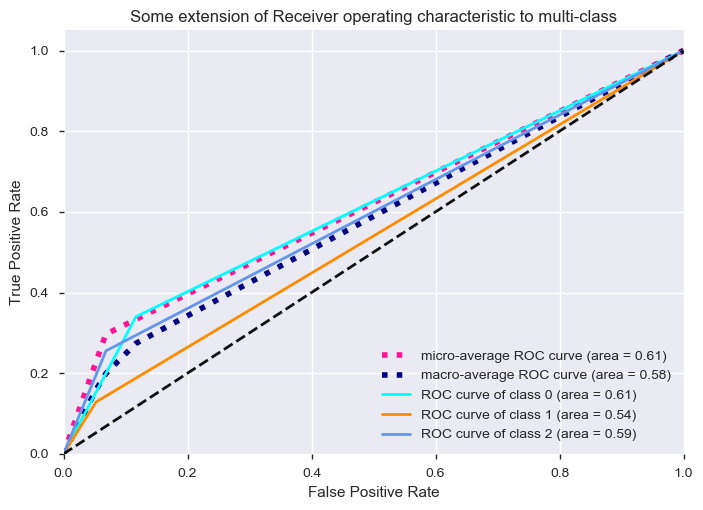

In [99]:
best_model = l1_logistic['model']
y_score = best_model.fit(X_res, y_res).predict(X_test)
y_score.shape
calculate_roc(y_test, y_score, n_classes=3)

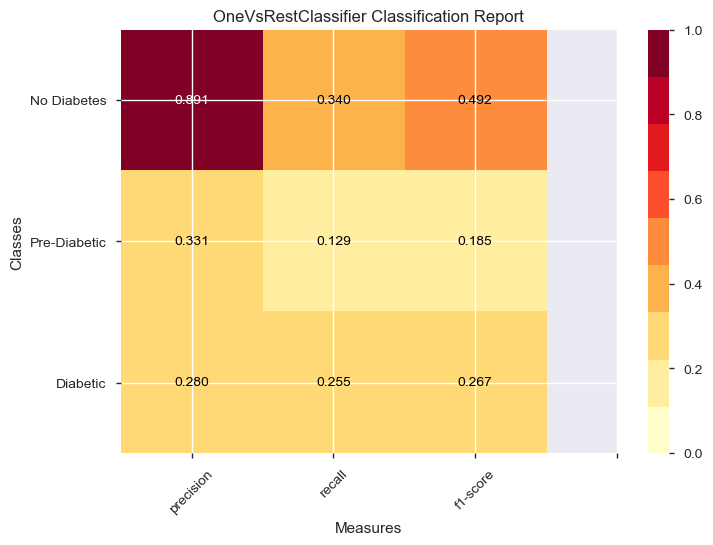

In [100]:
best_model.fit(X_res, y_res) 
y_pred = best_model.predict(X_test) 
target_names = ['No Diabetes', 'Pre-Diabetic', 'Diabetic']
visualizer = ClassificationReport(best_model, classes=target_names, support=True)
visualizer.fit(X_res, y_res)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()   

### Ridge Classifier

  Model: Ridge Classifier
Fit time: 0.7 seconds
Optimal parameters:
{'estimator__alpha': 0.35938136638046259}

Were parameters on edge? : False
Score variations around CV search grid : 42.8426550853
[ 0.12551923  0.12551923  0.12551923  0.12551923  0.12552476  0.12552476
  0.12534663  0.12425504  0.11898589  0.07174662]


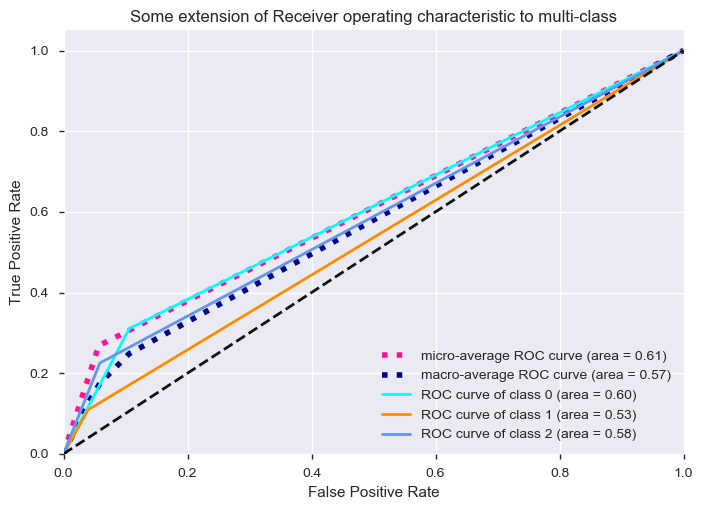

In [101]:
ridge_classifier = RidgeClassifier()
cv_parameters = {"estimator__alpha":np.logspace(-4, 4, num = 10)}

ridge_classifier = fit_classification(ridge_classifier, data_dict, 
                             cv_parameters = cv_parameters, model_name = "Ridge Classifier")
best_model = ridge_classifier['model']
y_score = best_model.fit(X_res, y_res).predict(X_test)
y_score.shape
calculate_roc(y_test, y_score, n_classes=3)

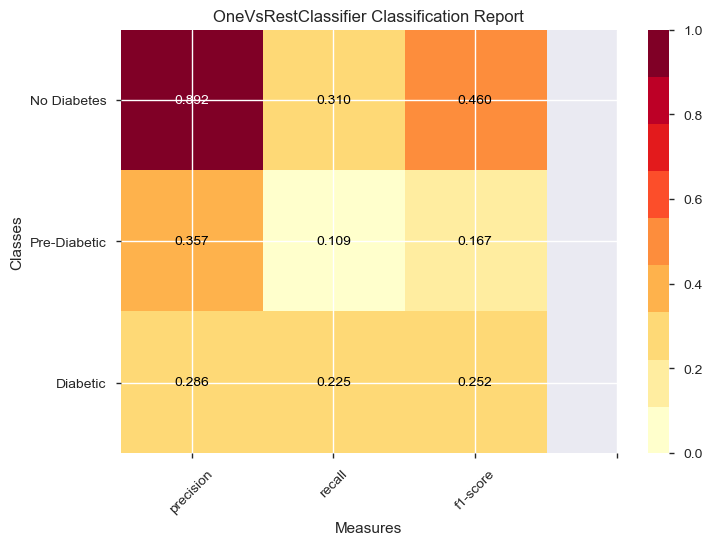

In [102]:
best_model.fit(X_res, y_res) 
y_pred = best_model.predict(X_test) 
target_names = ['No Diabetes', 'Pre-Diabetic', 'Diabetic']
visualizer = ClassificationReport(best_model, classes=target_names, support=True)
visualizer.fit(X_res, y_res)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()   

## Random Forest

In [103]:
random_forest = RandomForestClassifier()

cv_parameters = {'estimator__n_estimators':[50, 100, 150],
                'estimator__max_depth':[3, 4, None]}

random_forest = fit_classification(random_forest, data_dict, 
                             cv_parameters = cv_parameters, model_name = "Random Forest")

  Model: Random Forest
Fit time: 30.83 seconds
Optimal parameters:
{'estimator__max_depth': None, 'estimator__n_estimators': 150}

Were parameters on edge? : True
Score variations around CV search grid : 79.8474754959
[ 0.10062416  0.09949112  0.09699552  0.11779816  0.12168987  0.11753069
  0.47342766  0.48007172  0.48130705]


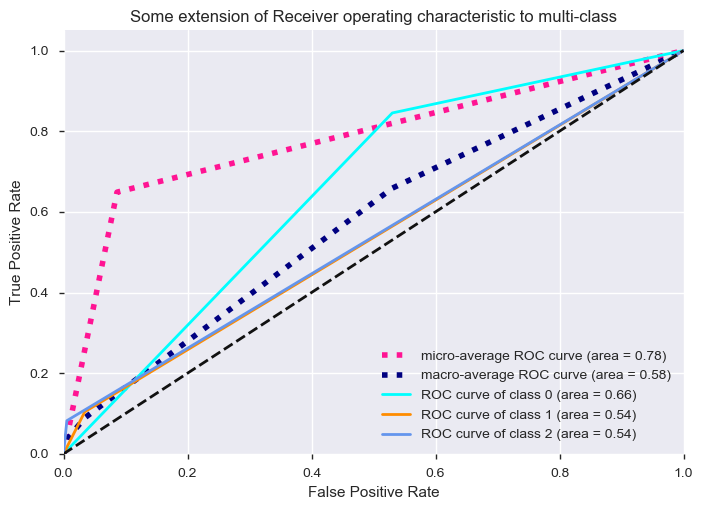

In [104]:
best_model = random_forest['model']
y_score = best_model.fit(X_res, y_res).predict(X_test)
y_score.shape
calculate_roc(y_test, y_score, n_classes=3)

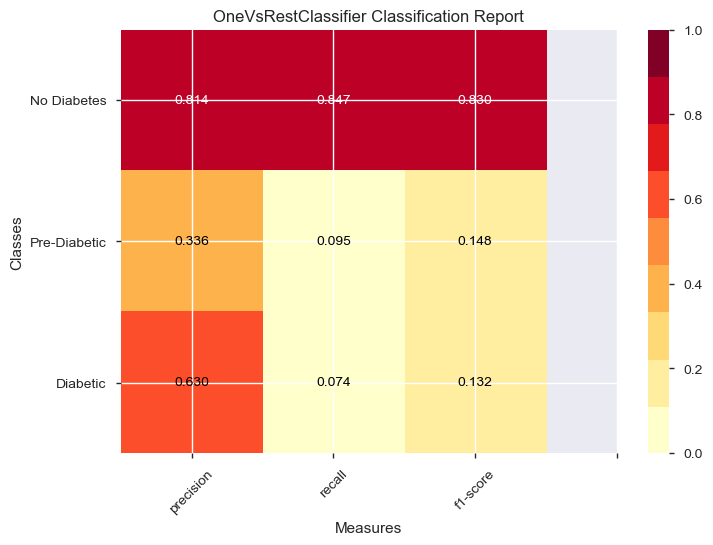

In [105]:
best_model.fit(X_res, y_res) 
y_pred = best_model.predict(X_test) 
target_names = ['No Diabetes', 'Pre-Diabetic', 'Diabetic']
visualizer = ClassificationReport(best_model, classes=target_names, support=True)
visualizer.fit(X_res, y_res)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()   

### XGBoost Classifier

In [106]:
import xgboost as xgb
from xgboost import XGBClassifier

In [107]:
xgbclassifier = XGBClassifier()
cv_parameters = {'estimator__n_estimators':[50, 140, 150,200],
                'estimator__max_depth':[3, 4,5,7]}
random_forest = fit_classification(xgbclassifier, data_dict, 
                             cv_parameters = cv_parameters, model_name = "XG Boost Classifier")

  Model: XG Boost Classifier
Fit time: 152.96 seconds
Optimal parameters:
{'estimator__max_depth': 7, 'estimator__n_estimators': 200}

Were parameters on edge? : True
Score variations around CV search grid : 43.2993379915
[ 0.26330522  0.35738458  0.36171237  0.37349417  0.31992873  0.38728442
  0.39026229  0.39780628  0.35084399  0.40888537  0.41163308  0.42116097
  0.40226663  0.45166715  0.45437383  0.46437768]


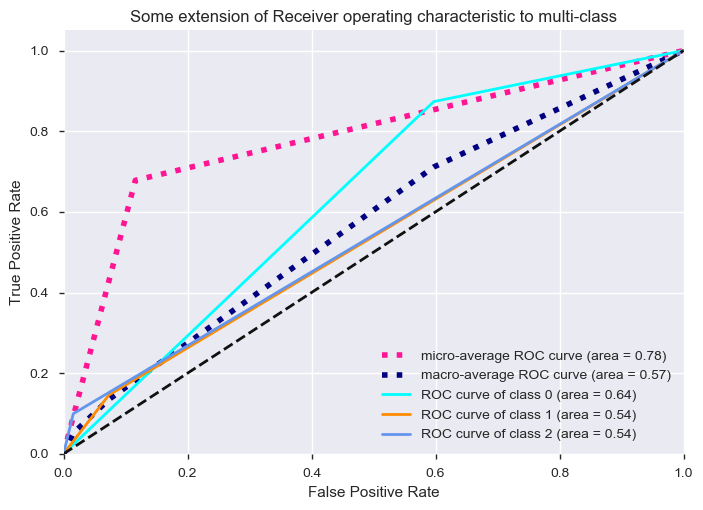

In [108]:
best_model = random_forest['model']
y_score = best_model.fit(X_res, y_res).predict(X_test)
y_score.shape
calculate_roc(y_test, y_score, n_classes=3)

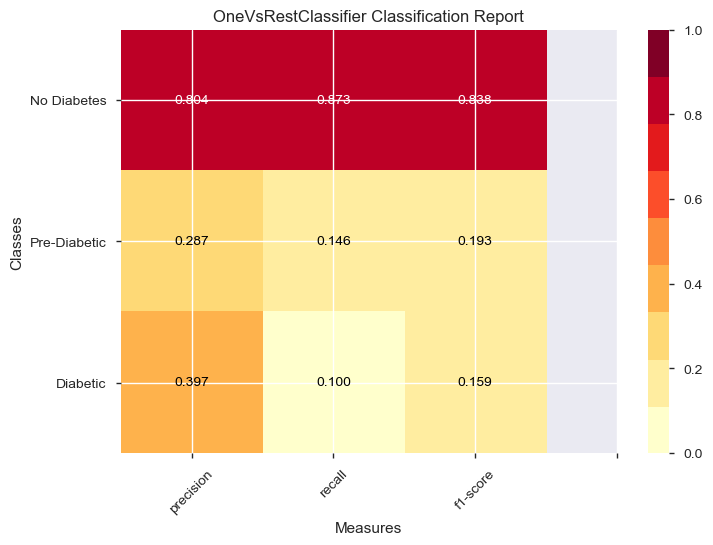

In [109]:
y_pred = best_model.predict(X_test) 
target_names = ['No Diabetes', 'Pre-Diabetic', 'Diabetic']
visualizer = ClassificationReport(best_model, classes=target_names, support=True)
visualizer.fit(X_res, y_res)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()   

Based on the above model evaluations, We are choosing XGBoost to be our best model. Although random forests and xgboost have same ROC, Xgboost has given better precision recall and f1 scores comparitively.
### Best classifier- XGBoost, Random Forest

Model evaluation is crucial part especially in health care domain. We cannot simply go with the model that has highest accuracy score.
To do our model evaluation, for each classifier, we plotted Area under the curve cumulative and for each class, we have calculated precision, recall, f1 scores. We have calculated these values separately for each class. 
In multi class classification problem, it is not a good idea to read these scores on overall data, because there can be 
data imbalance problem which may fool us to think that our models are good. That is why, we have done separate calculation for each class.
Based on the outputs and scores, in our case, random forests and XGBoost classifier is doing good.
Both of them have better area under the curve, and the precision recall scores are slightly better for XGBoost comparitively.
Hence these models gives us whether a person is non diabetic, pre diabetic, or diabetic, given some inputs.


## Remarks:
We want to conclude by saying that, knowing the features that cause pre diabetes and diabetes will help us understand and curb from causing it.
With this study, apart from how age, weight, income , we understood that maintaining oral dental hygiene is one of the important factors that contributing to the cause diabetes and changes in glucose levels. 

Now a days, especially in America, everyone are at risk of pre diabetes. 
We want to suggest everyone that, by changing very small things in lifestyle, diet, and working out regularly, prediabetes can be eradicated and diabetes can be prevented.


## Keep calm and say no to pre Diabetes!!!